# Anomaly detection algorithms

Unsupervised anomaly detection algorithms can detect data that does not belong to normal data patterns. In general, it looks for isolated samples, samples that are in low-density regions. Anomaly detection algorithms can be divided into several approaches such as:

-	Density based 
-	Distance based 
-   Kernel based
-	Statistical approaches
-	Tree-based methods 

In this notebook we test a few of these algorithms. The Local Outlier Factor, robust covariance, One Class Support Vector Machine, Isolation Forest is a tree-based.


**Local Outlier Factor** LOF compares the density of any given data point to the density of its neighbors. Since outliers come from low-density areas, the ratio will be higher for anomalous data points. As a rule of thumb, a normal data point has a LOF between 1 and 1.5 whereas anomalous observations will have much higher LOF. The higher the LOF the more likely it is an outlier (2).
Density-based methods identify anomalies based on the local density of data points. Anomalies are detected as points that have significantly lower density compared to their neighboring points. Another example next to LOF is  DBSCAN.

**Distance-based** methods determine anomalies by measuring the distance or dissimilarity of data points to their neighboring points. Points that are significantly distant or dissimilar from others are considered anomalies. Examples include k-nearest neighbors (k-NN), distance-based outlier detection (e.g., using Mahalanobis distance or Euclidean distance), and angle-based outlier detection. k-NN is the foundation of LOF. in some aspect, one can infers that density base and distance base methods are similar to each other or used as the foundation of each other the reason is that the density is not something more than the number of datapoints in a surface area; consequently, density and distance between datapoints have countradictory relationship in a way that if the distance between points increases the density of the dataset in that local area decreases and vica versa.

The **robust covariance** method is a **gaussian elipse-based method**. If it is outside the gaussian curve, or on the edges it might be an outlier. It is based on the Mahalanobis distance which assesses how many standard deviations σ away xᵢ is from μ. An extreme observation has a large distance from the center of a distribution. An envelope around the data set can be constructed by choosing a critical value of the Mahalanobis distance. Points outside this envelope are considered anomalies/outliers. (1)

**One Class Support Vector Machine** is cluster method based on the Support Vector Machine algorithm. Instead of separating classes into clusters, it separates one class from the origin. The points outside the boundary line are classified as outliers. It uses kernels. The default kernel is ‘rbf’ since most of the time the boundary is not linear. (3)

**Isolation Forest is a tree-based** method. The Isolation Forest algorithm does not explicitly consider density or neighborhood relationships between data points. Instead, it uses the idea that anomalies can be identified more quickly and easily in the tree structure compared to normal data points. Anomalies are expected to have shorter paths in the tree, as they require fewer splits to be isolated. It uses partitioning to make isolated trees, with the goal that each point is isolated. The more partitioning is needed, the more chance a data point is a regular point. An outlier is much easier to isolate than a regular point.  (4)

After a couple days of study, now I can realize that the Anomaly detection techniques are used here to find the outliers, then using them to train a model to predict other relevant outliers that may hapen in the future.

one way that one can use to find the best Anomaly Detection method is by using Cross Validation technique. I will explain this technique fully during studying this study case.

[1] Nascimento et all. "A cluster-based algorithm for anomaly detection in time series using Mahalanobis distance." Proceedings on the International Conference on Artificial Intelligence (ICAI). The Steering Committee of The World Congress in Computer Science, Computer Engineering and Applied Computing (WorldComp), 2015. 

[2] Alghushairy, Omar, et al. "A review of local outlier factor algorithms for outlier detection in big data streams." Big Data and Cognitive Computing 5.1 (2020): 1.

[3] Schölkopf, Bernhard, et al. "Support vector method for novelty detection." Advances in neural information processing systems 12 (1999).

[4] Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. "Isolation-based anomaly detection." ACM Transactions on Knowledge Discovery from Data (TKDD) 6.1 (2012): 1-39.

# Hypothesis

Anomaly detection techniques are commonly employed in predictive maintenance strategies to identify abnormal patterns or behaviors in machine data that may indicate impending failures.

By monitoring various sensor readings, operational parameters, or other relevant data from machines, anomaly detection algorithms can learn the normal behavior or expected patterns of the machines during their normal operation. When a deviation from the normal behavior is detected, it may indicate a potential failure or malfunction. The hypothesis is that the sensor readings of a pump will generate not normal values in case of an (upcoming) failure, and these can be determined with anomaly detection. Several algorithms will be used to evaluate the hypothesis 

datasource: https://en.wikipedia.org/wiki/Feature_engineering



## Assignment

Choose at least 1 out of the listed assignments

- Analyze the end result plot to evaluate the algorithm's performance. Look for anomalies identified by the algorithm and compare them to known anomalies or instances of abnormal behavior in the data. Assess whether the algorithm successfully captures these anomalies and if it shows promising results in detecting abnormal patterns. Based on the plot analysis, provide argumentation for the validity of the anomaly detection algorithm hypothesis (see above). Discuss how the algorithm effectively captures anomalies in the time series data and why it is a suitable approach for the use case. Support your argument with references to relevant literature that discuss the effectiveness of the chosen algorithm or similar algorithms in detecting anomalies in time series data.

- To improve data quality for anomaly detection in time series data, we can focus on removing outliers due to sensor reading errors while preserving anomalies. Additionally, performing resampling or aggregation can help reduce noise and highlight higher-level patterns relevant for anomaly detection. Find common steps to improve data quality for this particular use and implement those. Evaluate the performance of the algorithms compare to the original notebook. 

- Try another algorithm that has not been tested in the notebook. Provide argumentation for the validity of the anomaly detection algorithm you choose. 
- Try to find the best configuration for one of the tested algorithms
- Try anomaly detection on a different dataset without timeseries data. Evaluate the outcome


In [1]:
# import the general libraries
import yaml
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical libraries
from sklearn.preprocessing import StandardScaler, Normalizer
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 

# anomaly detection methods modules
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

# Feature Engineering module
from sklearn.feature_selection import SelectKBest, chi2

## The data
I will make some changes here to read the data properly. I will use a configue file for this aim.

In [2]:
#inspired by https://fennaf.gitbook.io/bfvm22prog1/data-processing/configuration-files/yaml

def configReader():
    """
    explanation: This function open config,yaml file 
    and fetch the gonfigue file information
    input: ...
    output: configue file
    """
    with open("config.yaml", "r") as inputFile:
        config = yaml.safe_load(inputFile)
    return config

In [3]:
def dataframe_maker(config):
    file_directory, file_name = config.values()
    os.chdir(file_directory)
    df = pd.read_csv(file_name).drop('Unnamed: 0', axis=1)
    return df
df = dataframe_maker(configReader())
df.head()

timestamp  sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
0  2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   634.3750   
1  2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2  2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   638.8889   
3  2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   628.1250   
4  2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   636.4583   

   sensor_05  sensor_06  sensor_07  sensor_08  ...  sensor_43  sensor_44  \
0   76.45975   13.41146   16.13136   15.56713  ...   41.92708  39.641200   
1   76.45975   13.41146   16.13136   15.56713  ...   41.92708  39.641200   
2   73.54598   13.32465   16.03733   15.61777  ...   41.66666  39.351852   
3   76.98898   13.31742   16.24711   15.69734  ...   40.88541  39.062500   
4   76.58897   13.35359   16.21094   15.69734  ...   41.40625  38.773150   

   sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  sensor_50  \
0   65.68287   50.92593  38.194440   157.9861   67.70834   243.0556   
1   65.68287   50.92593  38.194440   157.9861   67.70834   243.0556   
2   65.39352   51.21528  38.194443   155.9606   67.12963   241.3194   
3   64.81481   51.21528  38.194440   155.9606   66.84028   240.4514   
4   65.10416   51.79398  38.773150   158.2755   66.55093   242.1875   

   sensor_51  machine_status  
0   201.3889          NORMAL  
1   201.3889          NORMAL  
2   203.7037          NORMAL  
3   203.1250          NORMAL  
4   201.3889          NORMAL  

[5 rows x 54 columns]

In [4]:
# make a copy of the dataset
df_origin = df.copy()

## Inspect data
This component holds significant importance in every machine learning process as it provides data scientists with valuable insights into a dataset. In this particular case study, in addition to the employed inspection methods, I will incorporate additional techniques to enhance my understanding of the dataset.

In [5]:
def data_inspector(df):

    # find the shape of data
    print(f'dataset has {df.shape[0]} observations, and {df.shape[1]} variables\n')

    # finding the information of this dataset
    print(f'{df.info()}\n')

    # extract the list of null values for columns (mostly sensors)
    null_values = df.isnull().sum(axis=0)
    print(f'number of null values for each columns\n{null_values}\n')
    print(f'maximum number of null values belong to {null_values.idxmax()} with {null_values.max()}\n')
    print(f'minimum number of null values belong to {null_values.idxmin()} with {null_values.min()}\n')
    
    # find the number of null values in the Broken points
    status_df = pd.DataFrame(df.groupby('machine_status'))
    broken_null_values = status_df[1][0].isnull().sum(axis=0)
    print(f'the number of Broken null data is as follows\n{broken_null_values}')

    # investigate null values based on percentages
    percentage_missing = df.isnull().sum().sort_values(ascending=False)/len(df)*100
    print(f'classified the maximum number of null values based on percentage\n')
    print(f'{percentage_missing.head()}\n') # show 5 largest missing 
    
    # find the number of members for each group in machine_status column
    print(f'number of members for each category in machine_status\n')
    print(f'{df.machine_status.value_counts()}\n')

In [6]:
data_inspector(df)

dataset has 220320 observations, and 54 variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  senso

For finding the complete set of inspecting information please click on text editor. Machine_status column is a quite important column since one can find about the status of the pomp, the number of breaks and recovery duration by take a look at this column. Based on this information this pomp was broken seven times, 14477 hrs was in the recovery time, and work normally in the rest of this duration.

Regarding the quality of the dataset, there are two columns that show a great number of null values (sensor-15, and sensor-50); consequently, in order to not let these low quality data affects the whole dataset and the subsequent analysis one can erase them from the dataset.

To get more familiar with this dataset, based on this <a href = 'https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering'> link</a>, one can sketch all the sensors' plots as follows. This approach can enhance our comprehension of sensor functionality and even provide insights into the pump's operation.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

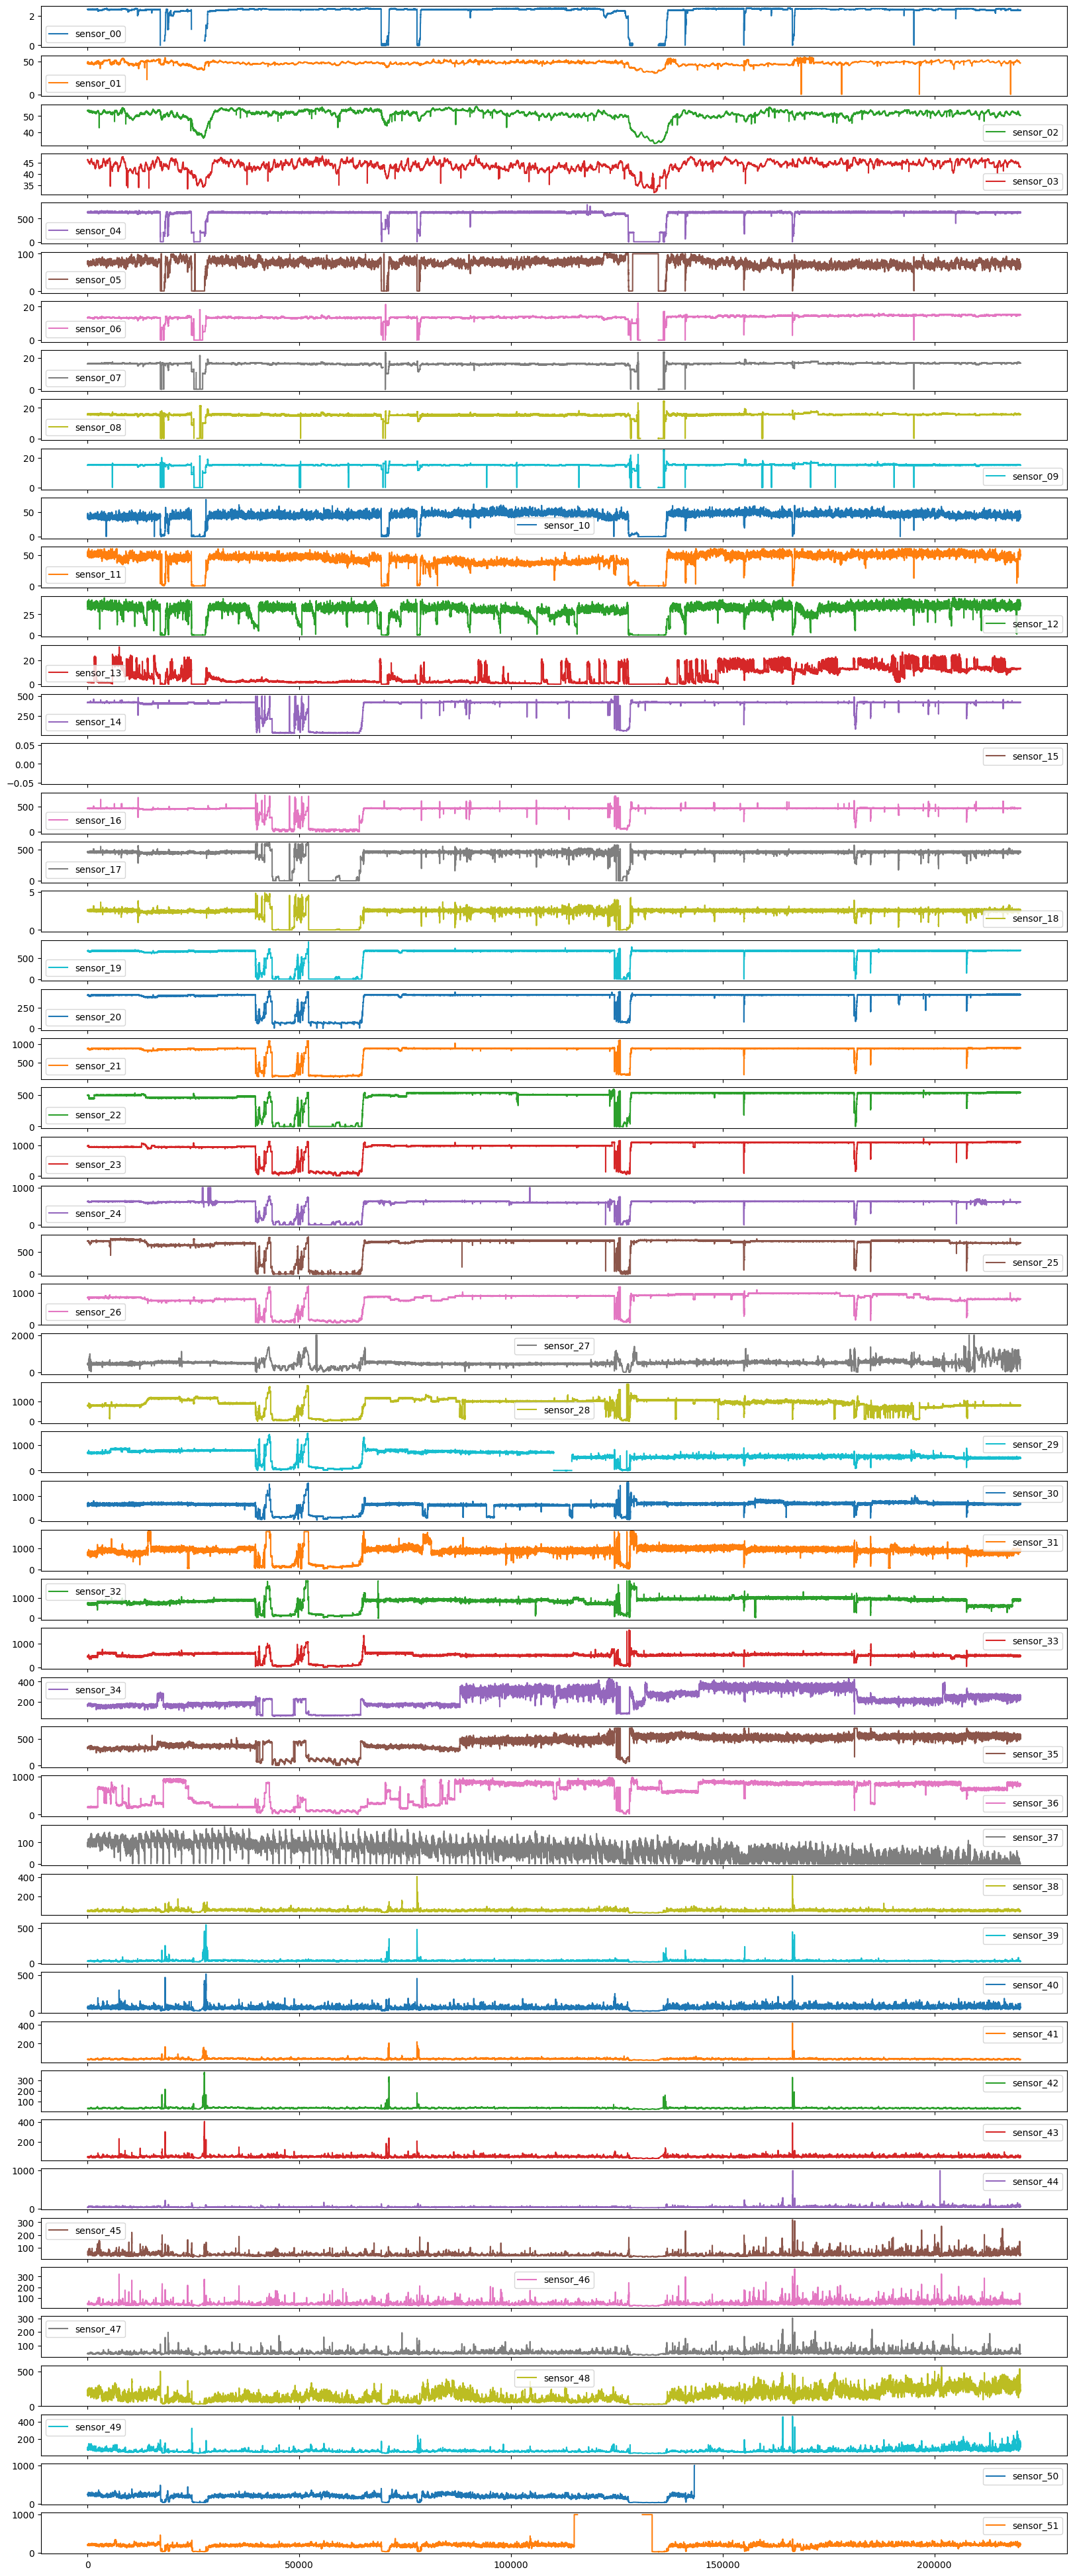

In [7]:
# time series plots for sensor data
df.plot(subplots =True, sharex = True, figsize = (20,50))

The plots offer valuable insights and additional observations. Firstly, as mentioned during the data inspection phase, it is evident that sensor-15 and sensor-50 have a significant number of missing values. In fact, sensor-15 lacks any data points entirely, while sensor-50 has no information available for approximately one-third of the period. Furthermore, certain sensors exhibit a minor amount of missing data, which can be addressed using various machine learning techniques. Additionally, some sensors display notable noise levels. For instance, sensor-37 is entirely noisy, with its data corrupted to the extent that no discernible trend in pump functionality can be detected. Although several other sensors, such as 5, 13, 34, 46, and 48, also exhibit significant noise, they still manage to capture the underlying trend. Finally, based on their behavior, the sensors can be categorized into distinct groups, with sensors within each group behaving similarly but differently from sensors in other groups. Identifying the cause behind these patterns is essential, as it may indicate varying functionalities or potential malfunctions. Analyzing these sensors would require different approaches depending on the specific situation. Now with this insight, one can begun preprocessing part.

# Preprocessing
Based on the above information one can immidiately find that snesor-15 with 100% missing data, and sensor-50 with about 34% should be removed to preserve the quality of the dataset. Also, one can change the type of timestamp column into datetime and set it an the index of the dataset.

In [7]:
# drop low quality columns
df.drop(['sensor_15', 'sensor_50'],inplace = True,axis=1)
# set timestamp to date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

Furthermore, it is worth evaluating the data quality of sensor-51, considering that it has more than five percent missing values. To accomplish this, one can utilize the machine status technique described in the <a href = 'https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering'> link</a>. Additionally, creating a machine status plot for sensor-00 would be highly informative since it represents the fourth highest proportion of missing values. Comparing this plot with that of sensor-51 can provide valuable insights.

In [8]:
# This visualization inspired from JANANI KARIYAWASAM found at 
# https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering

broken_rows = df[df['machine_status']=='BROKEN']
recovery_rows = df[df['machine_status']=='RECOVERING']
normal_rows = df[df['machine_status']=='NORMAL']

def plot_sensor(sensor):
    plot = plt.figure(figsize=(25,3))
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering')
    plot = plt.plot(df[sensor], color='grey')
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=14, label = 'broken')
    plot = plt.title(sensor)
    plot = plt.legend()
    plt.show()

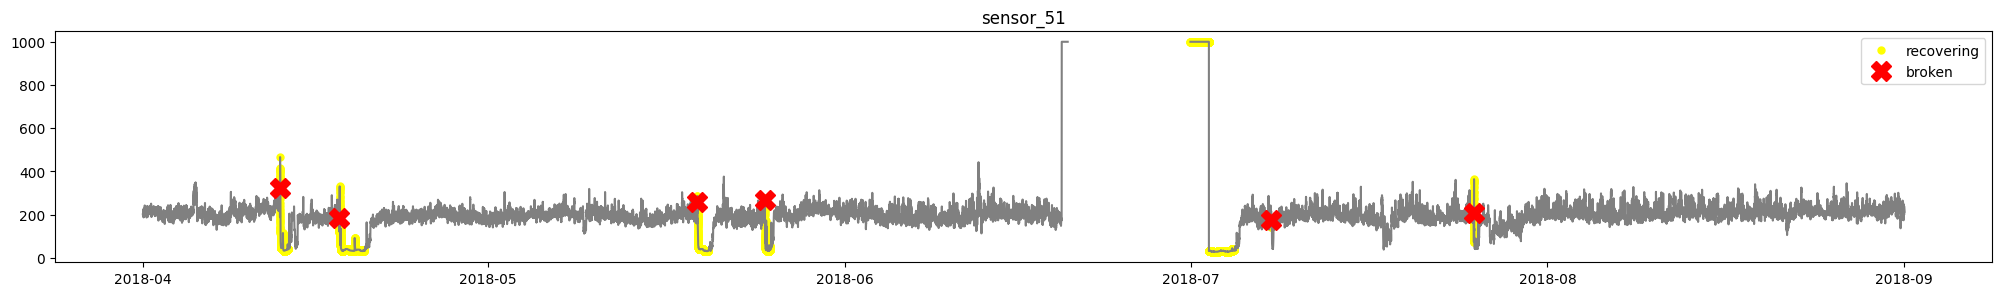

In [9]:
# plot sensor 51
plot_sensor('sensor_51')

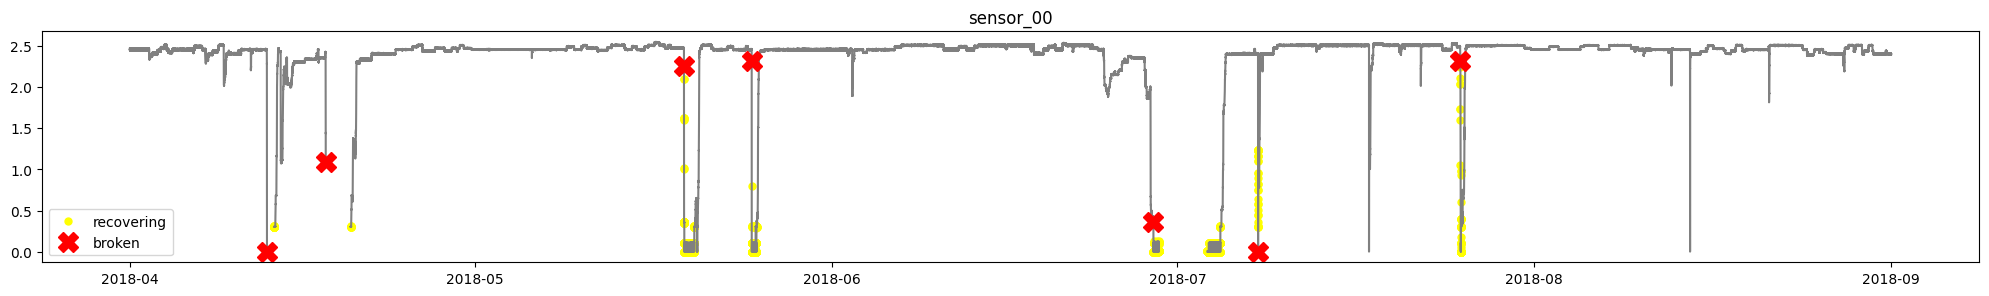

In [10]:
plot_sensor('sensor_00')

The key distinction between these two plots lies not only in the increased noise level of sensor-51 and the varying patterns but also in the absence of a particular broken point in sensor-51. Given that this study focuses on identifying broken points, this missing data can significantly impact the overall model outcome. Consequently, there are two potential approaches to address this issue. Also, one can evaluate the number of missing values in each category with and without sensor-51 since this column contains more than 15 thousand missing data.  To find this, one can use machine status plot for all the sensor or just use an inspecting technique to sum over all the missing data in each section. Here I will use the later approach.

In [11]:
def null_in_status(df):
    status_df = pd.DataFrame(df.groupby('machine_status'))

    for number in range(len(status_df[0])):
        null_number = status_df.iloc[number, 1].isnull().sum().sum()
        print(f'the number of missing values for {status_df.iloc[number, 0]} category is {null_number}')

null_in_status(df)

the number of missing values for BROKEN category is 1
the number of missing values for NORMAL category is 14019
the number of missing values for RECOVERING category is 33217


In [12]:
sensor_51 = df[['sensor_51', 'machine_status']]
null_in_status(sensor_51)

the number of missing values for BROKEN category is 1
the number of missing values for NORMAL category is 12384
the number of missing values for RECOVERING category is 2998


It can be infer that about 88% of missing values in NORMAL category is in the sensor-51 data. So, if one remove this column from the dataset the proportion of the missing values in Recovering category increases from about 70% to about 95%. This will allow us to use imputation methods that most align more with the RECOVERING category, and at the end, it will give us a a higher quality model.

In [13]:
df.drop('sensor_51',inplace = True,axis=1)
null_in_status(df)

the number of missing values for BROKEN category is 0
the number of missing values for NORMAL category is 1635
the number of missing values for RECOVERING category is 30219


In [14]:
broken_rows = df[df['machine_status']=='BROKEN']
recovery_rows = df[df['machine_status']=='RECOVERING']
normal_rows = df[df['machine_status']=='NORMAL']

 ### Imputation techniques
Base on this <a href = 'https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering'> link</a>, some basic imputation techniques can be 

    zero imputation
    mean imputation
    forward or backward fill imputation

While The technique that has been used in this study to impute the missing values is mean imputaion, it may not the best one in this context. The reason is that after removing sensor_51 data the majority of missing values (about 95%) belong to RECOVERING category, and the difference between these data points and the Normal ones is that they drastically deviate from the mean value of each sensor's dataset. Also, by implementing mean imputation we may unwantedly remove many anomaly points from the dataset; thus, mean imputation cannot be a good representative of the propbable values of the missing values. Moreover, zero imputation can be a good representative for some sensor datasets since their value in RECOVERING category is roughly zero; however, zero cannot be a good repesentative for all the other sensors that have RECOVERING values more than zero since zero may acts as an extrme value (outlier) in these datasets and corrupt the outcomming model. Furthermore, still 5% of the missing data belongs to NORMAL category, so by replacing zero with this values, we may create new anomalies or ourlier in the dataset.Consequently, the best method that one can use in this specific case can be forward or backward fill, and I will choose backward fill in this study.

Also on can click on the following links to get familiar with more imputation methods:

https://www.kaggle.com/code/juejuewang/handle-missing-values-in-time-series-for-beginners/report

https://datascience.stackexchange.com/questions/57776/explain-forward-filling-and-backward-filling-data-filling

https://www.kaggle.com/code/dansbecker/handling-missing-values/notebook

In [15]:
def df_croper(df,column_name):
    
    dfs_dict = {}
    unique_names = list(df[column_name].unique())
    for name in unique_names:
        crop_df = df[df[column_name]==name]
        dfs_dict[name] = crop_df

    return dfs_dict

In [16]:
def df_imputer(df, method='bfill'):
    m, n = df.shape
    X = df.fillna(method=method)

    return X

To evaluate the result of the imputing technique and also to have an exact sense of the location of the BROKEN and RECOVERING datapoints one can use machine status plot of the sensors.

In [17]:
def plot_sensor_anomolies(df, sensor_names, column_name='machine_status', anomaly_method_name=None):
    
    broken_rows = df[df['machine_status']=='BROKEN']
    recovery_rows = df[df['machine_status']=='RECOVERING']
    

    for sensor in sensor_names:
    
        plt.figure(figsize=(25,3))
        plt.plot(df[sensor], color='grey')
        plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering',alpha = 0.5)
        plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=20, label='broken')

        if anomaly_method_name != None:
            anomoly_rows = df[df[f'{anomaly_method_name}'] == -1]
            plt.plot(anomoly_rows[sensor], linestyle='none', marker='X', color='blue', markersize=7, label='anomoly predicted', alpha = 0.2)

        plt.title(sensor)
        plt.legend()
        plt.show();

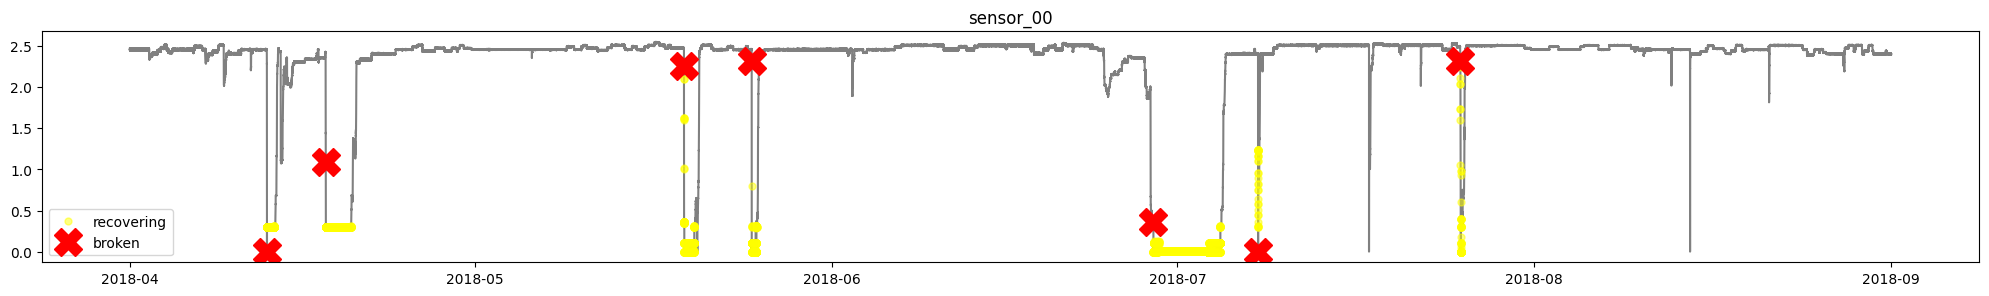

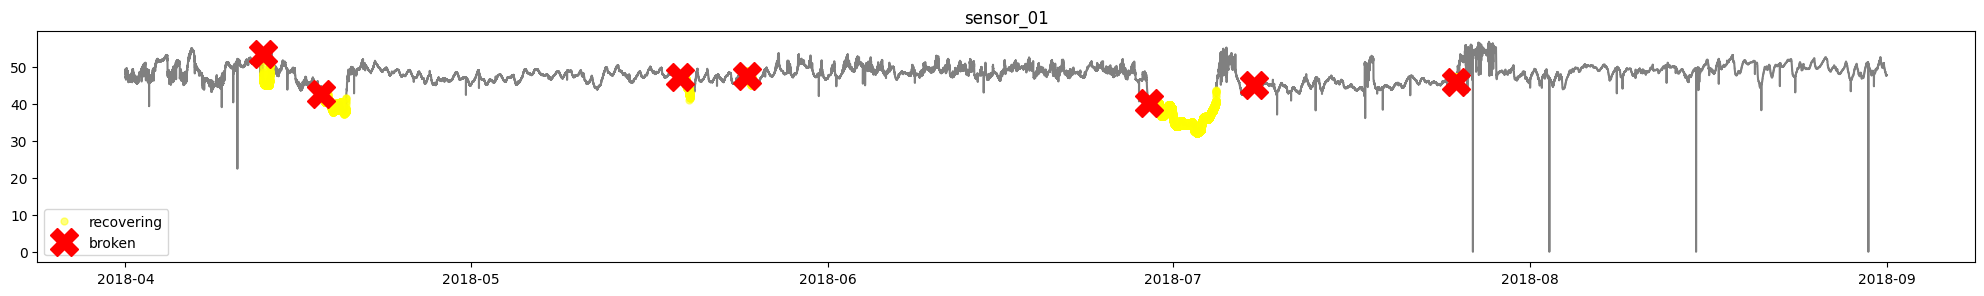

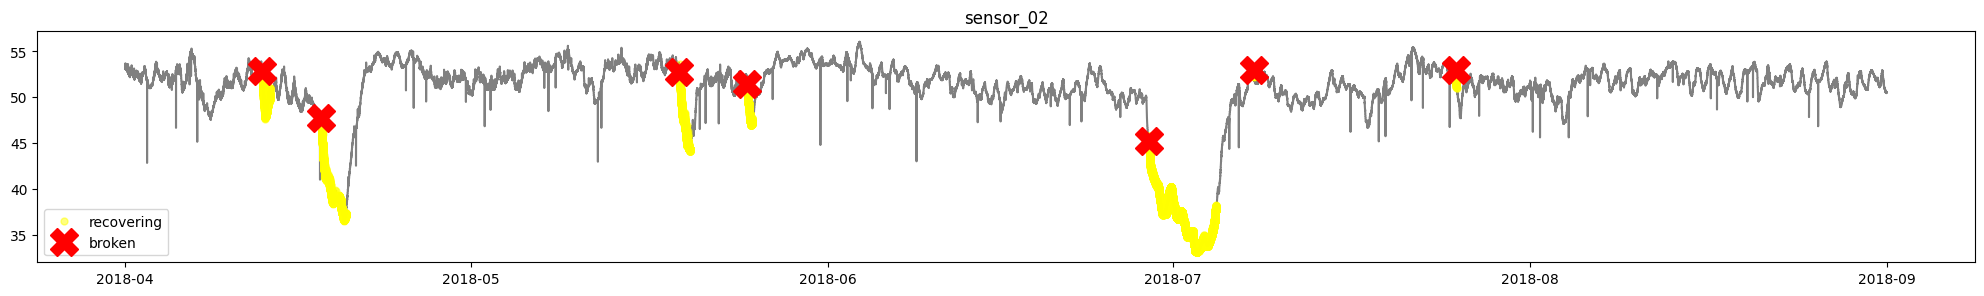

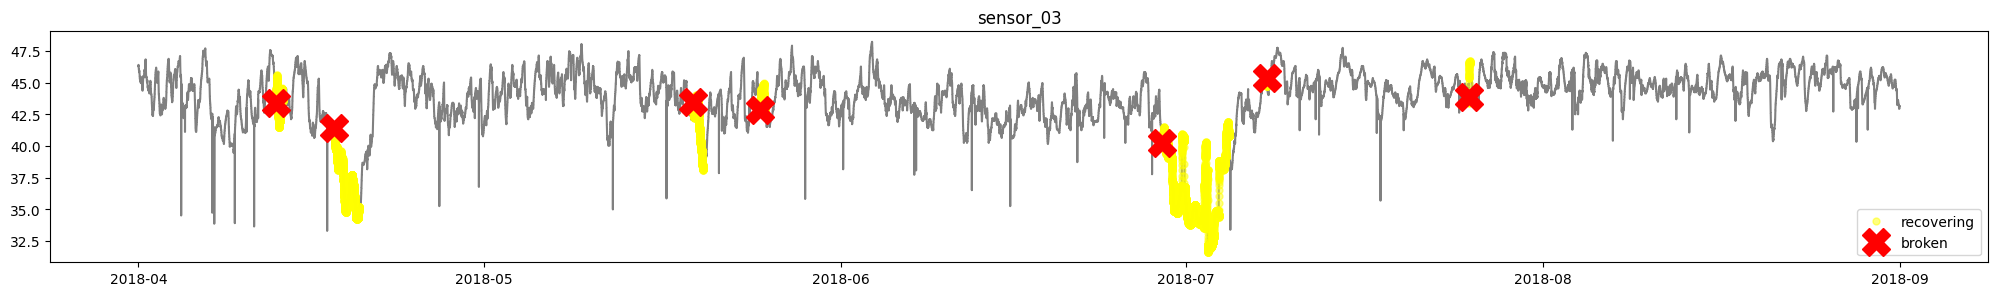

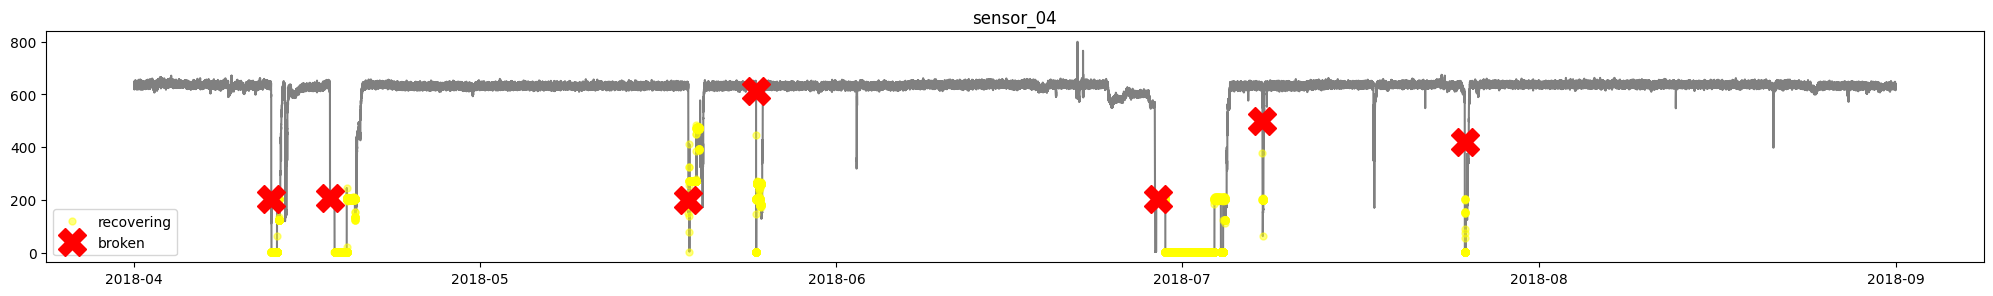

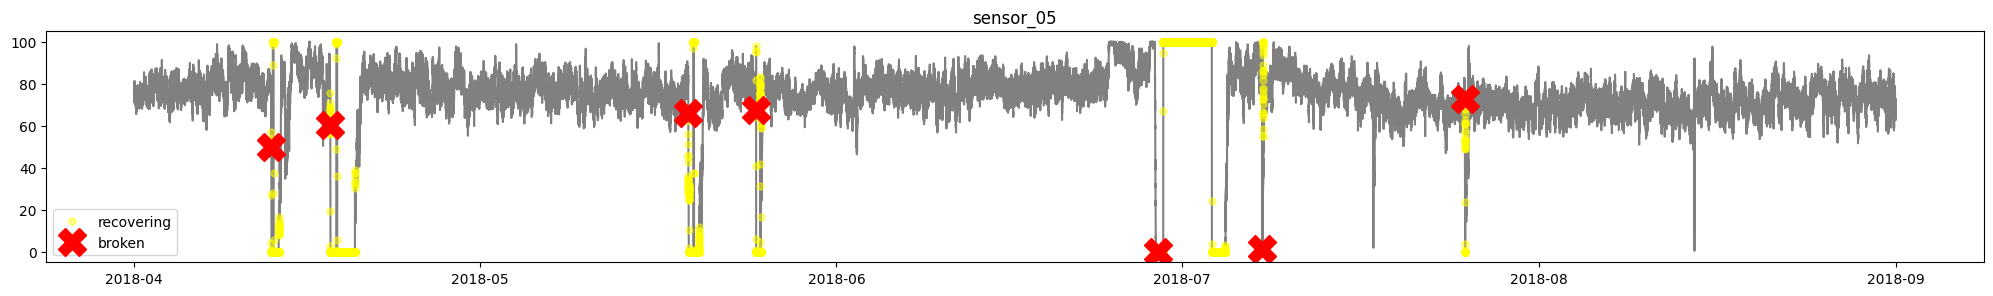

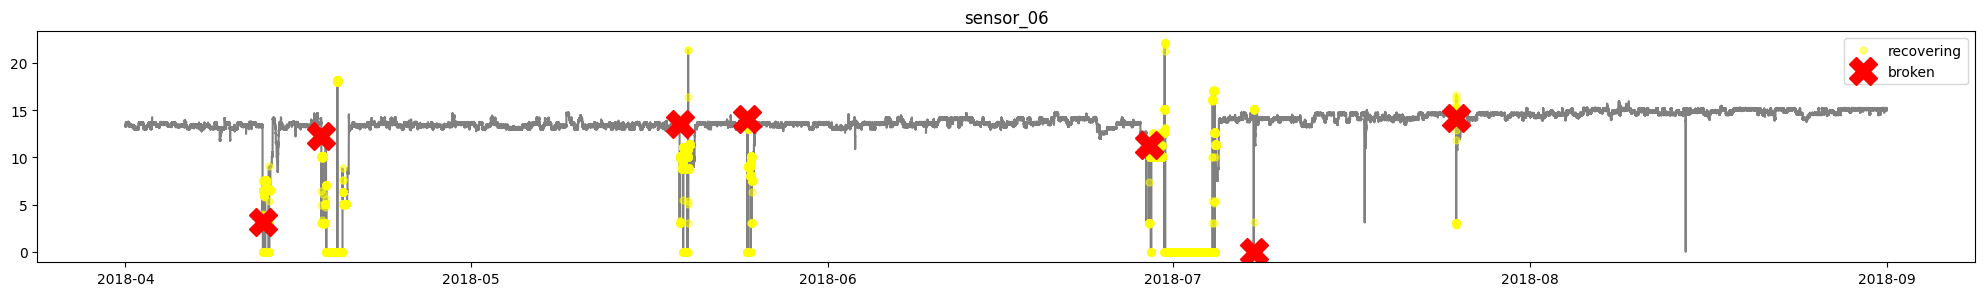

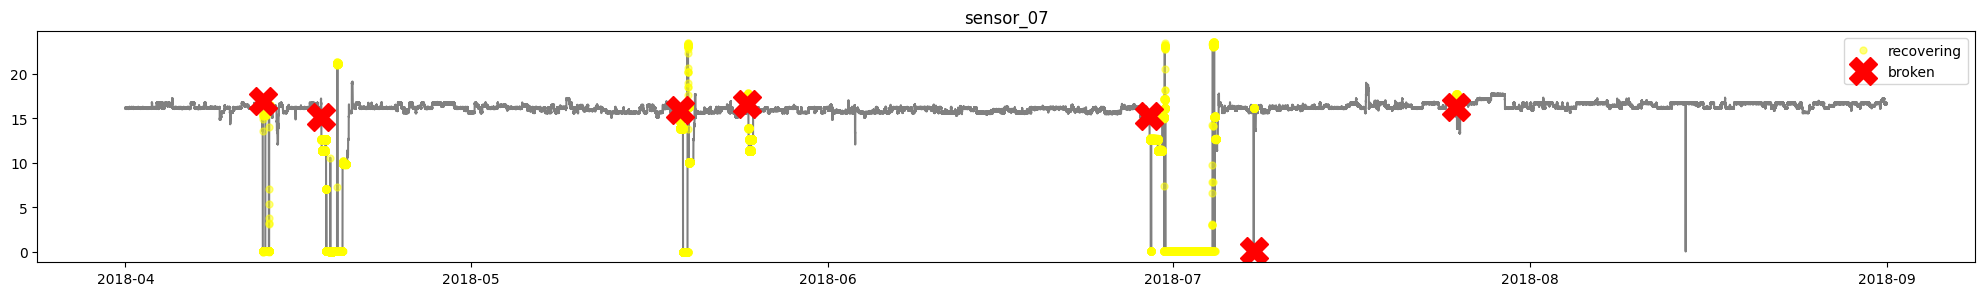

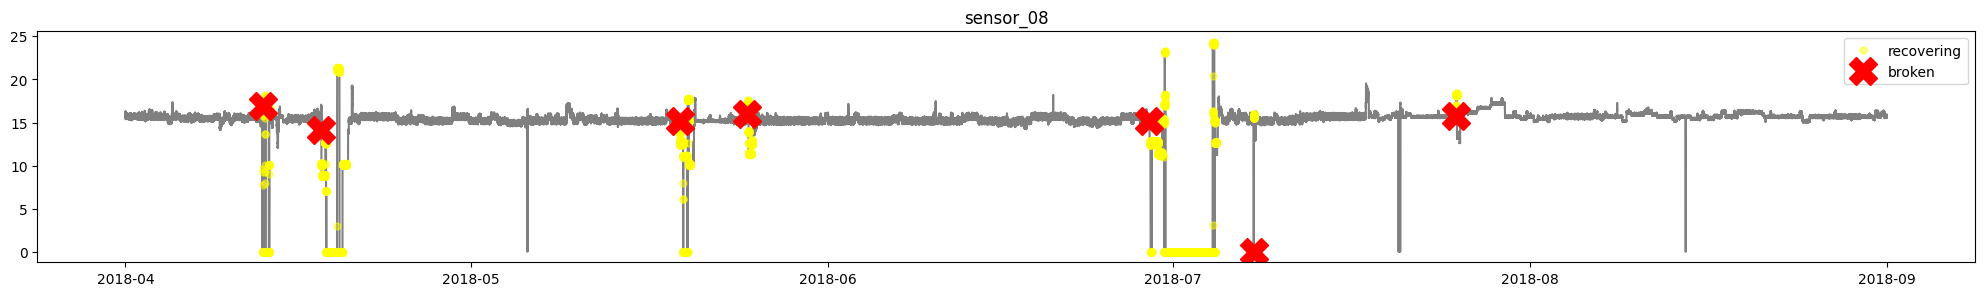

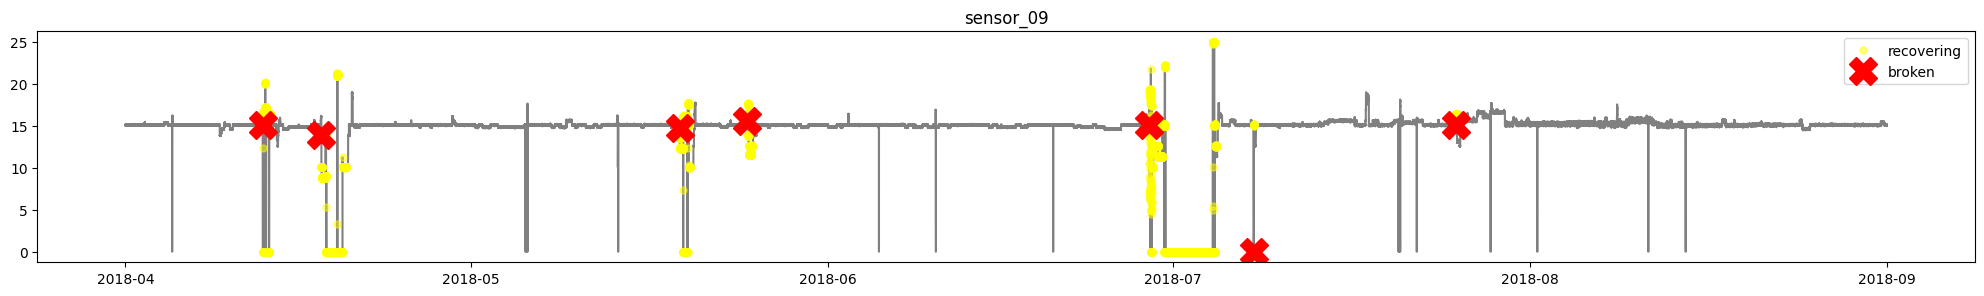

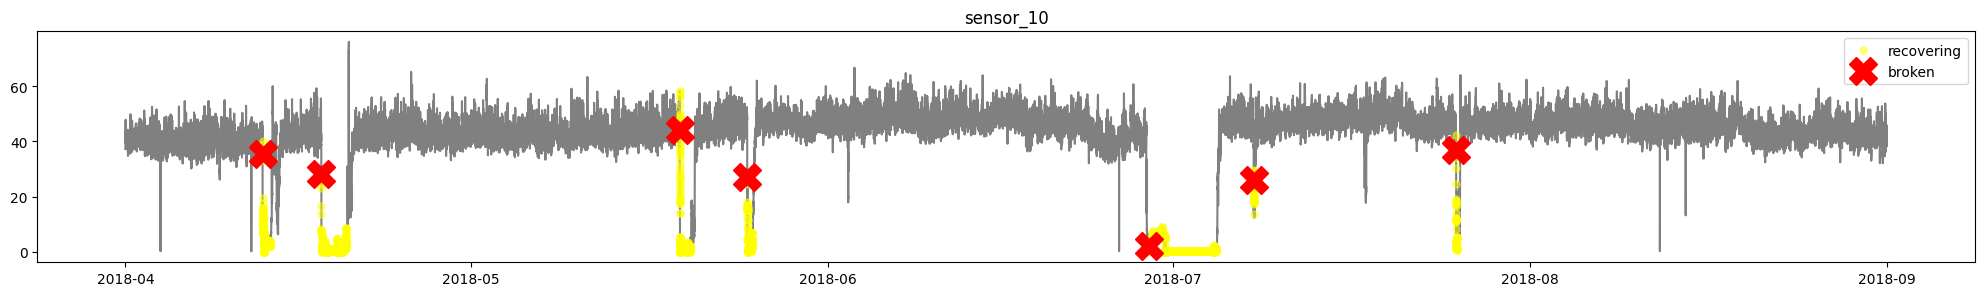

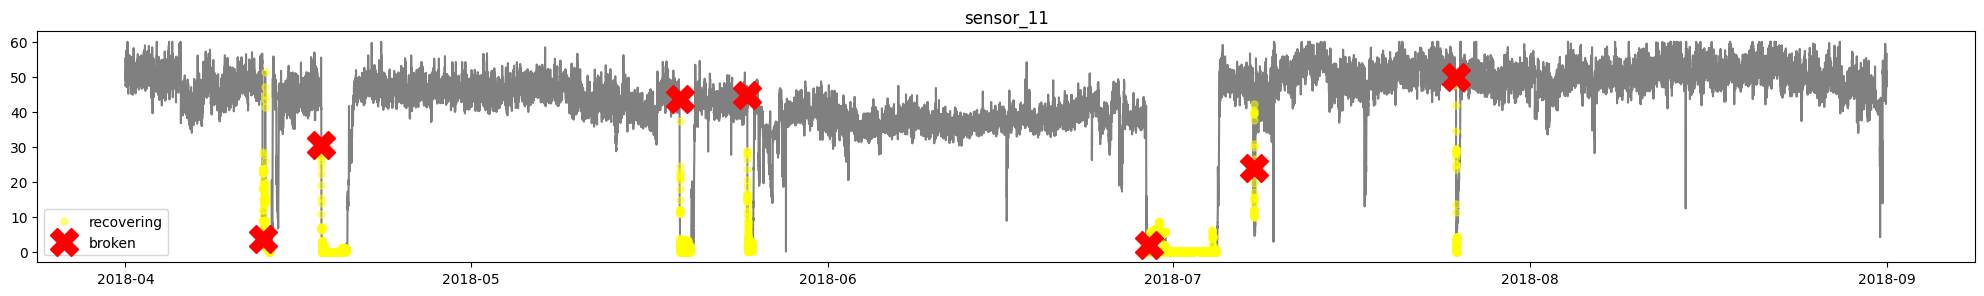

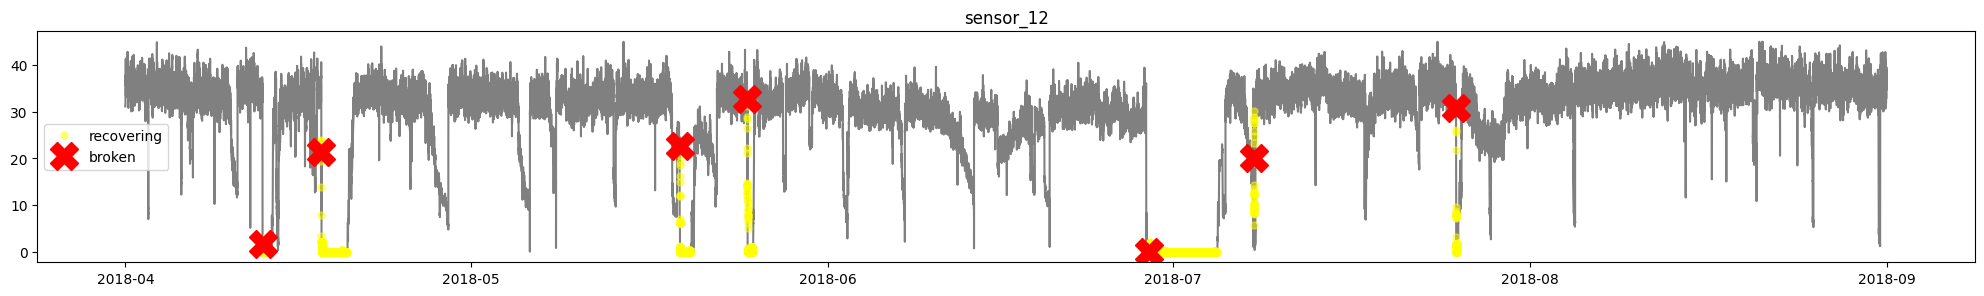

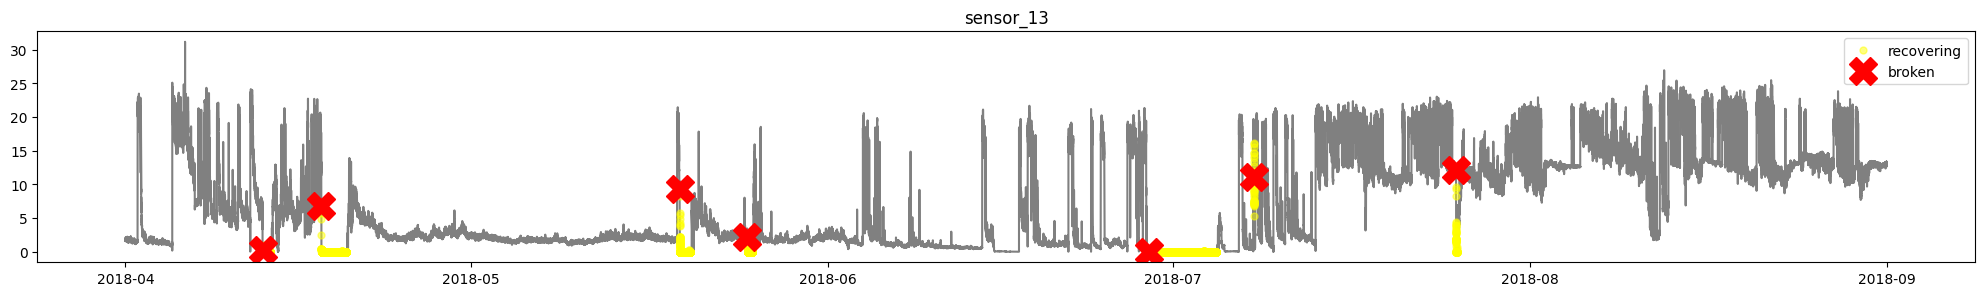

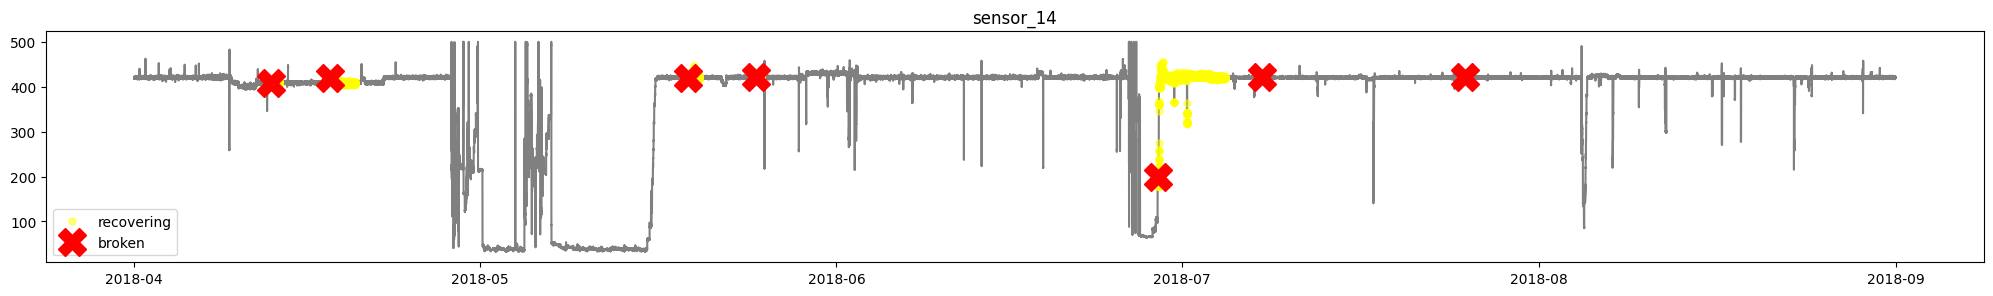

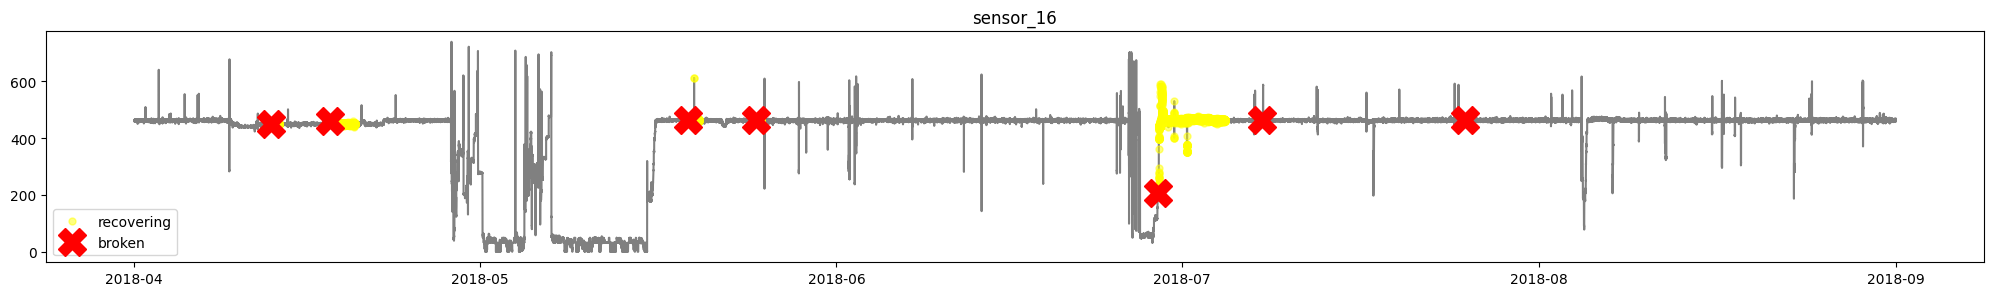

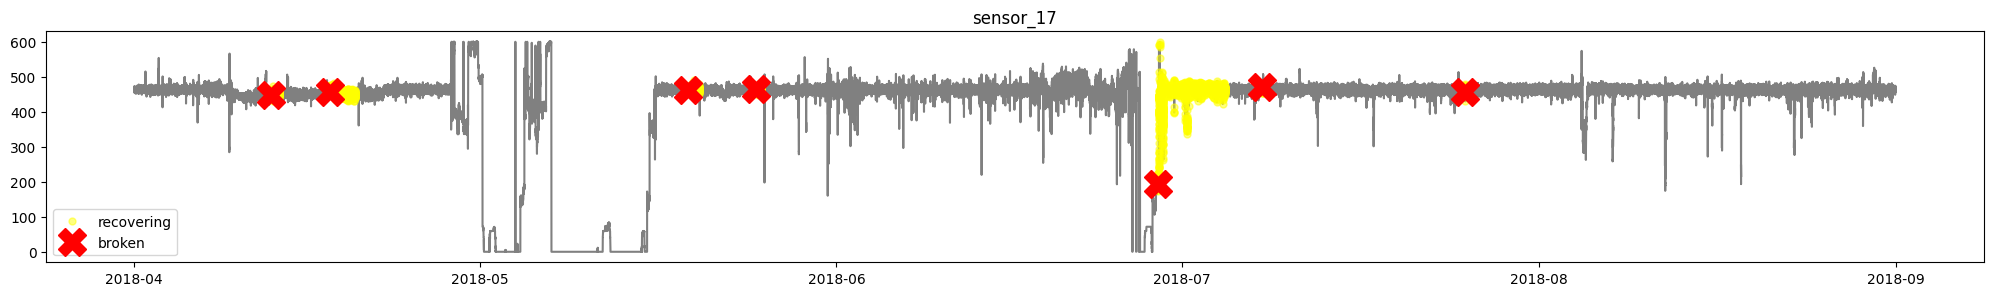

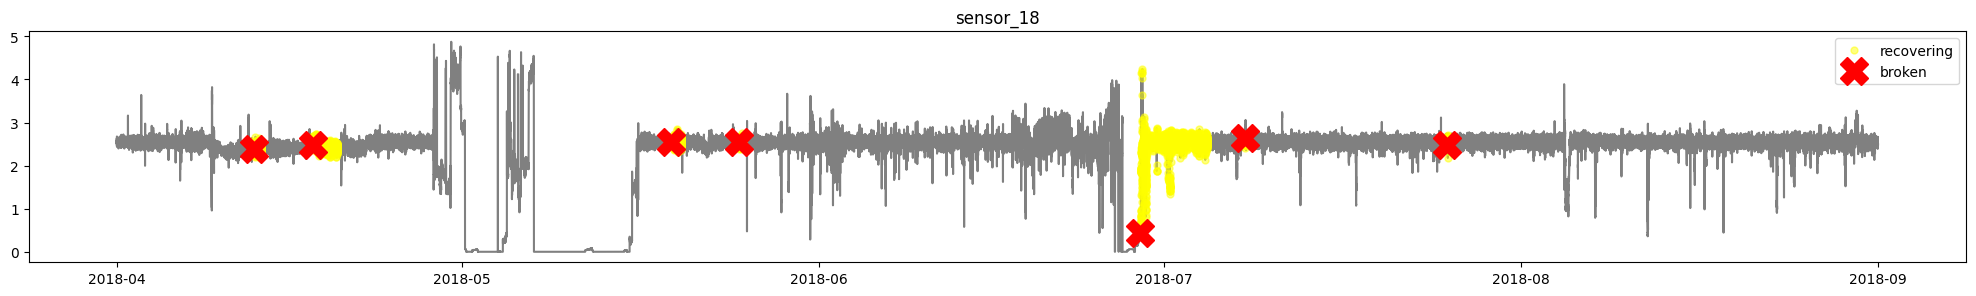

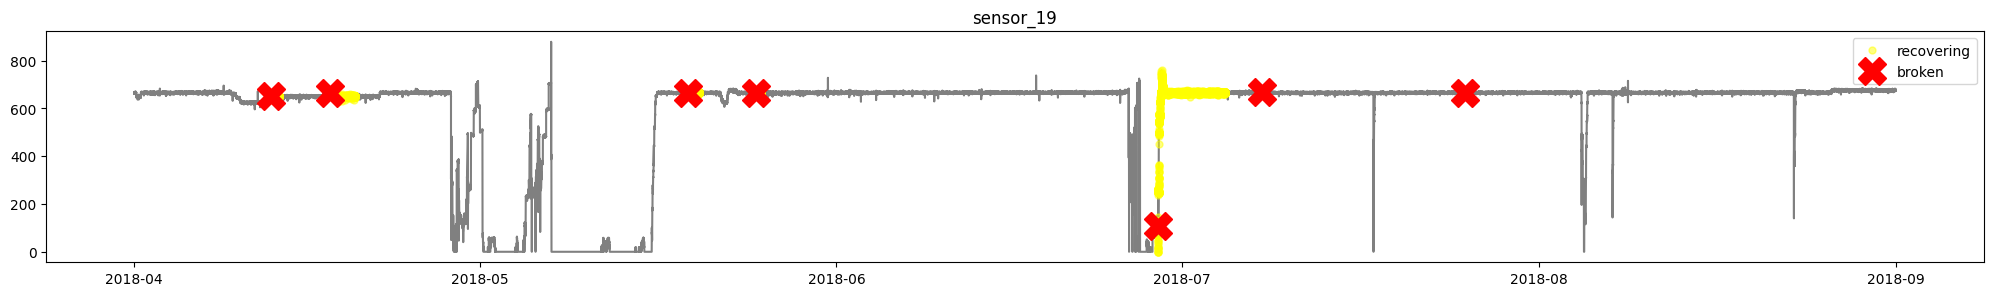

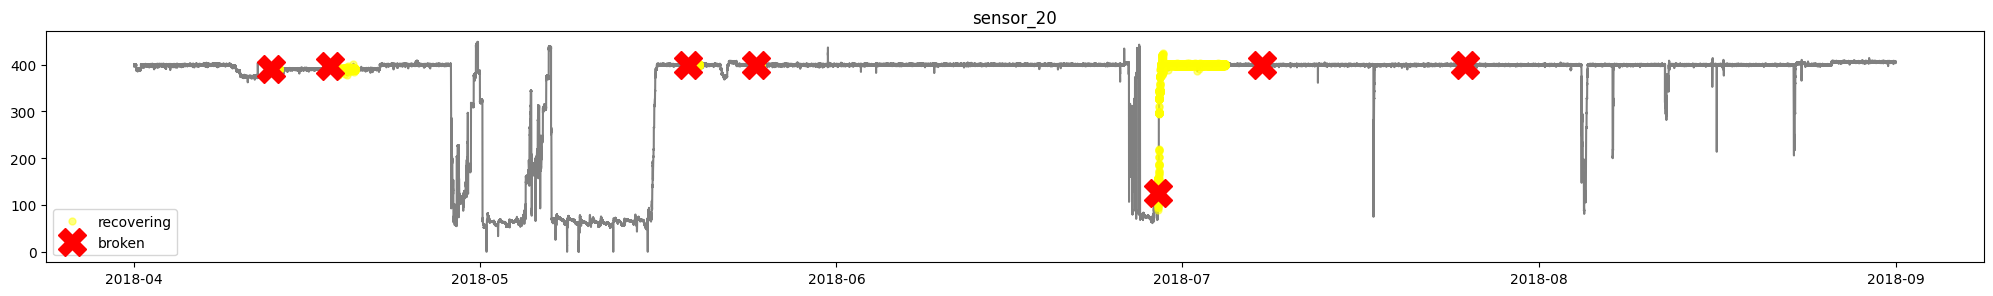

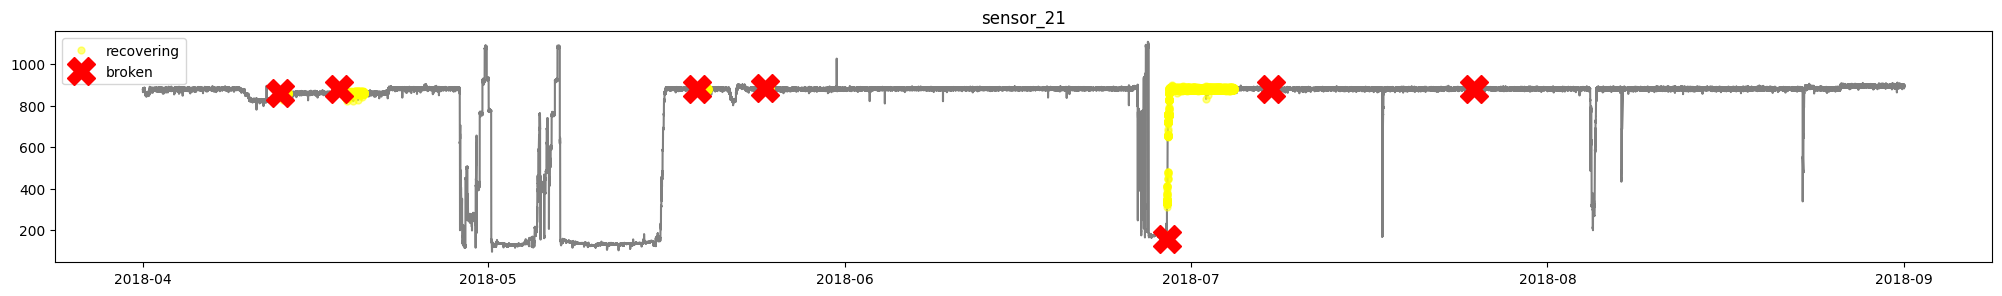

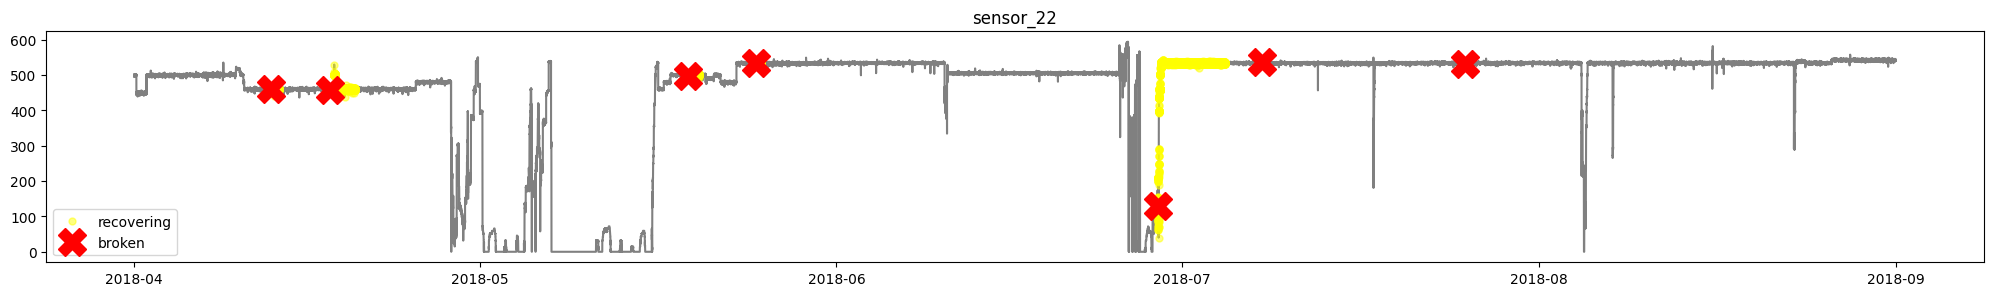

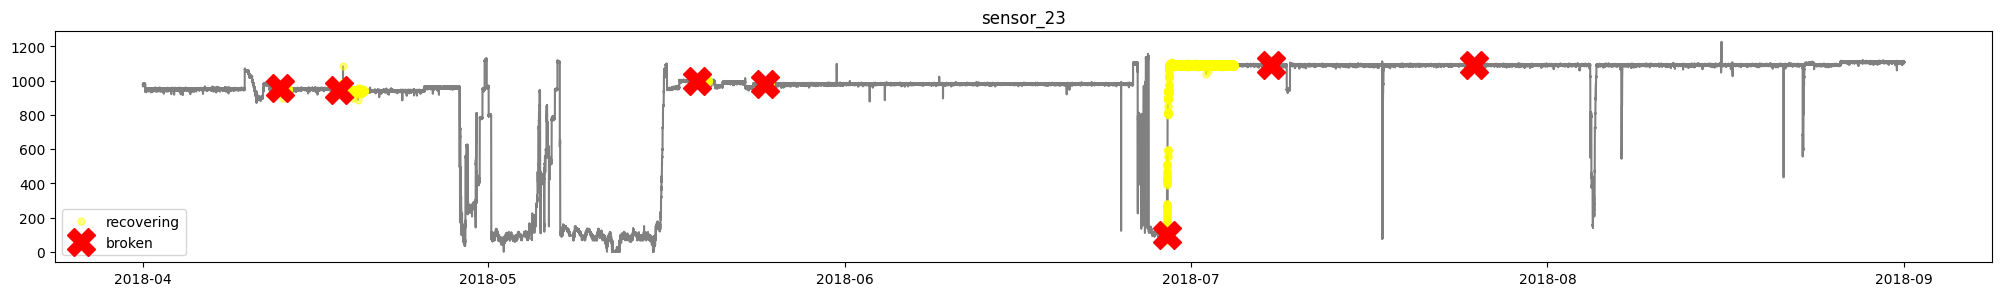

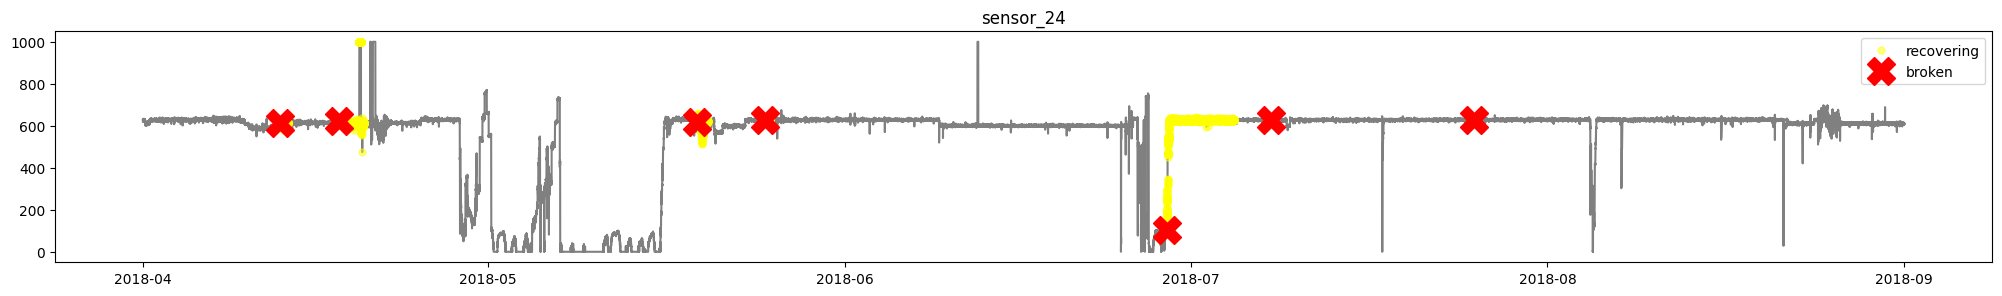

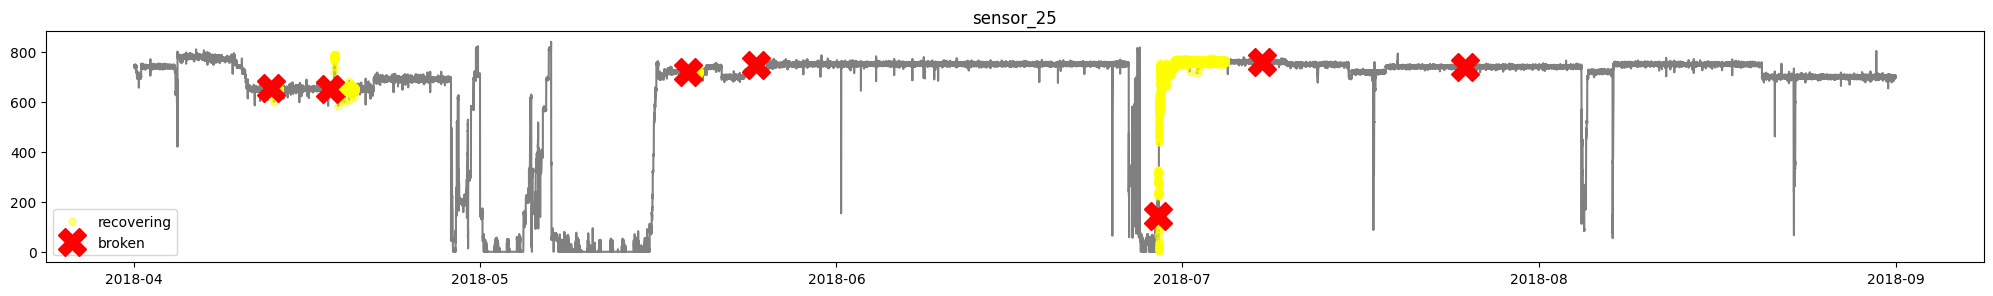

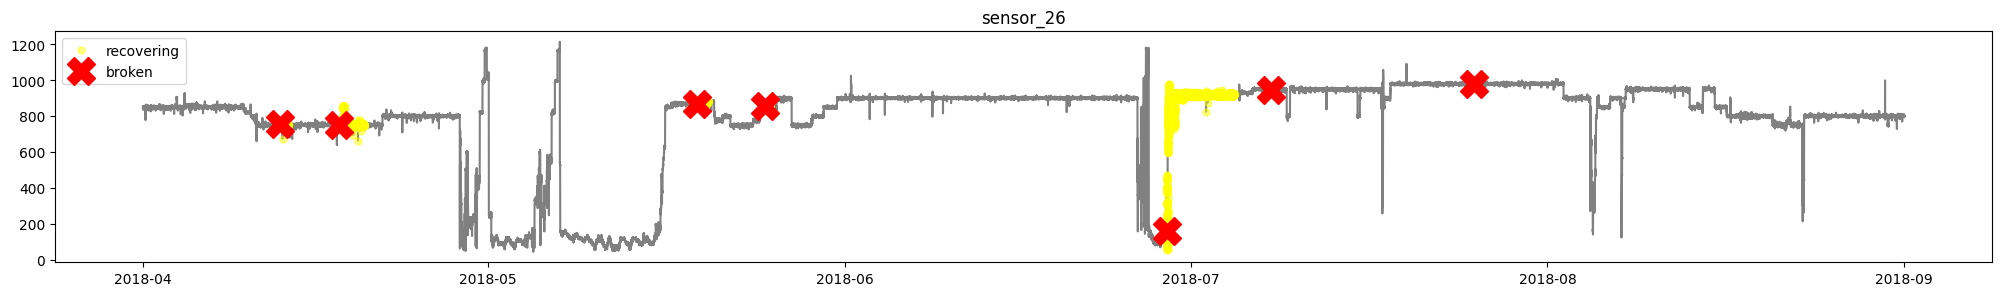

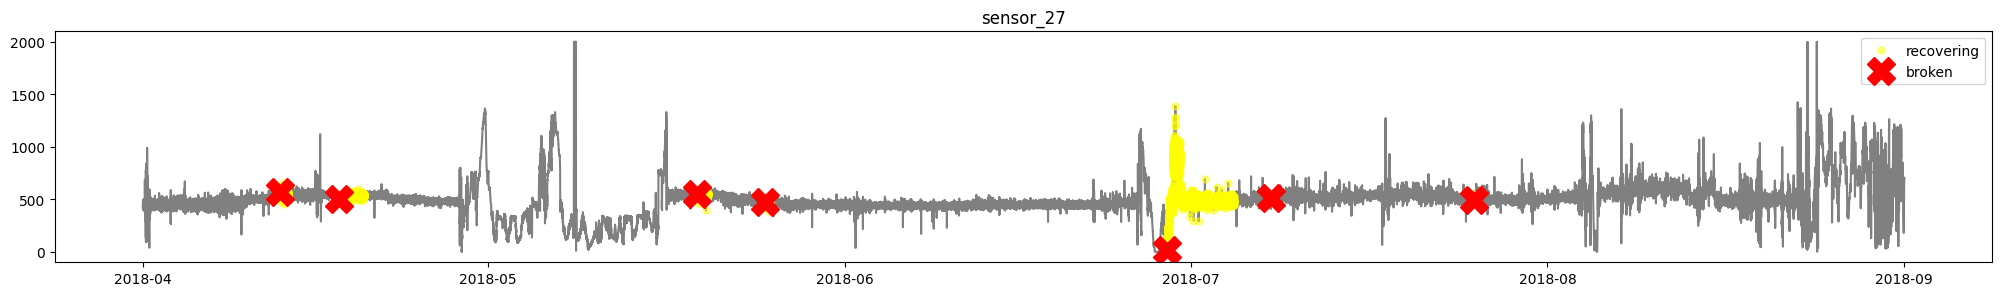

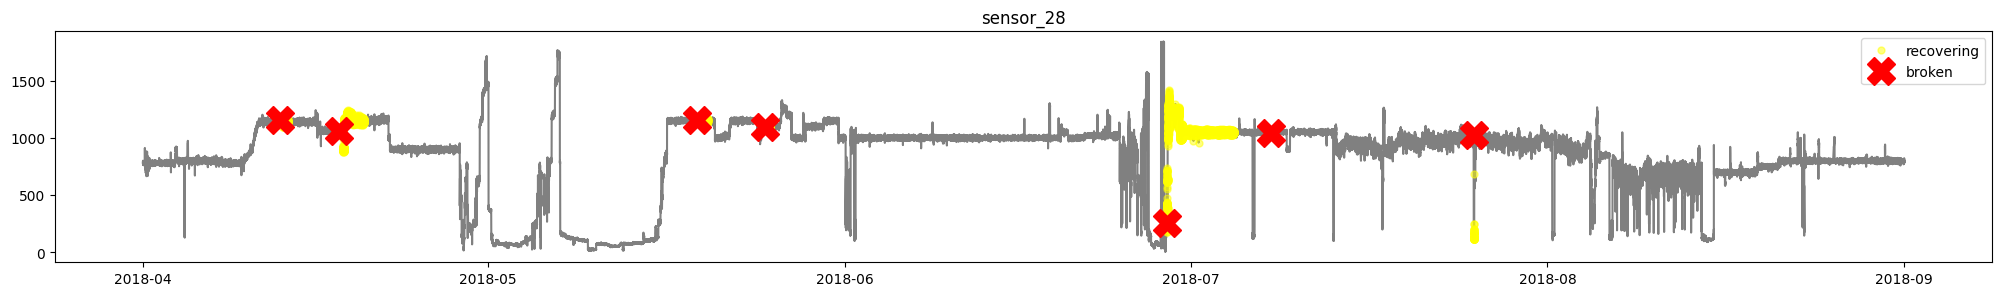

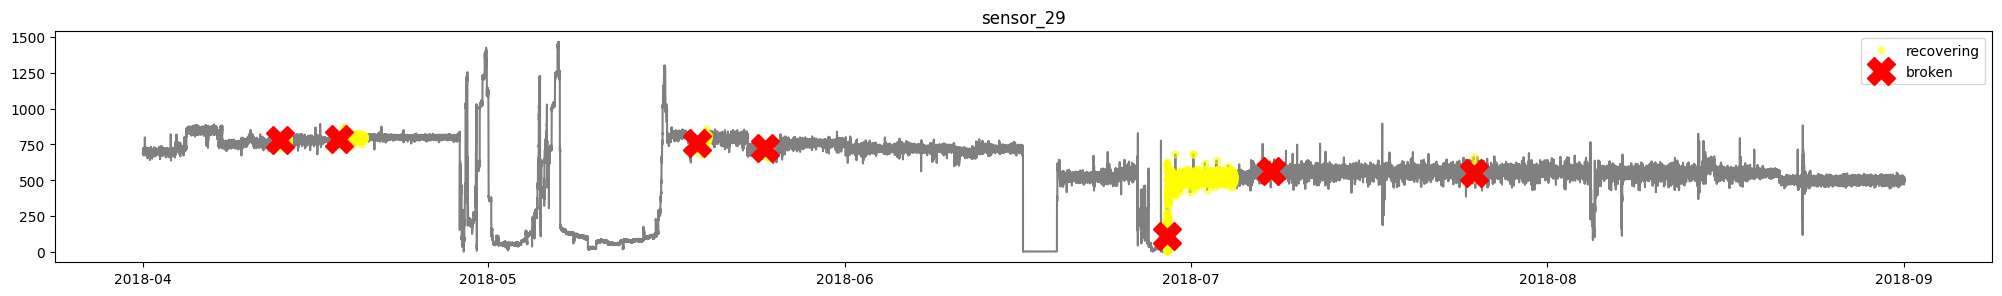

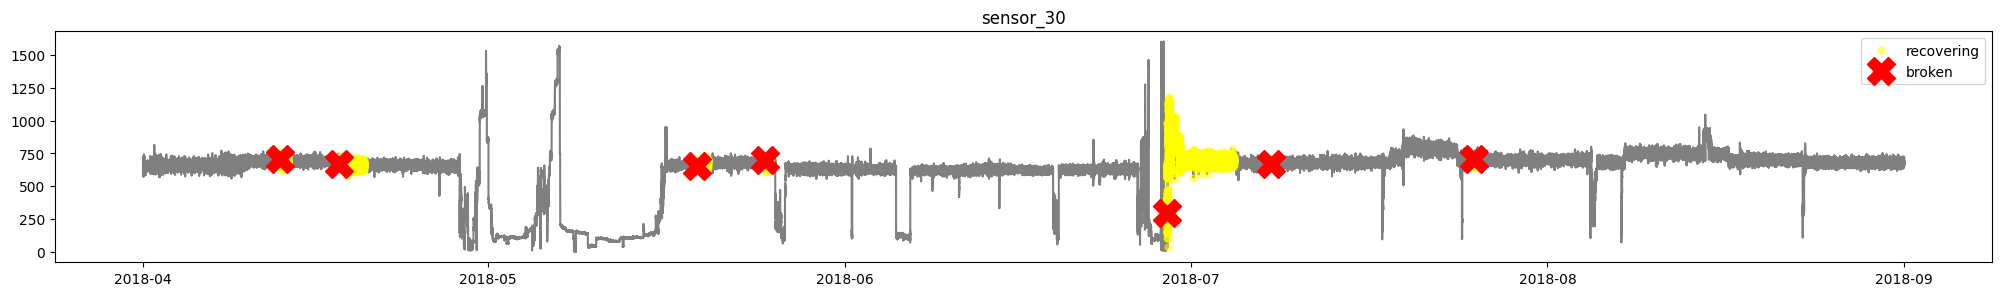

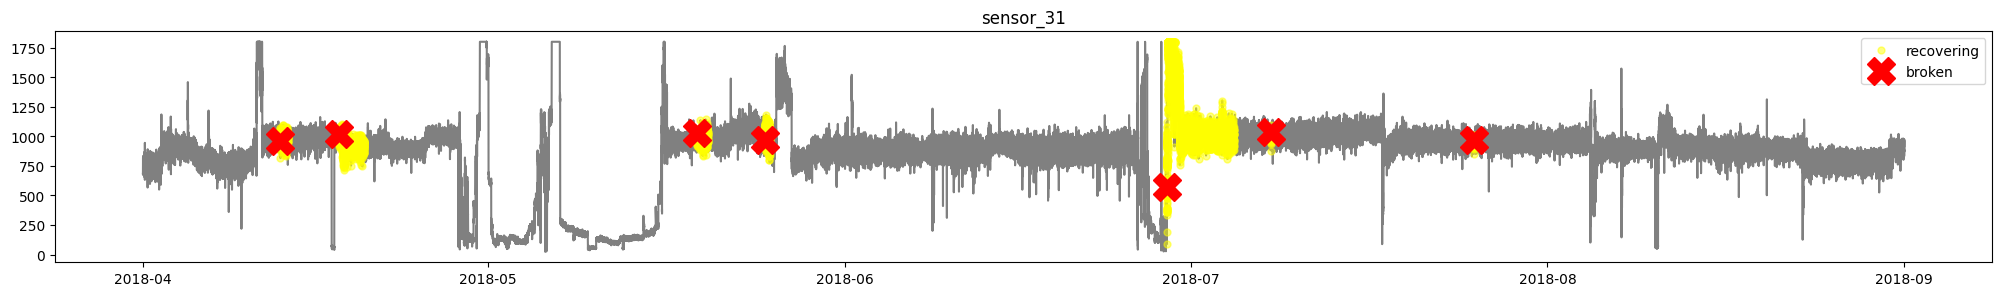

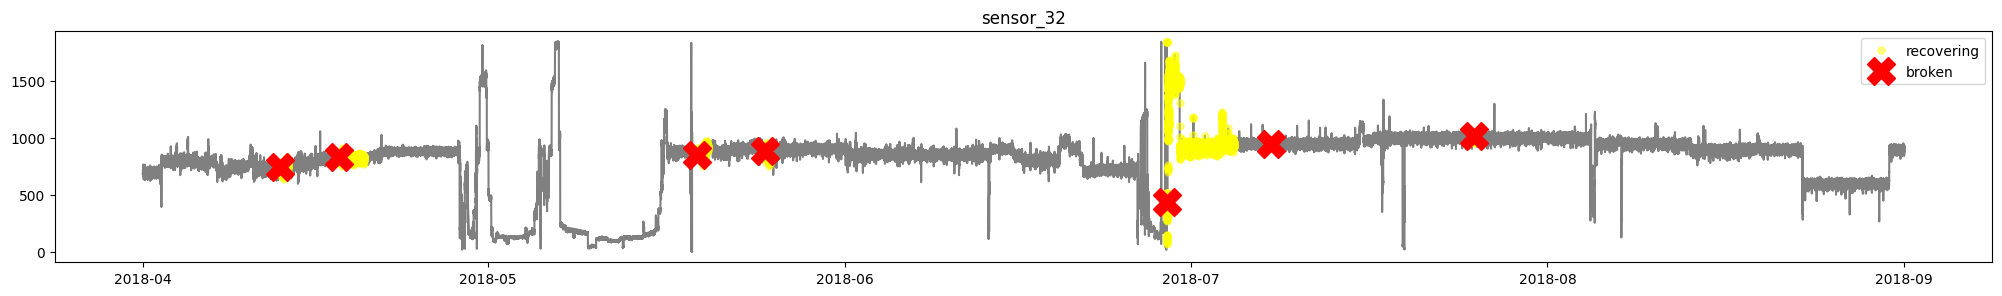

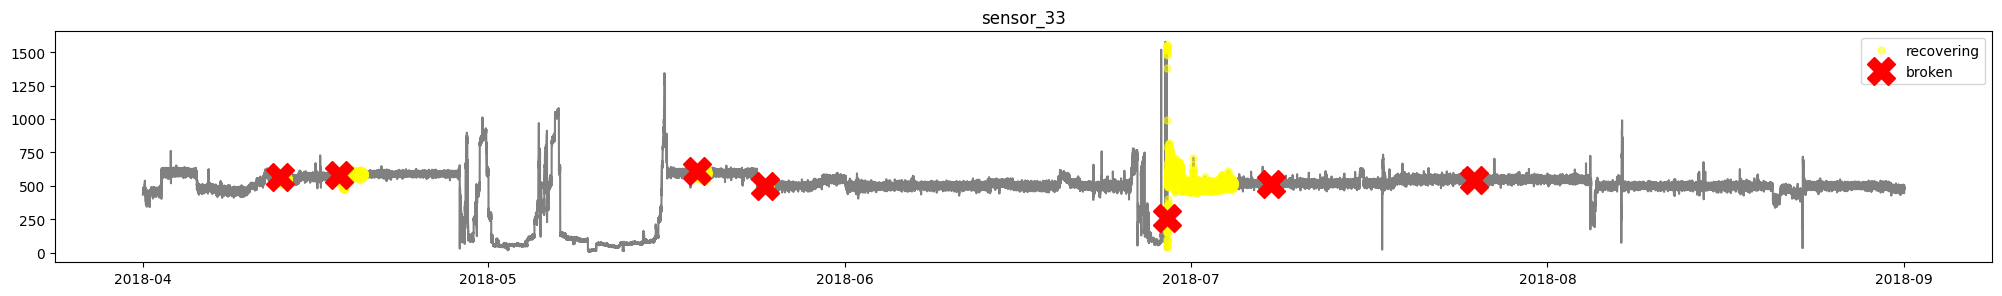

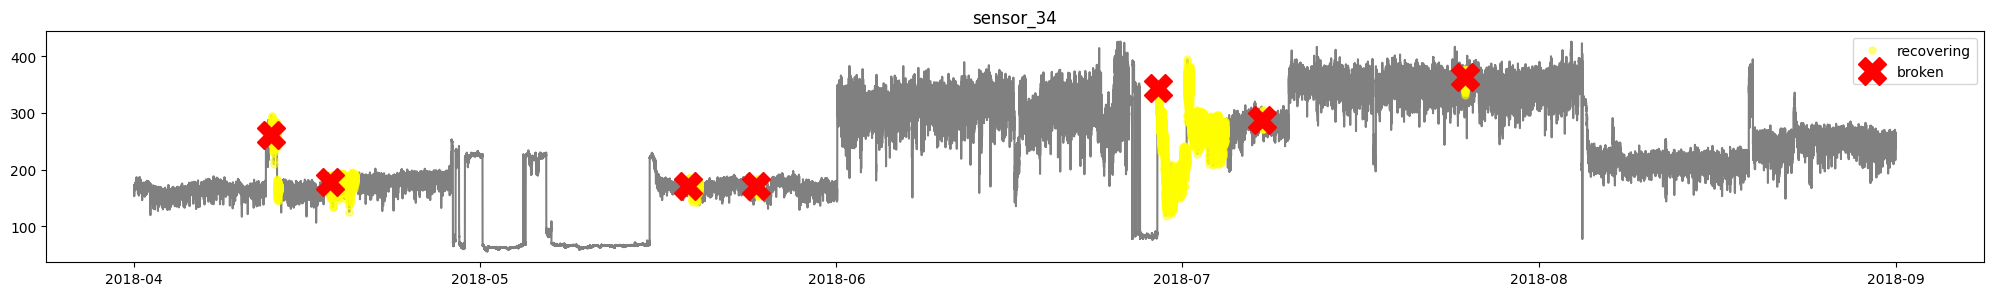

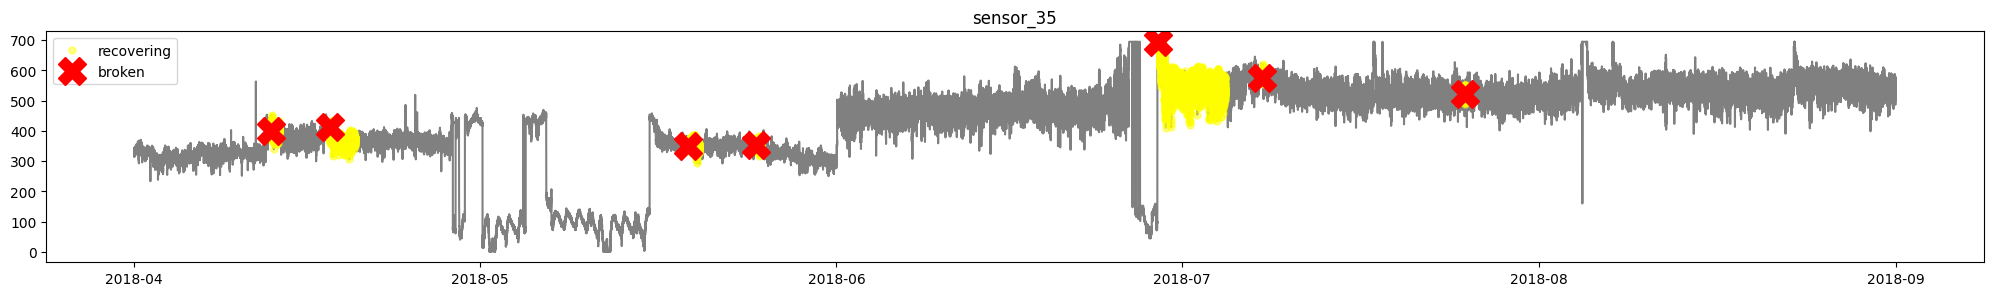

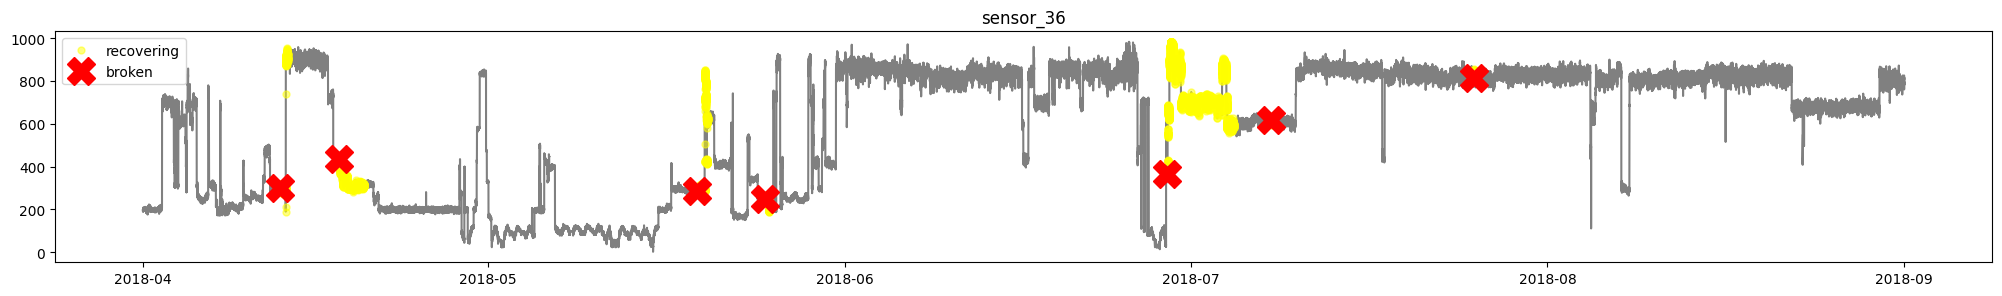

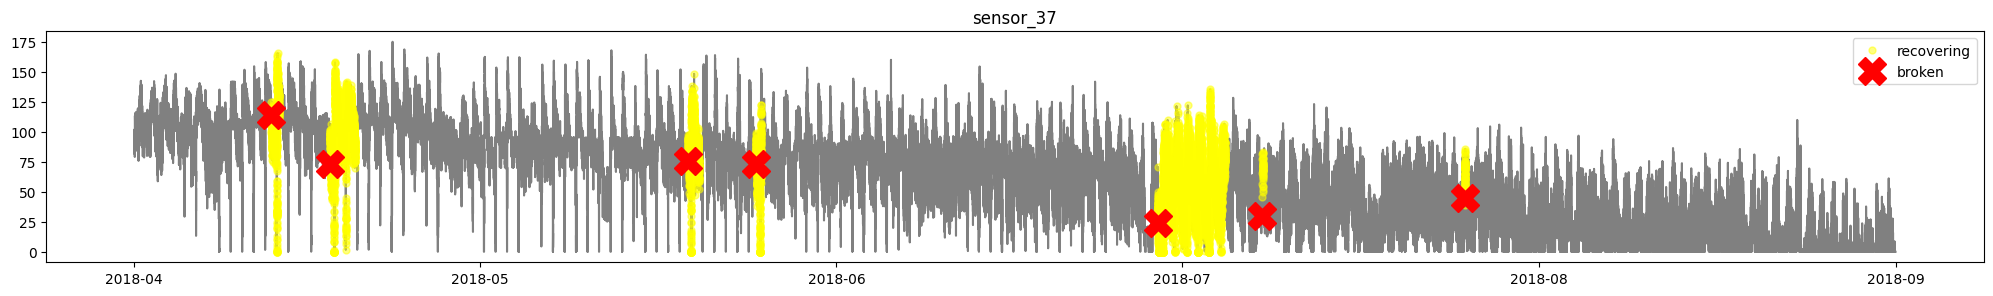

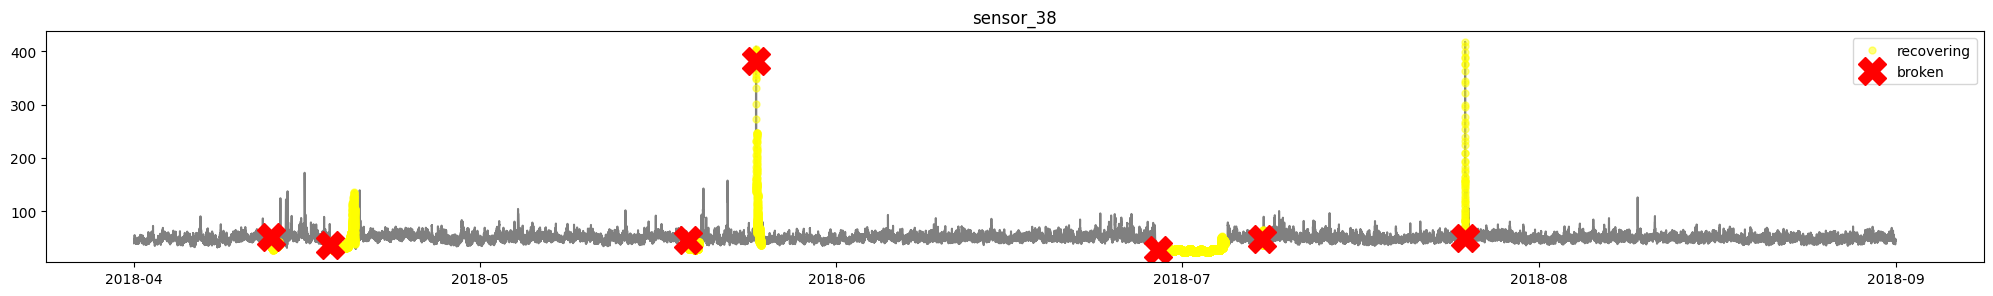

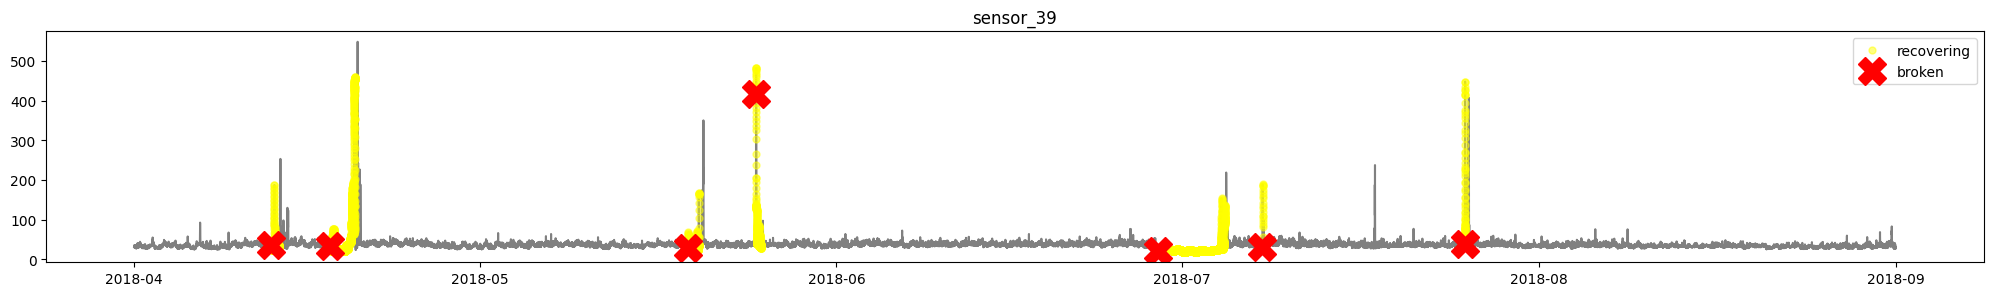

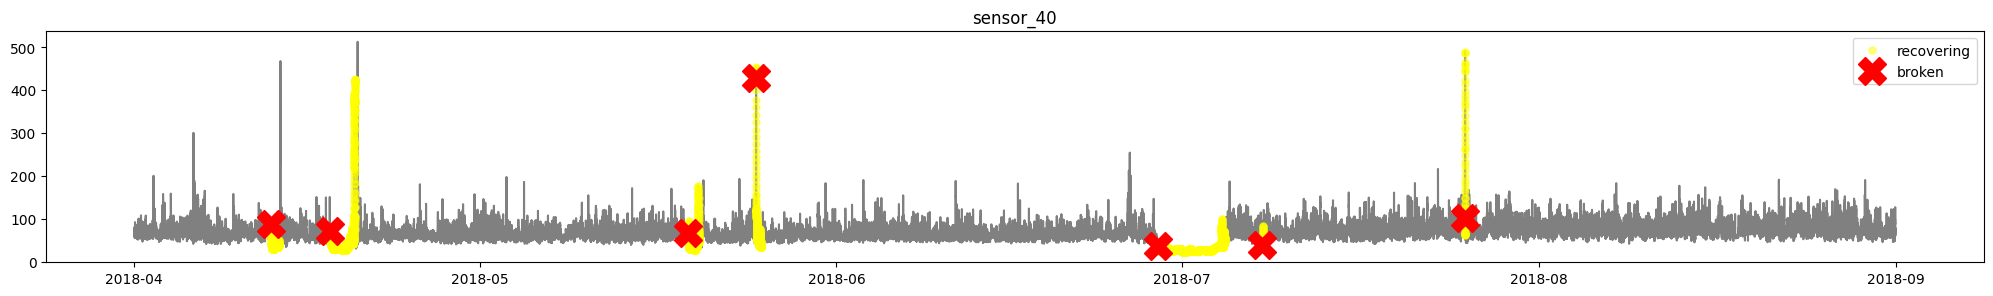

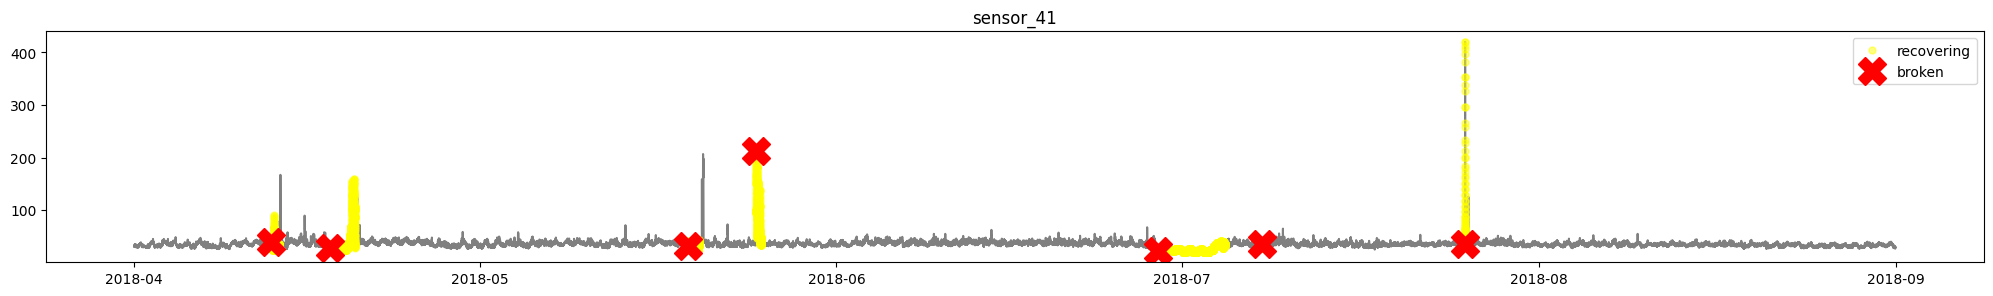

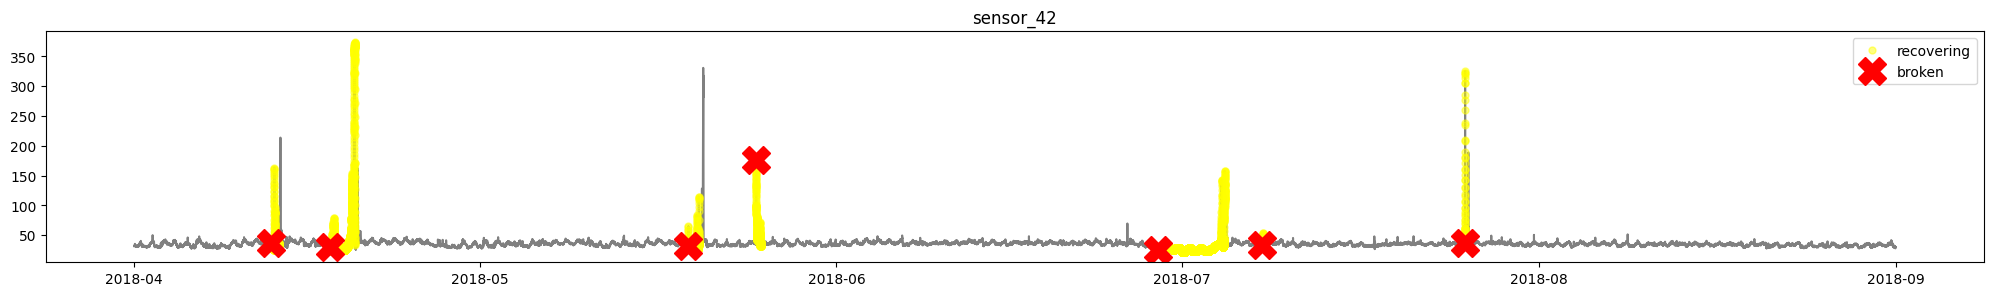

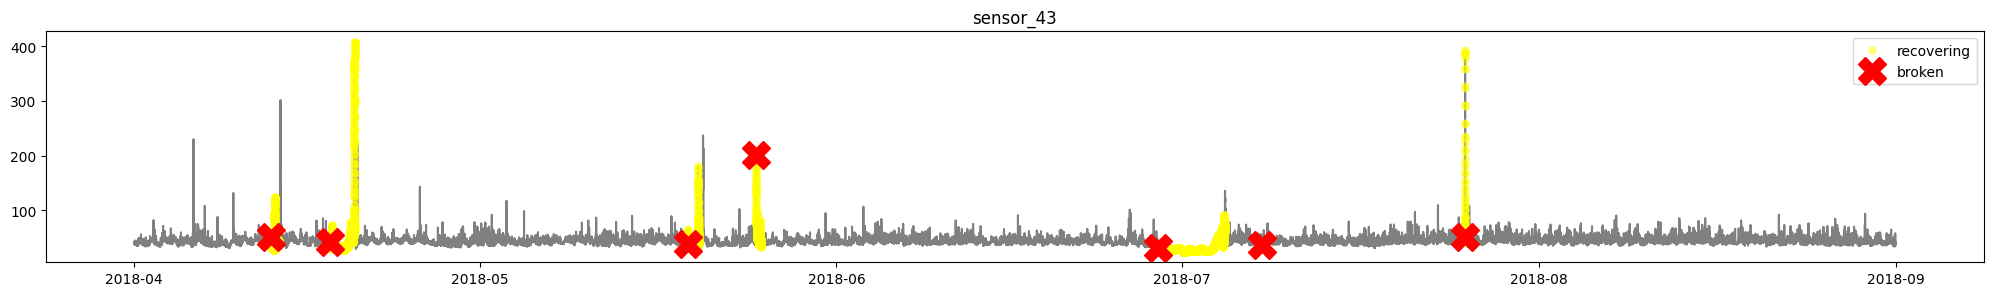

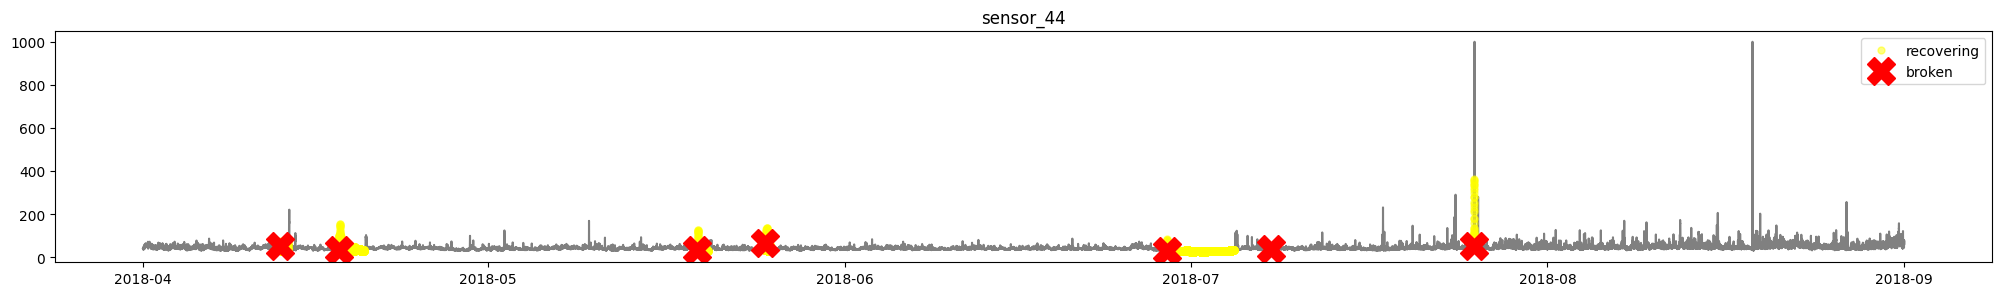

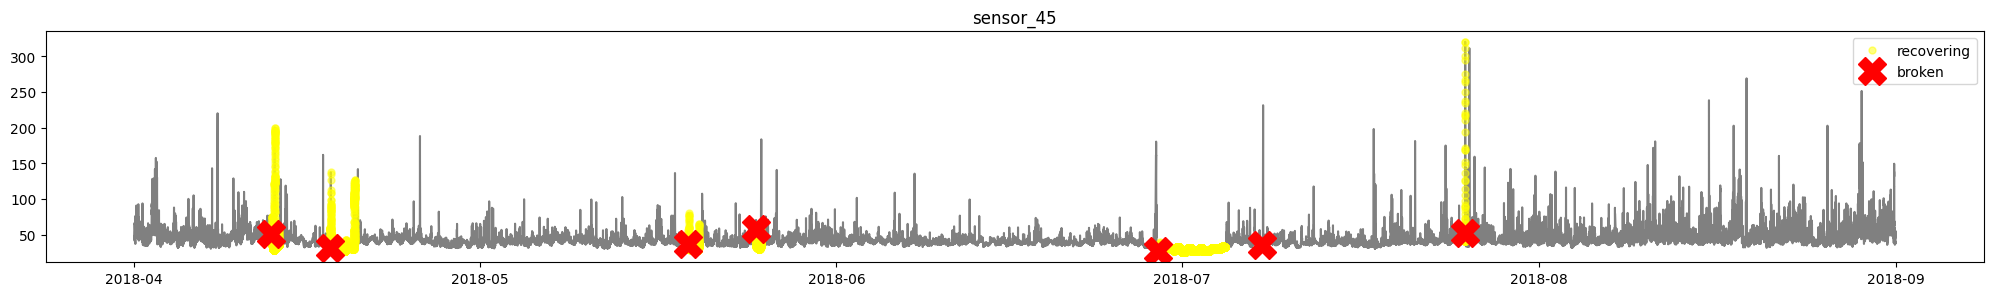

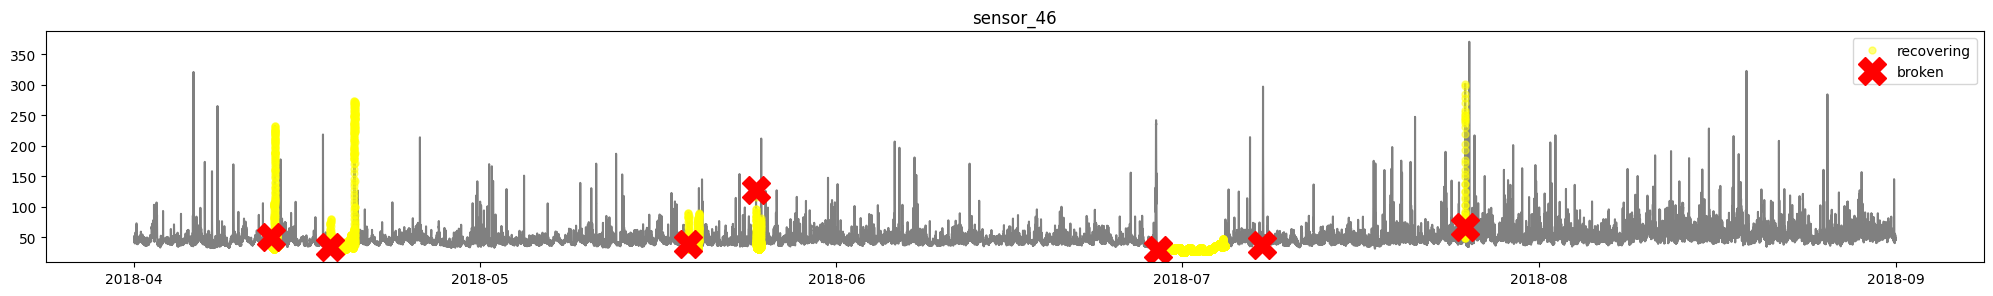

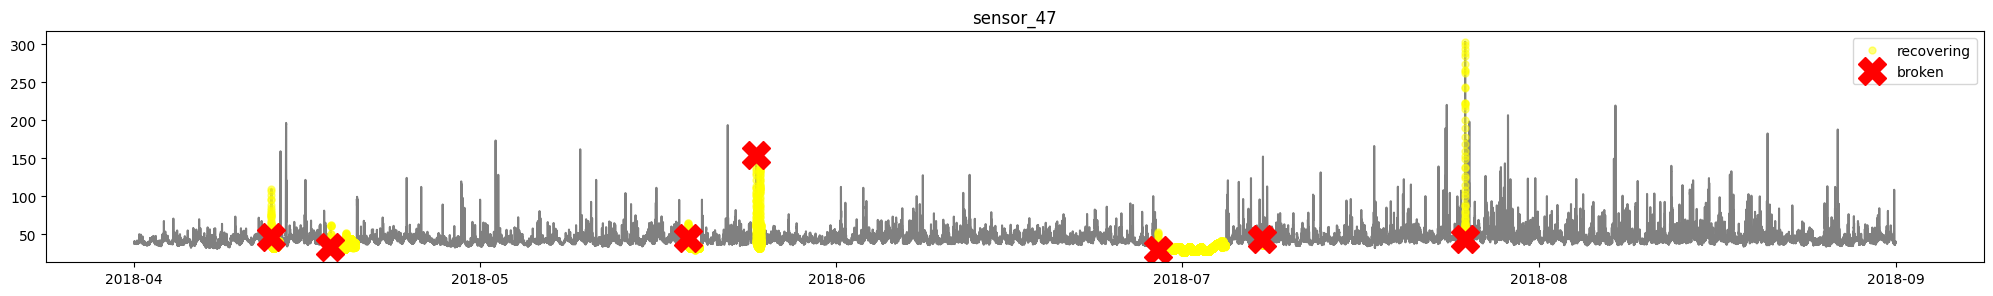

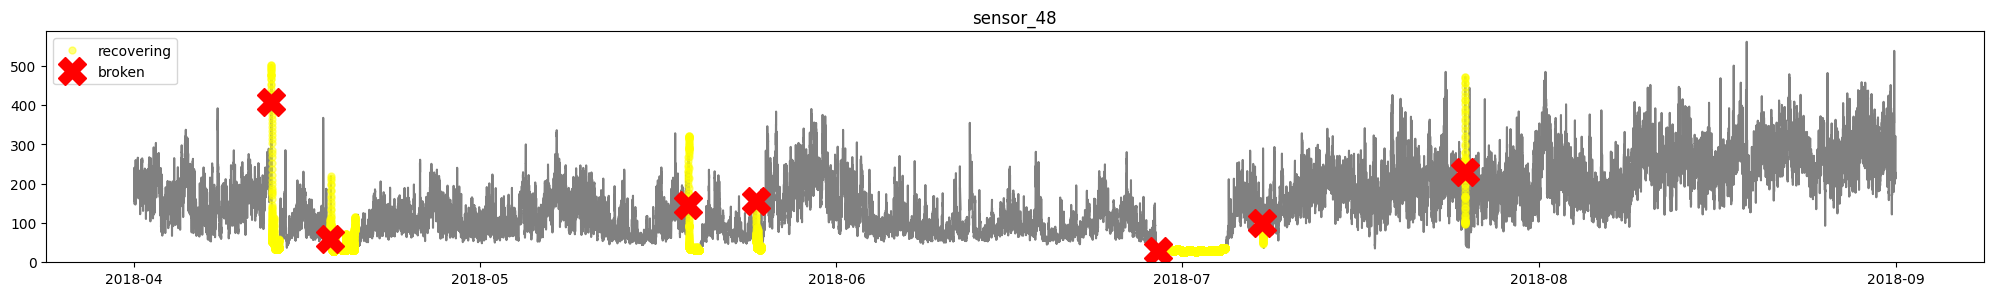

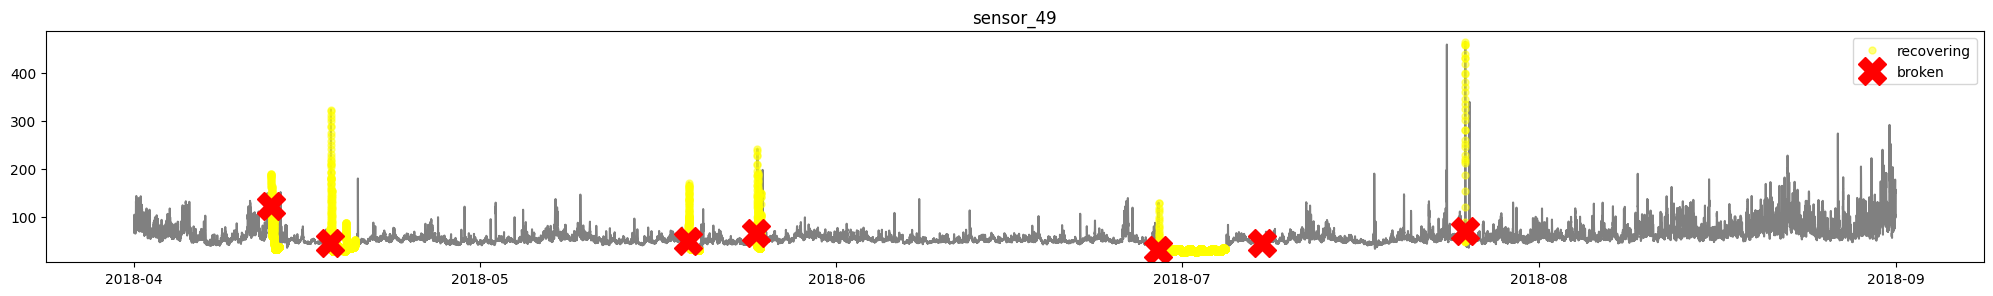

In [18]:
# implement the fillna and make the plot after that
corrected_df = df_imputer(df)
sensor_names = corrected_df.columns[:49]
plot_sensor_anomolies(corrected_df, sensor_names)

Afret this stage, one can use different methods to refine the dataset, and eliminate a portion of noises in it. the method used in the original study case notebook is standardizing; however, beside this technique one can use other techniques to improve the outcome of the Anomaly detection algorithms. Consequently, in the following part, first, similar to the original notebook, only standardizing will be implemented. Then, the mentioned technique will used beside outlier removal, resampling and aggregation, and smoothing techniques.The result of each section will be analyzed, and the best method among all will be determined. Finally, by using the best method, and utilizing feature engineering technique SelectKBest (get help from supervised machine-learning) the anomaly detection methods will be run and the outcome will be evaluated.

## 1- Using Standardizing
At the end, one can normalize or centralize the dataset :


In [19]:
# Standardizing the dataset
corrected_df.iloc[:,:49] = corrected_df.iloc[:,:49].apply(lambda x: (x - x.mean()) / x.std())

### Anomally Detection Algorithms
In this section, following the study_case_Anomaly_Detection.ipnyb, different Anomaly detection algorithms will be implemented and at the end the results will be compared with the results of this notebook.

In [20]:
def choosing_anomaly_method(df, methods_names):
    algorithm_list = []

    if type(methods_names) != list:
        methods_names = [methods_names]
        print(methods_names)

    normal_rows = df[df['machine_status']=='NORMAL']
    outliers_fraction = 1 - (len(normal_rows)/(len(df))) 

    anomaly_algorithms = {
        "Isolation Forest": IsolationForest(contamination=outliers_fraction, n_jobs = -1),
        "One-Class SVM": svm.OneClassSVM(nu=outliers_fraction),
        "Local Outlier Factor": LocalOutlierFactor(contamination=outliers_fraction, n_jobs = -1),
        "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
        "DBSCAN": DBSCAN(eps=1.8, min_samples=18)}


    
    for name in methods_names:
        print(name)
        algorithm_list.append((name, anomaly_algorithms[name]))
    
    return algorithm_list


In [21]:
def anomaly_detection_methods(df, methods_names):

    anomaly_algorithms = choosing_anomaly_method(df, methods_names)
    a, b = df.shape
    for name, algorithm in anomaly_algorithms:
        print(algorithm)

        if name == "Local Outlier Factor" or  name == "DBSCAN":
            y_pred = algorithm.fit_predict(df.iloc[:, :b-1])
            y_pred = np.where(y_pred!=-1,1,-1)
        else:
            y_pred = algorithm.fit(df.iloc[:, :b-1]).predict(df.iloc[:, :b-1])
        
        df[f'{name}'] = y_pred
        print('-'*100)
        print(f'number of anomolies detected')
        print(df[f'{name}'].value_counts())
        print('-'*100)

    return df


In [22]:
def anomaly_counter(df):

    # make a dataframe based on machine_status
    status_df = pd.DataFrame(df.groupby('machine_status'))

    # iterate through different statuse
    for number in range(len(status_df[0])):
        
        print(f'the predictions for {status_df.iloc[number, 0]}:')
        # choose each status dataframe
        assistant_df = status_df.iloc[number, 1]
    
        # choose the anomaly detection methods columns
        assistant_df = assistant_df.loc[:, 'machine_status':]
        assistant_df = assistant_df.drop('machine_status', axis=1)

        # count the amount
        unique_counts = assistant_df.apply(lambda x: x.value_counts()).T
        print(f'{unique_counts}\n')

In [44]:
corrected_df = anomaly_detection_methods(corrected_df, 
            ["Isolation Forest", "One-Class SVM", "Local Outlier Factor", "Robust covariance", "DBSCAN"])

IsolationForest(contamination=0.06574074074074077, n_jobs=-1)


c:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


----------------------------------------------------------------------------------------------------
number of anomolies detected
Isolation Forest
 1    205836
-1     14484
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
OneClassSVM(nu=0.06574074074074077)
----------------------------------------------------------------------------------------------------
number of anomolies detected
One-Class SVM
 1    205830
-1     14490
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
LocalOutlierFactor(contamination=0.06574074074074077, n_jobs=-1)
----------------------------------------------------------------------------------------------------
number of anomolies detected
Local Outlier Factor
 1    205836
-1     14484
Name: count, dtype: int64
---------------------------------------------------------------------------------------------------

Running this program takes about 50 to 60 minutes, so it is wise to save the outcome of these algorithms.

In [21]:
#save results
filename = 'D:\\Data Science for Life Science\\Machine Learning and Deep learning\\Machine_learning_assignments\\Unsupervised_Learning\\Third_Assignment\\outcome.csv'
corrected_df.to_csv(filename, index=False)

In [22]:
# for name, algorithm in anomaly_algorithms:
#    anomoly_rows = df_results[df_results[f'{name}'] == -1]
#    print(anomoly_rows[['machine_status', f'{name}']])
# df = pd.read_csv('outcome.csv')

Among the algorithms tested in the notebook, all except for One-Class SVM, successfully predicted the correct number of anomalies when considering the total number of anomalies as the sum of BROKEN and RECOVERING data points. Additionally, when considering the extra assumption made in the original notebook, which involved removing sensor-51 and utilizing downward filling technique, One-Class SVM only counted one additional anomaly, which is reasonable compared to the five extra anomalies detected by the original notebook.

### Analaytical Methods 
Moreover, it is also important to consider the number of correctly detected anomalies for each method as a measure of their validation. In other words, since each method can mistakenly classify a normal point as an anomaly, it is crucial to determine which method identifies the highest number of true anomalies accurately.

In [ ]:

anomaly_counter(corrected_df)

To begin with, none of the methods can accurately predict the number of anomalies of BROKEN category. The most successful estimations were achieved by One Class SVM (OCSVM) and Local Outlier Factor (LOF), correctly identifying four anomalies. Isolation Forest (IF) followed closely, correctly predicting two anomalies. However, the Robust Covariance (RC) method failed to predict any anomalies.

In terms of the RECOVERING category, IF predicted the highest number of anomalies, correctly identifying 5,344 out of 14,477 cases. OCSVM estimated slightly fewer anomalies, around 4,904 out of 14,477 (approximately 3% less). Conversely, the other two methods performed poorly in predicting anomaly points for this category.

The same trend persisted for the NORMAL category, with IF emerging as the top-performing method, accurately predicting 196,698 normal points out of 205,836. OCSVM claimed the second position but with less accuracy in separating normal data points. LOF and RC once again demonstrated weak performance in this category.

Overall, while all the methods could detect the total number of outliers, only IF and OCSVM managed to identify 36% of the true anomalies. LOF found approximately 15% of the true anomalies, while RC failed to detect even a single correct anomaly.

In conclusion, non of the methods could perform strongly to detect anomalies for this dataset, but the best results was made by IF and after it OCSVM.

In the next step, I will use machine status plots to find the probable reasons of the low quality of the results.

Using this plot, my first objective is to identify the disparities among the anomalies detected by each method. I will examine the spots identified by each method as anomalies and investigate the underlying factors contributing to the differences. Additionally, I will generate separate plots for the various sensor types and perform a comparative analysis between them.

The fourth sensor appears to exhibit minimal noise and distinct patterns during pump breaking incidents. Therefore, it can be considered a suitable candidate for comparing the performance of anomaly detection algorithms.

It is worth noting that the predicted anomaly spots remain consistent regardless of the sensor used. The only variation lies in the behavior of the sensor dataset itself. As a result, the choice of sensor does not significantly affect the identification of differences between the methods' performance, as they all pinpoint the same time spots across the entire dataset.

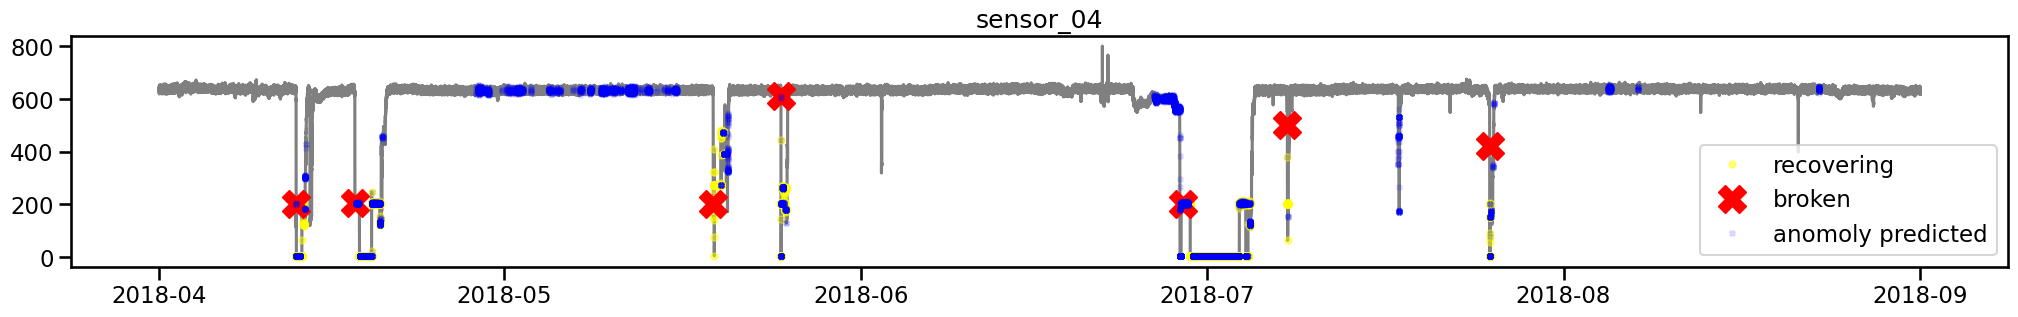

In [25]:
# plot Isolation Forest
plot_sensor_anomolies(corrected_df, 'sensor_04', 'Isolation Forest')

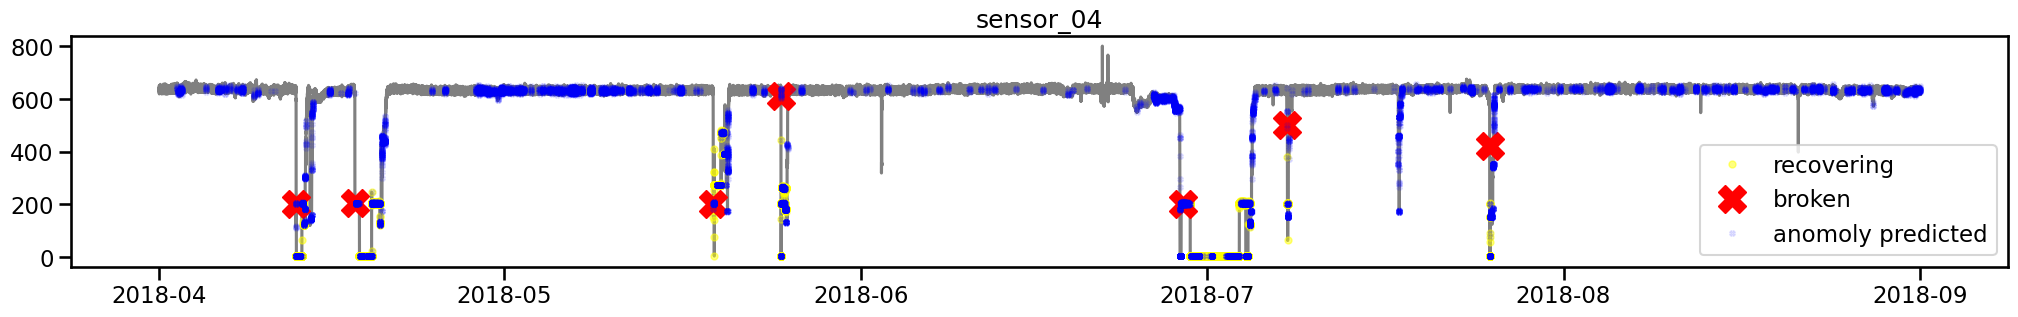

In [26]:
# plot One-Class SVM
plot_sensor_anomolies(corrected_df, 'sensor_04', 'One-Class SVM')

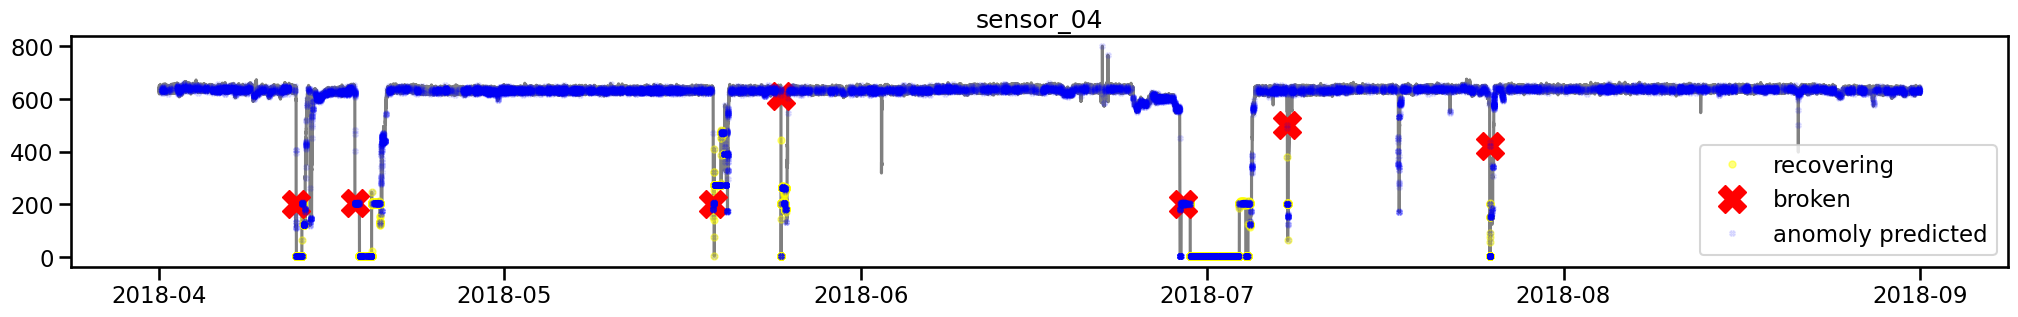

In [27]:
# plot Local Outlier Factor
plot_sensor_anomolies(corrected_df, 'sensor_04', 'Local Outlier Factor')

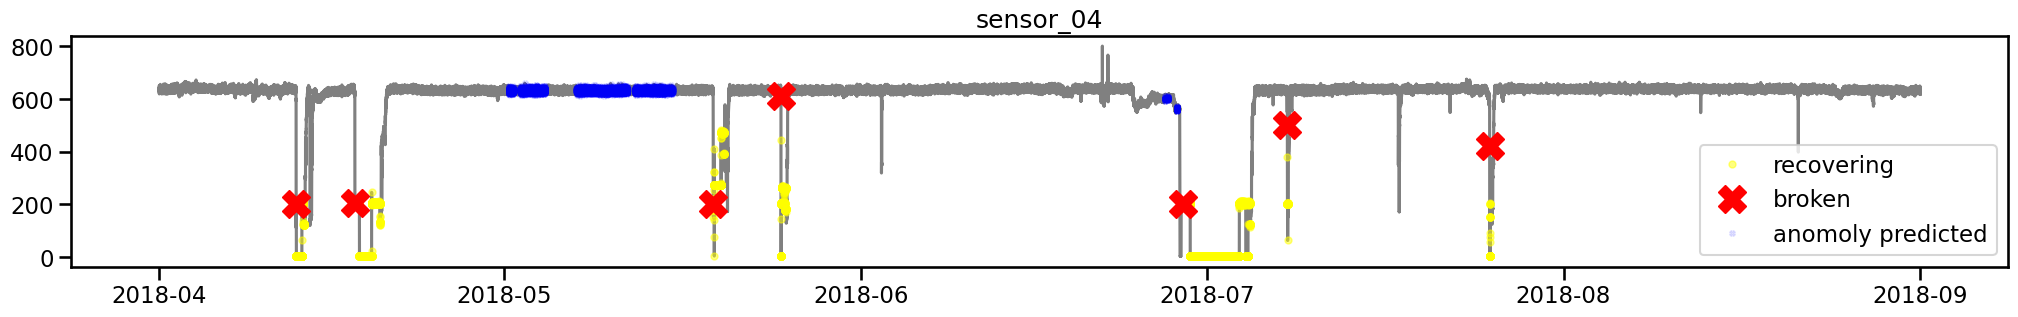

In [28]:
# plot Local Outlier Factor
plot_sensor_anomolies(corrected_df, 'sensor_04', 'Robust covariance')

Based on the plotted results, as expected, Isolation Forest (IF) demonstrates the best performance on this dataset by successfully detecting at least six anomaly spots. However, it falls short in two aspects. Firstly, it fails to detect the entire anomaly spots, only identifying certain points within the mentioned six spots, and it does not detect any points for the anomaly spot after 2018-07. Secondly, IF incorrectly identifies numerous normal data points as anomalies, particularly within the large normal spot around 2018-5.

Regarding One-Class Support Vector Machine (OCSVM), while it manages to detect some points within all seven anomaly spots, it also misclassifies a significant number of normal points as anomalies. The most concerning issue is that these misclassified points are distributed throughout the entire dataset, and OCSVM does not identify specific spots like IF does.

On the other hand, the Local Outlier Factor (LOF) method appears to detect points without any preference for being normal or anomaly throughout the dataset. In other words, LOF can identify some anomaly points within the anomaly spots, but it fails to distinguish between these spots and normal spots since the detected data points are evenly distributed throughout the dataset.

Finally, the Robust Covariance (RC) method proves to be ineffective in detecting any anomaly data points within the dataset, making it the least suitable method for this particular task.

The final part of this analysis involves comparing the machine status plots for different types of sensors and attempting to identify the reasons why none of the methods performed well on this dataset. 

In general, there are four distinct types of sensor plot patterns in this dataset. The first pattern belongs to sensors 0, 4 to 12. The second pattern belongs to sensors 14 to 36, while the third pattern is observed in sensors 38 to 49. Additionally, there is a fourth group characterized by irregular patterns, where each member has its own unique and noisy pattern. This group comprises five sensors: 1, 2, 3, 13, and 37.

Consequently, in this part, one representetive of each pattern will be sketched, and a comparison will be done bsed on their similarities and differences. The used anomaly detection method in this case if IF since it is the most informative one.

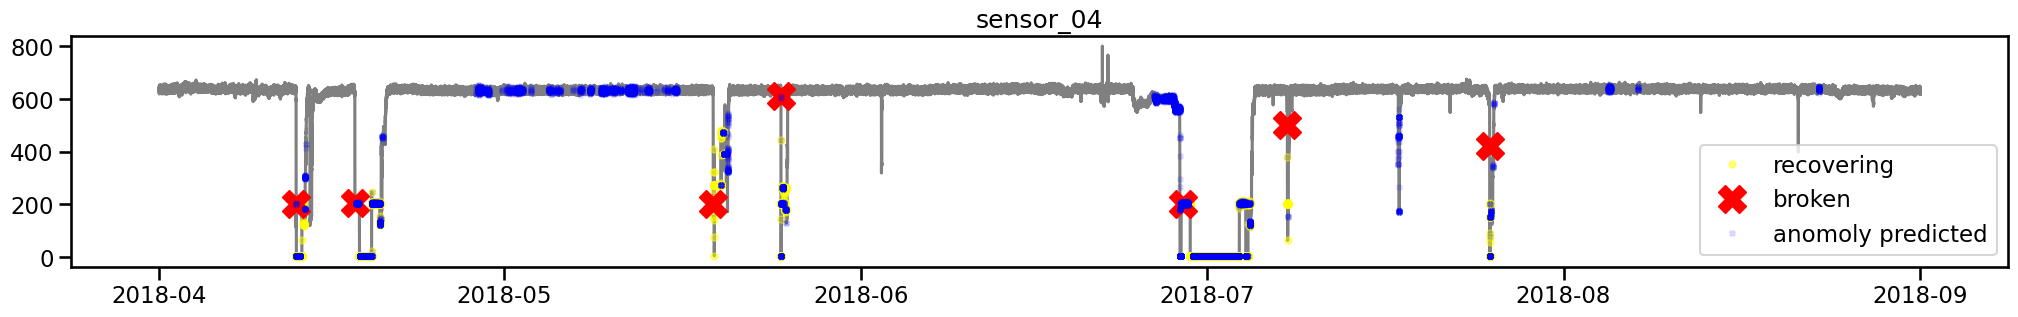

In [29]:
# plot Isolation Forest
plot_sensor_anomolies(corrected_df, 'sensor_04', 'Isolation Forest')

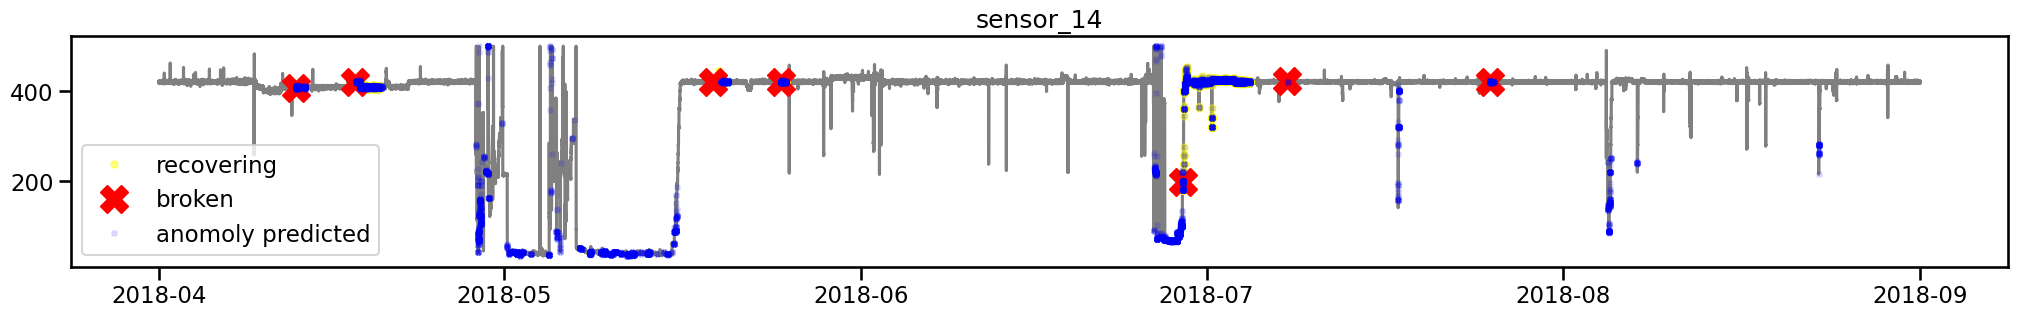

In [30]:
# plot Isolation Forest
plot_sensor_anomolies(corrected_df, 'sensor_14', 'Isolation Forest')

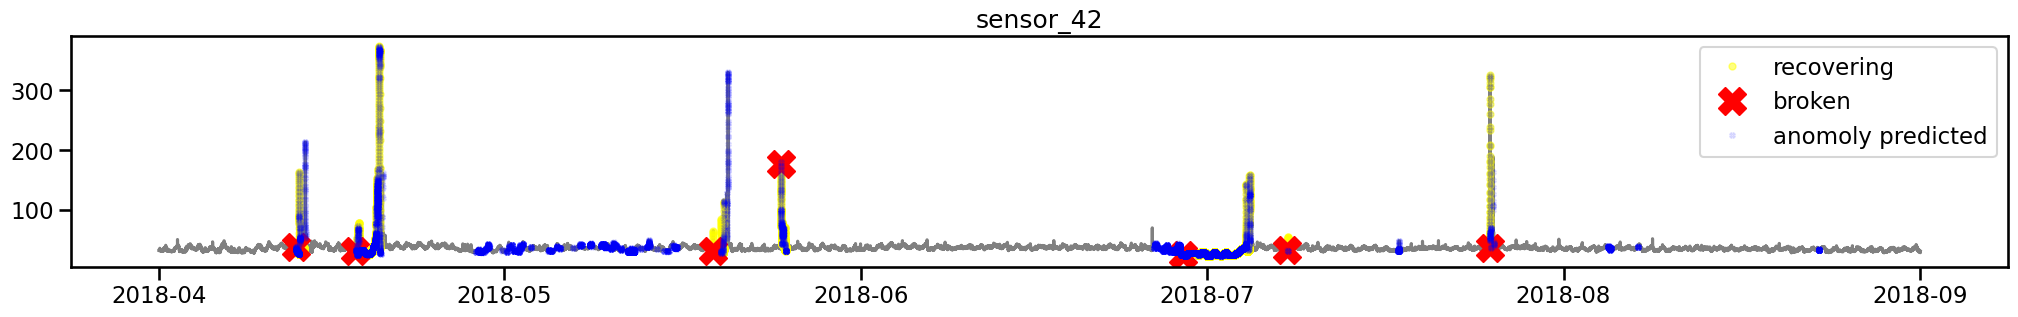

In [31]:
# plot Isolation Forest
plot_sensor_anomolies(corrected_df, 'sensor_42', 'Isolation Forest')

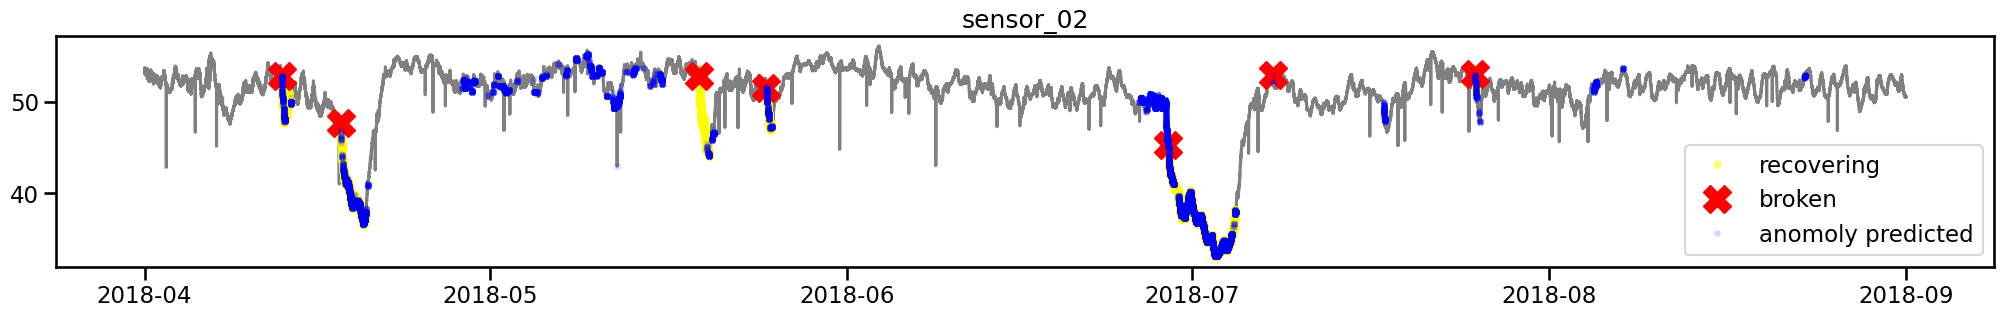

In [33]:
# plot Isolation Forest
plot_sensor_anomolies(corrected_df, 'sensor_02', 'Isolation Forest')

These patterns exhibit significant differences from one another, leading to varying impacts on the model during both training and testing phases. The first pattern demonstrates a constructive effect on accurately detecting anomalies, particularly during and after pump breakdown. This series of plots shows less abnormal behavior throughout this period.

The second pattern can be identified as the primary source of abnormalities in the methods' predictions. It contains numerous abnormal spots that do not correspond to pump breakdown or recovery, suggesting potential sensor malfunctions within this group.

Similar to the first group, the third pattern has a constructive impact on anomaly prediction. It exhibits normal behavior outside of the pump breakdown and recovery spots.

The last group can be characterized as the noisy group. While some plots within this group capture the general behavior of the pump during this period, they mostly contain noise, which contributes to prediction deficiencies.

Additionally, while the aforementioned plots exhibit lower noise levels, some of the other plots display a significant amount of noise, which can affect the performance of each anomaly detection method. This could explain why the Isolation Forest (IF) method outperforms the other methods. IF is generally less sensitive to outliers and noise compared to the other methods in this analysis.
 
Another significant concern within this dataset is the time period around 2018-05. By observing the plot of sensor14, it becomes evident that there is a significant cluster of outliers during this specific timeframe, which is not associated with any pump breakage or recovery events. The reason why this cluster stands out prominently in the dataset and is identified as an anomaly by the IF algorithm is due to the presence of this malfunction in 18 sensors, accounting for approximately 30% of all the sensors. As a consequence, the algorithm identifies this cluster as an anomaly. Additionally, there is another small cluster in the sensor 14-36 pattern in 2018-08, which also leads to the incorrect detection of an anomaly by the methods.

In conclusion, the best configuration for this dataset is by removing columns 1, 50, and 51, using backward filling imputing technique, and utilizing Isolation Forest as the anomaly detection technique. However, this can be correct if one wants to limit hiself to this platform without using any data refining techniques and extra analytical techniques after implementing the model. Consequently, to continue this assignment first some data refining techniques will implement  to decreas the amount of noises and unwanted abnormal behaviour, and then implement the mentioned technique again to compare the differences between the outcome of these methods.  

## 2- Outlier Removal:
One way to enhance the quality of the dataset is by utilizing the z-score technique, which has been previously implemented in this notebook. However, a technique that hasn't been employed is cropping the dataset based on the distance of data points to the z-score. Additionally, there are other outlier removal techniques based on various statistical methods, such as the MAD (Median Absolute Deviation) z-score, Interquartile Range (IQR) Method, and Percentile Method. These techniques can be utilized to remove outliers while preserving anomalies. However, for this specific dataset, I believe that this category of techniques may not be particularly useful. The reason is that the magnitude of the outliers or noise is of the same order as the anomaly datapoints, or sometimes even less than the anomaly datapoints. Consequently, if one attempts to crop the outliers using any of the mentioned techniques, there is a risk of removing a significant number of anomaly datapoints. This would result in the loss of most of the dataset's anomalies, weakening the effectiveness of anomaly detection techniques for this dataset. Nevertheless, I will implement one of the mentioned techniques (specifically, I will use the z-score outlier removal technique) and evaluate my hypothesis regarding its effectiveness.


In [215]:
# fill the nan values using backward imputation technique
corrected_df = df_imputer(df)

In [216]:
corrected_df.head()

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
timestamp                                                                    
2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   638.8889   
2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   628.1250   
2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   636.4583   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
timestamp                                                                    
2018-04-01 00:00:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:01:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:02:00   73.54598   13.32465   16.03733   15.61777   15.01013   
2018-04-01 00:03:00   76.98898   13.31742   16.24711   15.69734   15.08247   
2018-04-01 00:04:00   76.58897   13.35359   16.21094   15.69734   15.08247   

                     ...  sensor_41  sensor_42  sensor_43  sensor_44  \
timestamp            ...                                               
2018-04-01 00:00:00  ...   30.98958  31.770832   41.92708  39.641200   
2018-04-01 00:01:00  ...   30.98958  31.770832   41.92708  39.641200   
2018-04-01 00:02:00  ...   30.46875  31.770830   41.66666  39.351852   
2018-04-01 00:03:00  ...   30.46875  31.510420   40.88541  39.062500   
2018-04-01 00:04:00  ...   30.98958  31.510420   41.40625  38.773150   

                     sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
timestamp                                                                    
2018-04-01 00:00:00   65.68287   50.92593  38.194440   157.9861   67.70834   
2018-04-01 00:01:00   65.68287   50.92593  38.194440   157.9861   67.70834   
2018-04-01 00:02:00   65.39352   51.21528  38.194443   155.9606   67.12963   
2018-04-01 00:03:00   64.81481   51.21528  38.194440   155.9606   66.84028   
2018-04-01 00:04:00   65.10416   51.79398  38.773150   158.2755   66.55093   

                     machine_status  
timestamp                            
2018-04-01 00:00:00          NORMAL  
2018-04-01 00:01:00          NORMAL  
2018-04-01 00:02:00          NORMAL  
2018-04-01 00:03:00          NORMAL  
2018-04-01 00:04:00          NORMAL  

[5 rows x 50 columns]

In [197]:
def z_score(df, threshold):
    # Calculate z-score for the dataset
    zscore_df = df.apply(lambda x: np.abs((x - x.mean()) / x.std()))
    return df[zscore_df <= threshold], df[zscore_df >= threshold]

def mad_zscore(df, threshold):
    # Calculate the Median Absolute Deviation (MAD)
    median_val = np.median(df)
    abs_dev = np.abs(df - median_val)
    mad = np.median(abs_dev)

    # Calculate the Modified Z-Score for each data point
    diff_from_median = df - median_val
    mad_df = 0.6745 * diff_from_median / mad

    return df[mad_df <= threshold], df[mad_df >= threshold]  

def interquartile(df, threshold):
    # Calculate the first quartile (Q1) and third quartile (Q3)
    q1 = np.percentile(df, 25)
    q3 = np.percentile(df, 75)
        
    # Calculate the interquartile range (IQR)
    iqr = q3 - q1
        
    # Define the lower and upper bounds for outliers
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
        
    # Return the dataset without outliers
    return df[(df >= lower_bound) & (df <= upper_bound)], df[(df <= lower_bound) & (df >= upper_bound)]   

In [203]:
def outlier_removal(df, name, threshold, interpolate=True, outlier=False, standardization=False):
    float_df = df.iloc[:,:49]

    # implement z-score
    if name == 'z-score':
        
        main_df, outlier_df = z_score(float_df, threshold)
    
    # implement MAD z-score
    elif name == 'MAD':
        main_df, outlier_df = mad_zscore(float_df, threshold)

    # implement Intequartile Range
    elif name == 'Interquartile':
        main_df, outlier_df = interquartile(float_df, threshold)

    # if outlier dataframe is needed return it
    if outlier == True:
        df.iloc[:,:49] = outlier_df
        return df

    # return the main datafram
    float_df = main_df

    # interpolate or fill the Nan values
    if interpolate == True:
        float_df = float_df.interpolate(method='linear')
    else:
         float_df = float_df.fillna(float_df.mean())

    # Standardize the dataset
    if standardization == True:
        df.iloc[:,:49] = float_df.apply(lambda x: np.abs((x - x.mean()) / x.std()))
    else:
        df.iloc[:,:49] = float_df
    return df

In the following steps, first, the outlier data frame will be sketch to evaluate how much noise or how many anomaly datapoints is lost during the outlier removal process, then the refined dataframe will be sketched, and the anomaly detection technique will be used. 

In [139]:
outlier_df = outlier_removal(corrected_df, name='z-score', threshold=2,
                              interpolate=False, outlier=True, standardization=False)


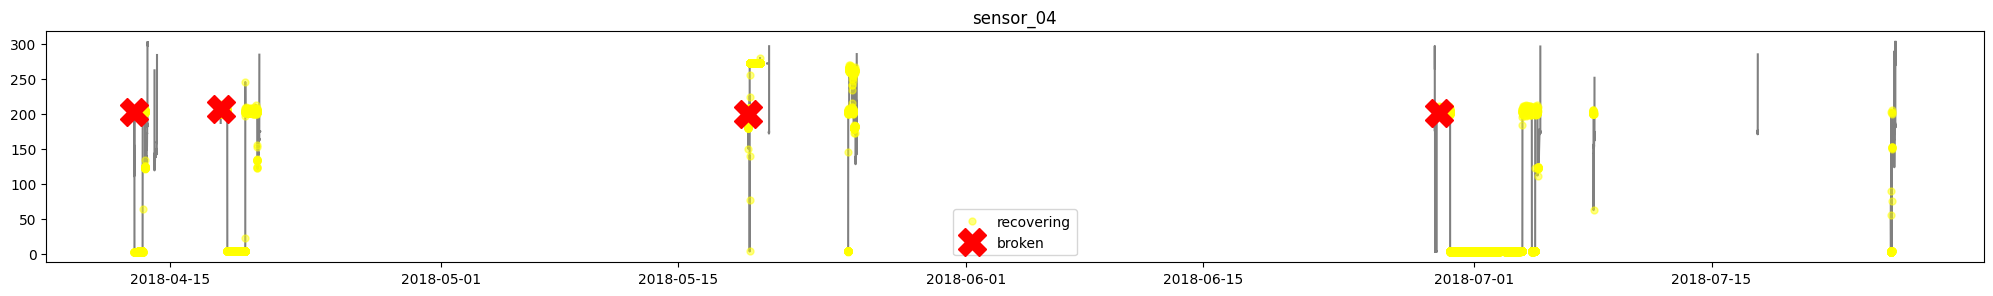

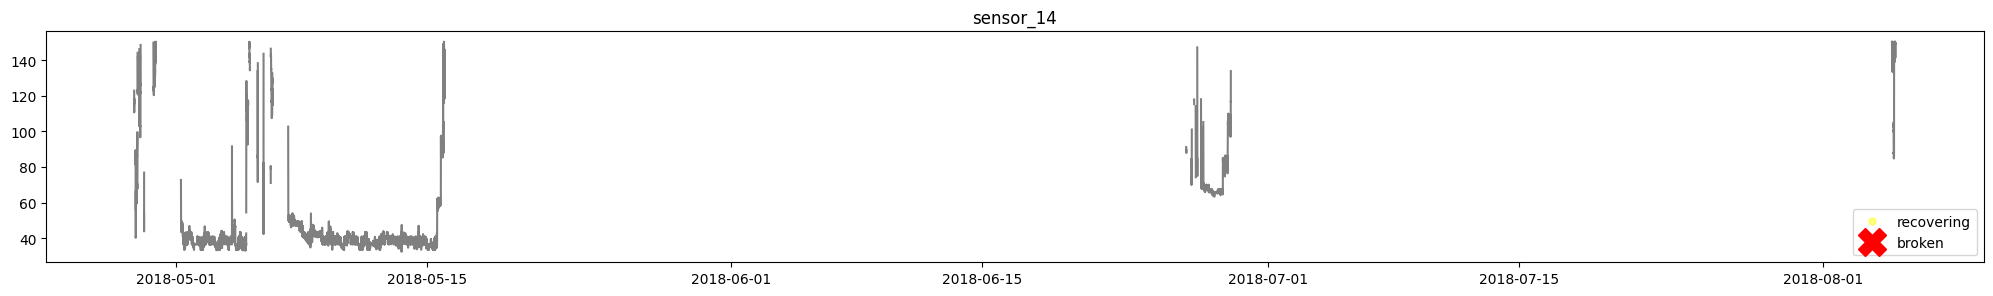

In [140]:
# plot two representative sensors
plot_sensor_anomolies(outlier_df, ['sensor_04'])
plot_sensor_anomolies(outlier_df, ['sensor_14'])

As a representator of the whole dataset, sensor-12 and sensor 14 are sketched here, and rest of the plots roughly obey these two patterns. In other words, in some of them many anomalu datapoints are removed, while in others noises are lost. Consequently, an adequate amount of noise is removed from the dataset; however, a noticable amount of anomaly data is lost as well. This data loss may affect the outcome of the anomaly detection technique. To continue one can calculate the amount of anomaly data loss using the following function.

In [141]:
def finding_not_null_amount(df):

    # loop over all categories
    for status in df.machine_status.unique():
        temporary_df = df[df.machine_status == status]

        # sum over all the non-null values
        value_number = temporary_df.iloc[:,:49].notnull().sum().sum()
        a, b= temporary_df.iloc[:,:49].shape

        # find the percentage of nan-null values
        value_percent = value_number / (a * b)
        print(f'{status} category:\n numebr of values is {value_number}\n percentage regarding whole category:{value_percent.round(3)}\n')

In [142]:
finding_not_null_amount(outlier_df)

NORMAL category:
 numebr of values is 530396
 percentage regarding whole category:0.053

BROKEN category:
 numebr of values is 42
 percentage regarding whole category:0.122

RECOVERING category:
 numebr of values is 164761
 percentage regarding whole category:0.232



Approximately five percent of the normal data is identified as outliers by the algorithm, which is reasonable and beneficial considering these data points can be regarded as noise. However, a drawback of this method is that it also results in a loss of around 23 percent of recovering points and 12 percent of broken points. This loss could significantly impact the anomaly detection process. Moving forward, I will apply linear interpolation to the refined dataset and assess its impact on the Isolation Forest method. The reason for selecting the Isolation Forest technique for the remaining part of this study is twofold. Firstly, it offers faster processing compared to other techniques. Secondly, it is the most accurate technique for this study case as other unsupervised methods are highly sensitive to the presence of noise.

In [157]:
refined_df = outlier_removal(corrected_df, name='z-score', threshold=2, 
                               interpolate=True, outlier=False, standardization=False)

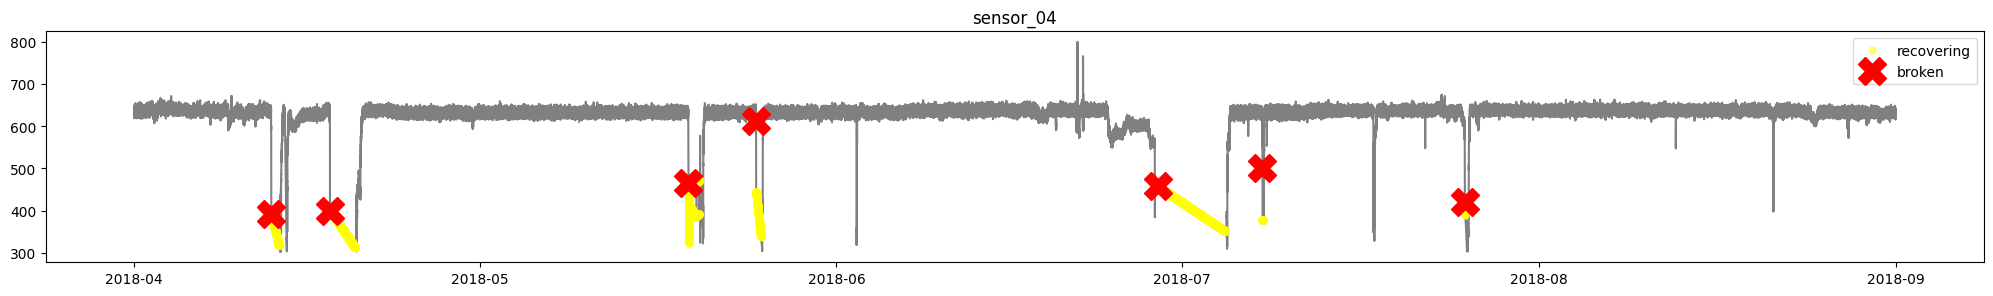

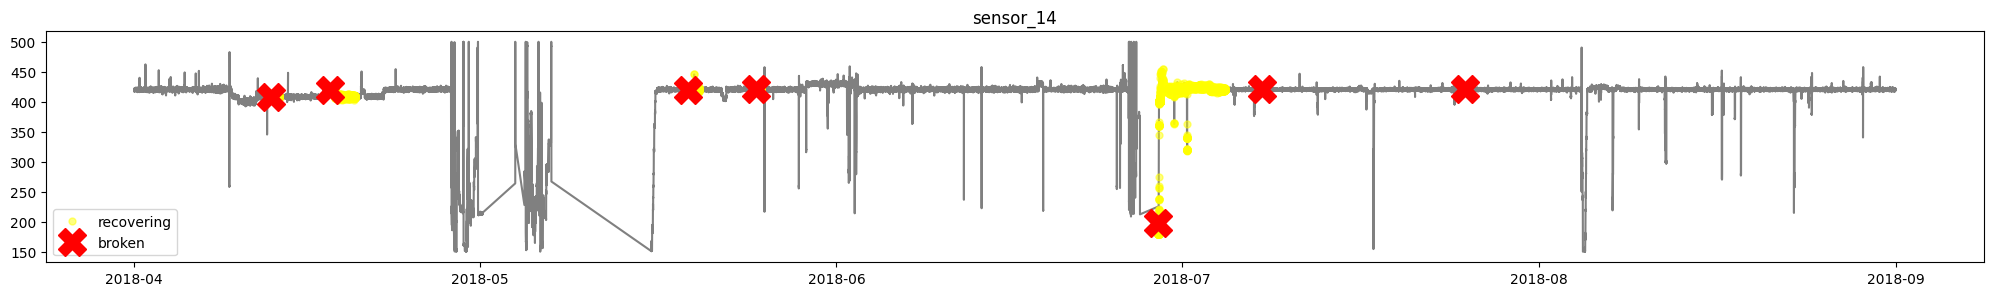

In [158]:
# plot two representative sensors
plot_sensor_anomolies(corrected_df, ['sensor_04'])
plot_sensor_anomolies(corrected_df, ['sensor_14'])

As observed, applying linear interpolation to the removed noises and anomaly points results in their reconstruction, which does not lead to any improvement and can potentially worsen the situation.

In [175]:
# use linear interpolation
interpolate_df = outlier_removal(corrected_df, name='z-score', threshold=2, 
                               interpolate=True, outlier=False, standardization=True)

In [177]:
interpolate_df = anomaly_detection_methods(interpolate_df, ["Isolation Forest"])

Isolation Forest
IsolationForest(contamination=0.06574074074074077, n_jobs=-1)


c:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


----------------------------------------------------------------------------------------------------
number of anomolies detected
Isolation Forest
 1    205836
-1     14484
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


In [178]:
anomaly_counter(interpolate_df)

the predictions for BROKEN:
Isolation Forest   1  -1
Isolation Forest   6   1

the predictions for NORMAL:
Isolation Forest       1     -1
Isolation Forest  195485  10351

the predictions for RECOVERING:
Isolation Forest      1    -1
Isolation Forest  10345  4132



Another approach that can be utilized is using the fillna method to replace all NaN values with the mean value. While this approach helps neutralize the effect of noisy data points, it may also diminish the impact of anomaly data points. Moving forward, we will proceed with implementing this method.

In [217]:
# use fillna mean
fillna_df = outlier_removal(corrected_df, name='z-score', threshold=2, 
                               interpolate=False, outlier=False, standardization=True)

In [218]:
fillna_df = anomaly_detection_methods(fillna_df, ["Isolation Forest"])

Isolation Forest
IsolationForest(contamination=0.06574074074074077, n_jobs=-1)


c:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


----------------------------------------------------------------------------------------------------
number of anomolies detected
Isolation Forest
 1    205836
-1     14484
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


In [219]:
anomaly_counter(fillna_df)

the predictions for BROKEN:
Isolation Forest   1  -1
Isolation Forest   6   1

the predictions for NORMAL:
Isolation Forest       1     -1
Isolation Forest  194745  11091

the predictions for RECOVERING:
Isolation Forest      1    -1
Isolation Forest  11085  3392



The results obtained from applying the mean value as a replacement for NaN values have further deteriorated the outcome. As anticipated, this method proves to be inadequate as a data preprocessing technique for this particular dataset. It removes a significant amount of valuable anomaly data while attempting to remove noise. Consequently, in the next step, I will explore resampling and aggregation methods to assess their suitability for this specific dataset.

## 3- Resampling and Aggregation

Resampling and aggregation are data preprocessing techniques used to modify the size of a dataset. They have many applications They can be applied to handle issues such as imbalanced data, reduce noise, or summarize data at a different level of detail.

#### Resampling:
It involves changing the frequency or size of the data points in a dataset. There are two common resampling techniques:

a. Over-sampling: This technique increases the number of data points in the minority class to balance imbalanced datasets. It can be achieved by replicating existing samples or generating synthetic samples.

b. Under-sampling: This technique reduces the number of data points in the majority class to address class imbalance. It randomly removes samples from the majority class to match the size of the minority class.

Also, there are another type of resampling technique that is a tool consisting in repeatedly drawing samples from a dataset and calculating statistics and metrics on each of those samples in order to obtain further information about something, in the machine learning setting, this something is the performance of a model. The most common examples of this technique is

    Permutation tests (also re-randomization tests)
    Bootstrapping
    Cross validation

https://www.indeed.com/career-advice/career-development/what-is-resampling

https://medium.com/geekculture/resampling-methods-for-machine-learning-modeling-d2cdc1d3640f

https://en.wikipedia.org/wiki/Resampling_(statistics)

I have implemented the code and provided some explanation in a separate notebook for anyone who wants to familiarize themselves with this robust, yet inherently stochastic, anomaly detection method. Due to time constraints, I couldn't thoroughly evaluate the results. However, the code is available for further exploration and analysis.

#### Aggregation:

In its simplest form, data aggregation is the process of compiling typically large amounts of information from a given database and organizing it into a more consumable and comprehensive medium. there are two types of aggregation:

a. Grouping and summarizing: This technique groups data based on a specific criterion (e.g., time interval, category) and calculates summary statistics (e.g., mean, sum, count) for each group. It helps in reducing the dataset size while retaining important information.

b. Feature extraction: This technique involves transforming the original features into a smaller set of representative features. It can be achieved through techniques like principal component analysis (PCA) or feature selection algorithms.

Aggregation techniques are useful when dealing with high-dimensional data, reducing computation time, or simplifying the data representation for analysis or visualization purposes.

https://www.pagerduty.com/resources/learn/what-is-data-aggregation/

https://www.geeksforgeeks.org/aggregation-in-data-mining/

Subsequently, in the following section of this study case under-sampling resampling will be used in combination with aggregation using mean technique. The mentioned technique will be used for different sizes and for each size Isolation Forest will be implement.

In [106]:
# fill the nan values using backward imputation technique
corrected_df = df_imputer(df)
corrected_df.head()

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
timestamp                                                                    
2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   638.8889   
2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   628.1250   
2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   636.4583   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
timestamp                                                                    
2018-04-01 00:00:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:01:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:02:00   73.54598   13.32465   16.03733   15.61777   15.01013   
2018-04-01 00:03:00   76.98898   13.31742   16.24711   15.69734   15.08247   
2018-04-01 00:04:00   76.58897   13.35359   16.21094   15.69734   15.08247   

                     ...  sensor_41  sensor_42  sensor_43  sensor_44  \
timestamp            ...                                               
2018-04-01 00:00:00  ...   30.98958  31.770832   41.92708  39.641200   
2018-04-01 00:01:00  ...   30.98958  31.770832   41.92708  39.641200   
2018-04-01 00:02:00  ...   30.46875  31.770830   41.66666  39.351852   
2018-04-01 00:03:00  ...   30.46875  31.510420   40.88541  39.062500   
2018-04-01 00:04:00  ...   30.98958  31.510420   41.40625  38.773150   

                     sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
timestamp                                                                    
2018-04-01 00:00:00   65.68287   50.92593  38.194440   157.9861   67.70834   
2018-04-01 00:01:00   65.68287   50.92593  38.194440   157.9861   67.70834   
2018-04-01 00:02:00   65.39352   51.21528  38.194443   155.9606   67.12963   
2018-04-01 00:03:00   64.81481   51.21528  38.194440   155.9606   66.84028   
2018-04-01 00:04:00   65.10416   51.79398  38.773150   158.2755   66.55093   

                     machine_status  
timestamp                            
2018-04-01 00:00:00               0  
2018-04-01 00:01:00               0  
2018-04-01 00:02:00               0  
2018-04-01 00:03:00               0  
2018-04-01 00:04:00               0  

[5 rows x 50 columns]

In [107]:
def relabeling_df(df, re_frequency):

    # Shrink the size of machine_status column
    df.machine_status = pd.factorize(df.machine_status)[0]

    # get the new set of labels based on the most pronounced label in the cohorts
    resampled_labels = df['machine_status'].resample(re_frequency).apply(lambda x: int(np.bincount(x).argmax()))
    
    # change the labels again into normal, broken and recovering
    label_dic = {0:'NORMAL', 1:'BROKEN', 2:'RECOVERING'}

    for label in label_dic.keys():
        resampled_labels = resampled_labels.replace(label, label_dic[label])
    
    return resampled_labels

In [108]:
def aggregating_df(df, re_frequency, standardize=True):

    float_df = df.iloc[:,:49]
    
    # Perform resampling
    df_resampled = float_df.resample(re_frequency).mean()

    # fill any unwanted Nan value
    df_resampled = df_resampled.interpolate(method='linear')

    # standardize the dataframe
    if standardize == True:
        df_resampled = df_resampled.apply(lambda x: (x - x.mean()) / x.std())

    # reconstruct the machine_status column
    resampled_labels = relabeling_df(df, re_frequency)
    
    df_resampled['machine_status'] = resampled_labels

    return df_resampled

To assess the impact of resampling/aggregation on the performance of the Isolation Forest algorithm, I will apply this technique using different time intervals: 30 minutes (30T), one hour (H), twelve hours (12H), and one day (D). By analyzing the results at each step, we can evaluate the benefits and drawbacks of this approach.

In [109]:
# 30 minutes
df_resampled = aggregating_df(corrected_df, '30T', standardize=True)
df_resampled = anomaly_detection_methods(df_resampled, ["Isolation Forest"])
anomaly_counter(df_resampled)

Isolation Forest
IsolationForest(contamination=0.06576797385620914, n_jobs=-1)


c:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


----------------------------------------------------------------------------------------------------
number of anomolies detected
Isolation Forest
 1    6861
-1     483
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
the predictions for NORMAL:
Isolation Forest     1   -1
Isolation Forest  6642  219

the predictions for RECOVERING:
Isolation Forest   -1    1
Isolation Forest  264  219



The size of the dataset significantly decreases, becoming approximately thirty times smaller than its original size. Consequently, the accuracy of the predictions shows a noticeable improvement, reaching approximately 40 to 50 percent. This improvement indicates a reduction in the proportion of noise within the dataset and an enhancement in dataset quality. Nevertheless, it is important to acknowledge the drawbacks associated with this method. As mentioned earlier, due to the dataset shrinking process, the "BROKEN" category is eliminated entirely. Additionally, valuable data from the "RECOVERING" category is also removed, as depicted in the subsequent plots.

For the following plots I will use non-standardize dataset to maintaine the trend of this study case. Consequently, I will make another datafram and attached the prediction column to it.

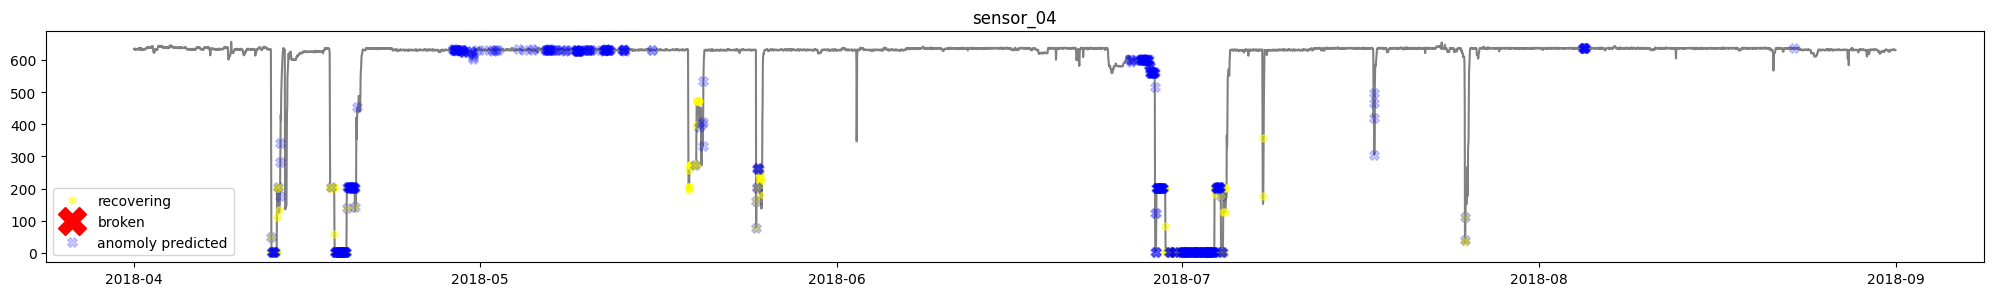

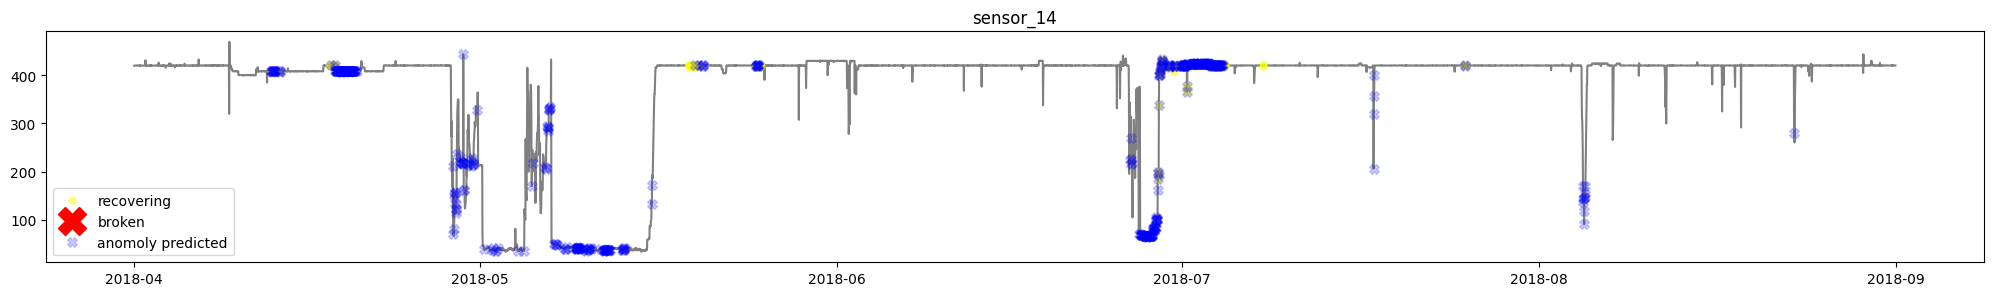

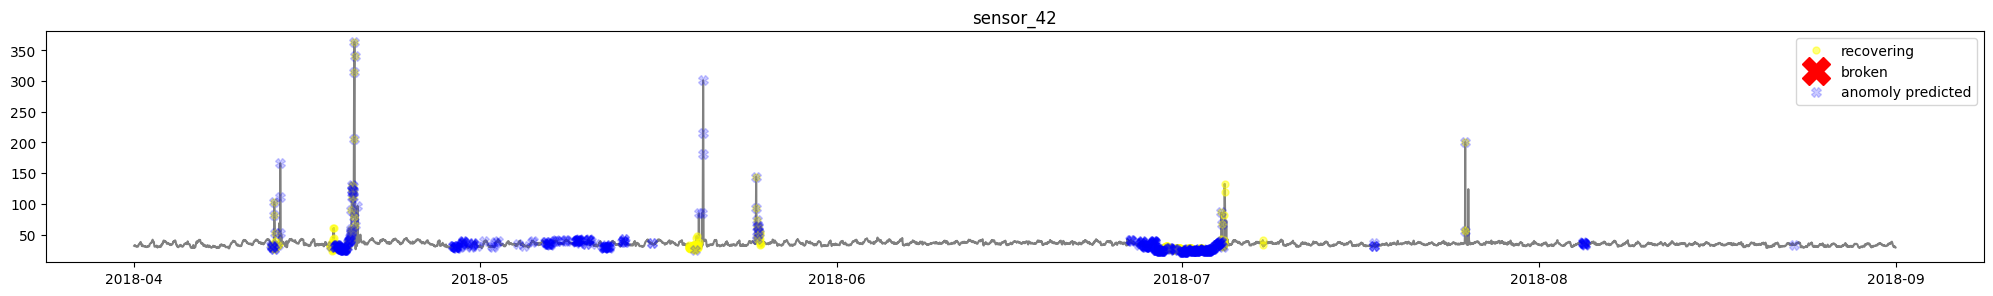

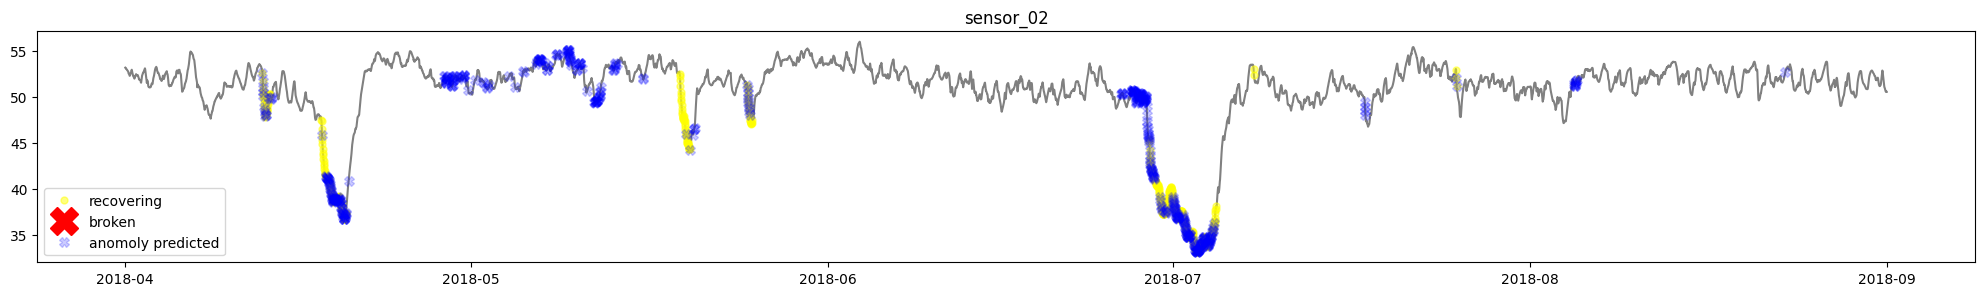

In [110]:
# 30 minutes without standardization
df_not_normal = aggregating_df(corrected_df, '30T', standardize=False)
df_not_normal["Isolation Forest"] = df_resampled["Isolation Forest"]

# plot four representative sensors
plot_sensor_anomolies(df_not_normal, ['sensor_04'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_14'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_42'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_02'], anomaly_method_name='Isolation Forest')

The plots provide a visual representation of both the strengths and weaknesses of the method mentioned in the privious paragraph. One notable observation is the significant reduction in the presence of noise, which becomes evident when examining the plots. However, it is important to note that unintended shifts in the datapoints of the 'RECOVERING' category are also noticeable. These shifts can be seen as a potential drawback of the method, impacting the accuracy of detecting and representing the recovery process.

Next, the resampling/aggregation method will be utilized for one hour.

In [117]:
# one hour
df_resampled = aggregating_df(corrected_df, 'H', standardize=True)
df_resampled = anomaly_detection_methods(df_resampled, ["Isolation Forest"])
anomaly_counter(df_resampled)

Isolation Forest
IsolationForest(contamination=0.06563180827886705, n_jobs=-1)


c:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


----------------------------------------------------------------------------------------------------
number of anomolies detected
Isolation Forest
 1    3431
-1     241
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
the predictions for NORMAL:
Isolation Forest     1   -1
Isolation Forest  3324  107

the predictions for RECOVERING:
Isolation Forest   -1    1
Isolation Forest  134  107



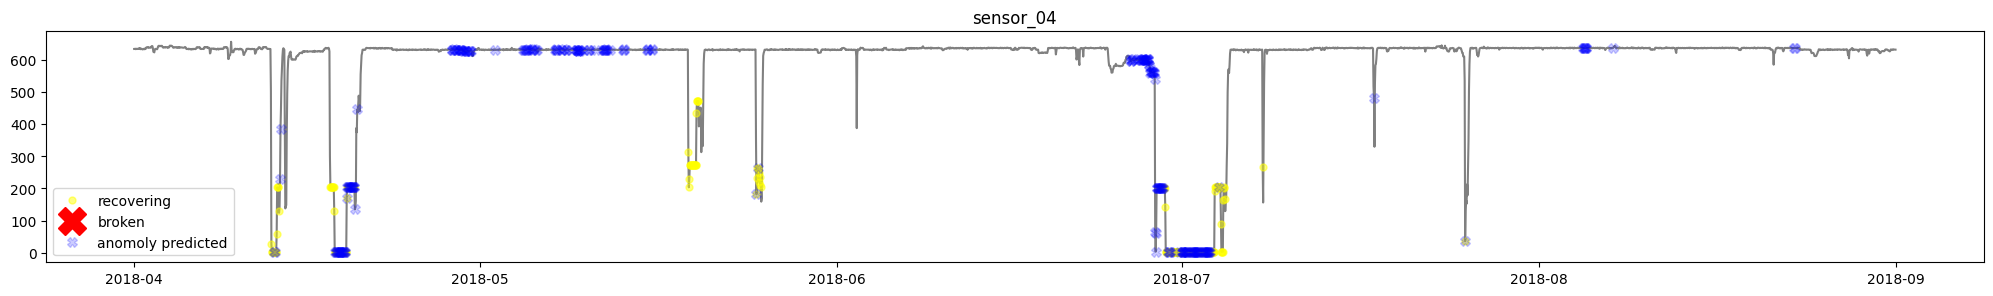

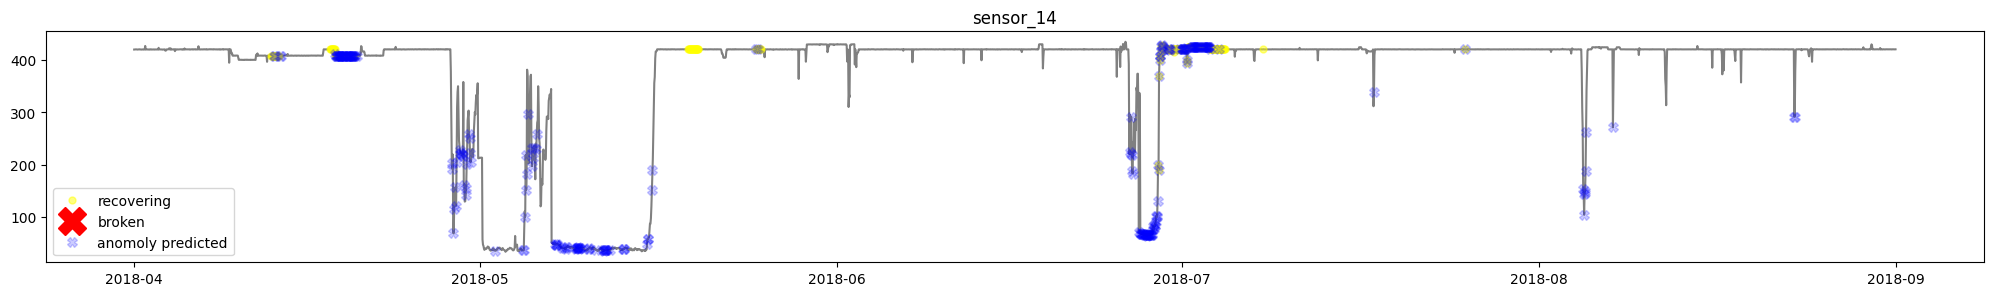

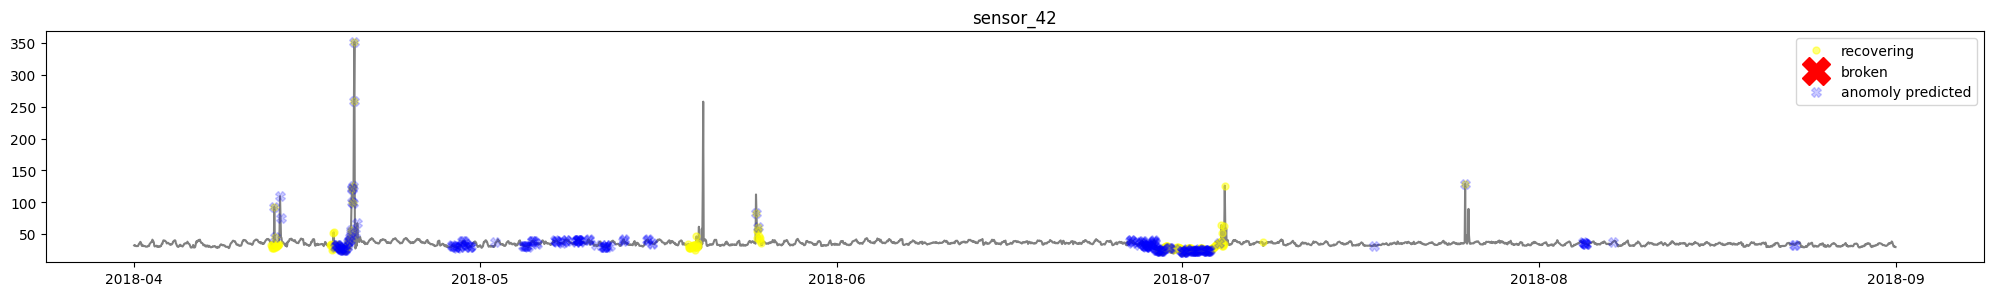

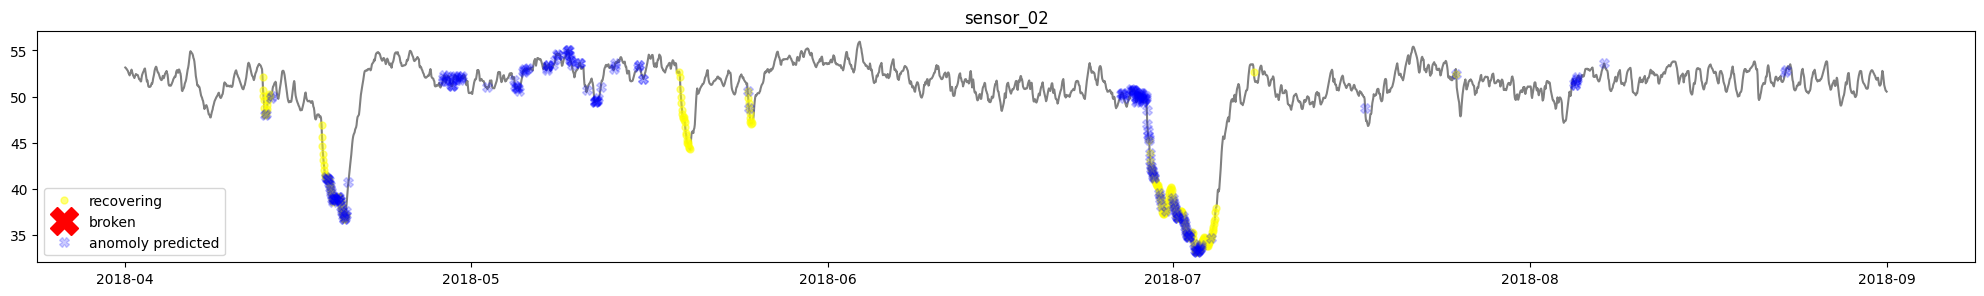

In [115]:
# one hour without standardization
df_not_normal = aggregating_df(corrected_df, 'H', standardize=False)
df_not_normal["Isolation Forest"] = df_resampled["Isolation Forest"]

# plot four representative sensors
plot_sensor_anomolies(df_not_normal, ['sensor_04'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_14'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_42'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_02'], anomaly_method_name='Isolation Forest')

Upon reducing the resampling interval from 30 minutes to one hour, the dataset's scope does not decrease significantly. Consequently, no substantial additional explanations or insights can be derived from the resulting plots. However, the pros and cons mentioned earlier are amplified in this particular experimental setup. Additionally, the percentage of correct predictions increases to over 50%. It is important to note that due to the stochastic nature of this method, the number of correct predictions may vary each time, but predominantly exceeds 50%.

Now let's have a look at 12 hours, and hopefully we can see some differences here.

In [126]:
# twelve hour
df_resampled = aggregating_df(corrected_df, '12H', standardize=True)
df_resampled = anomaly_detection_methods(df_resampled, ["Isolation Forest"])
anomaly_counter(df_resampled)

Isolation Forest
IsolationForest(contamination=0.06209150326797386, n_jobs=-1)
----------------------------------------------------------------------------------------------------
number of anomolies detected
Isolation Forest
 1    287
-1     19
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
the predictions for NORMAL:
Isolation Forest    1  -1
Isolation Forest  281   6

the predictions for RECOVERING:
Isolation Forest  -1   1
Isolation Forest  13   6



c:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


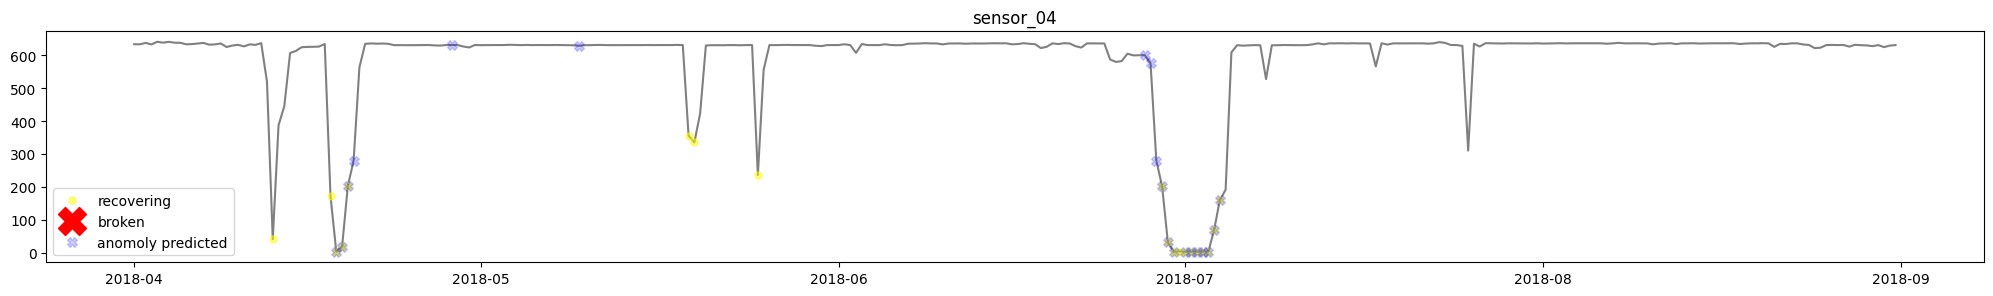

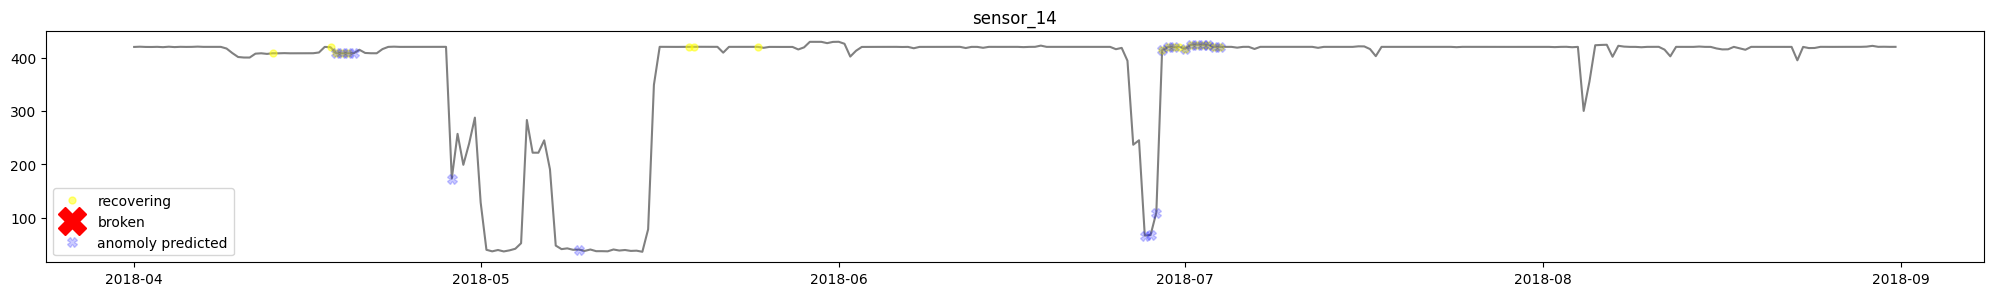

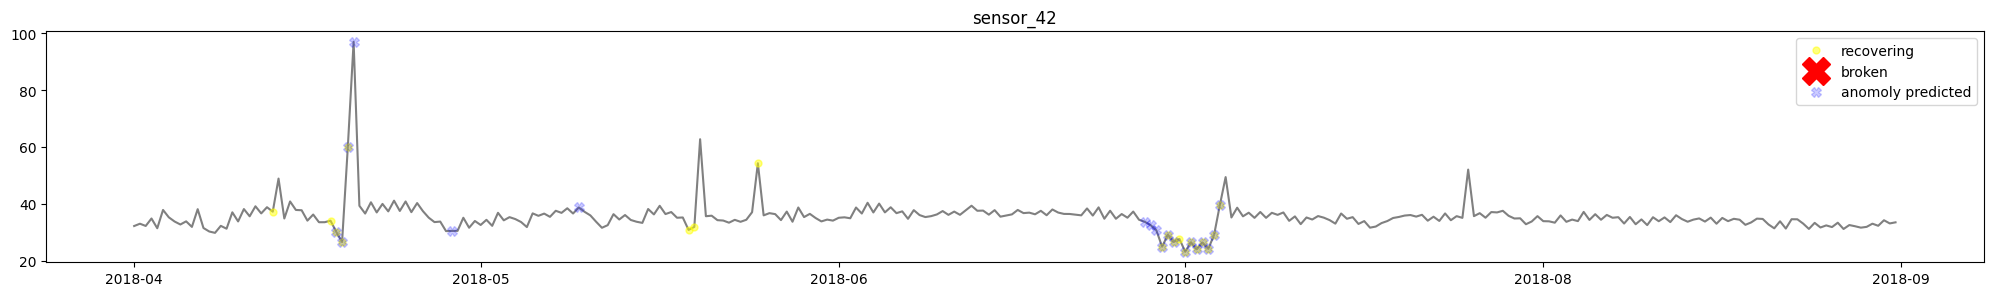

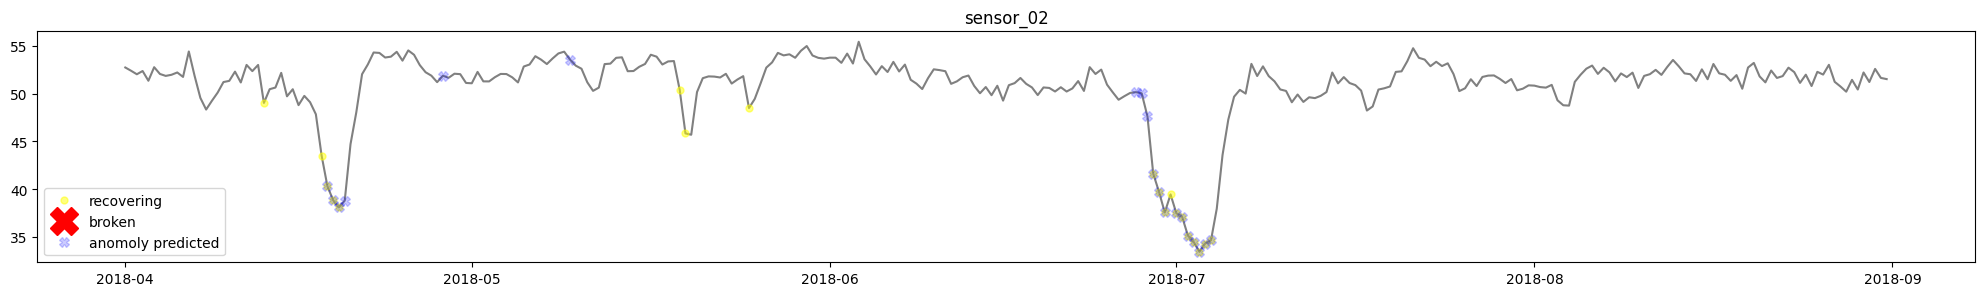

In [128]:
# 12 hours without standardization
df_not_normal = aggregating_df(corrected_df, '12H', standardize=False)
df_not_normal["Isolation Forest"] = df_resampled["Isolation Forest"]

# plot four representative sensors
plot_sensor_anomolies(df_not_normal, ['sensor_04'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_14'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_42'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_02'], anomaly_method_name='Isolation Forest')

By reducing the time interval from one hour to twelve hours, a significant reduction in noise is achieved within the dataset. This allows for the emergence of a more distinct shape representing the general trend of each sensor. Notably, the anomaly prediction performance using the Isolation Forest algorithm experiences a drastic improvement, averaging around 70%.

However, it is important to consider the trade-offs. With the removal of most of the RECOVER and all of the BROKEN information from the dataset, two out of seven anomaly spots vanish. In other words, the model loses its ability to capture fine-grained temporal patterns, rapid changes, and nuanced anomalies. As a result, this approach becomes limited to determining the overall pattern of changes and cannot provide accurate estimations of system trends and anomalies.

The situation will become worse when I increase the time range to a day.

In [138]:
# one day
df_resampled = aggregating_df(corrected_df, 'D', standardize=True)
df_resampled = anomaly_detection_methods(df_resampled, ["Isolation Forest"])
anomaly_counter(df_resampled)

Isolation Forest
IsolationForest(contamination=0.065359477124183, n_jobs=-1)
----------------------------------------------------------------------------------------------------
number of anomolies detected
Isolation Forest
 1    143
-1     10
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
the predictions for NORMAL:
Isolation Forest    1  -1
Isolation Forest  141   2

the predictions for RECOVERING:
Isolation Forest  -1   1
Isolation Forest   8   2



c:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


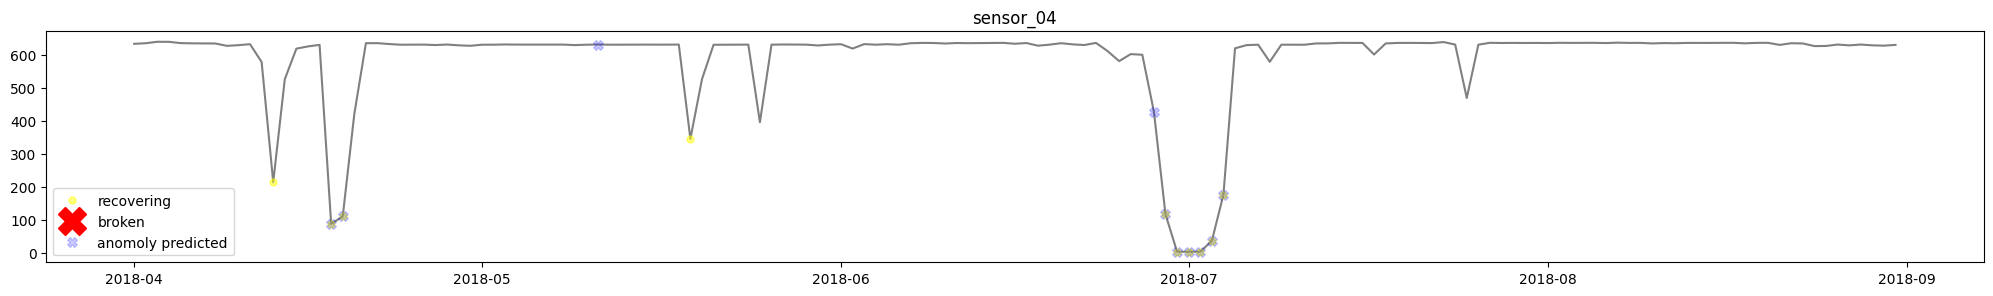

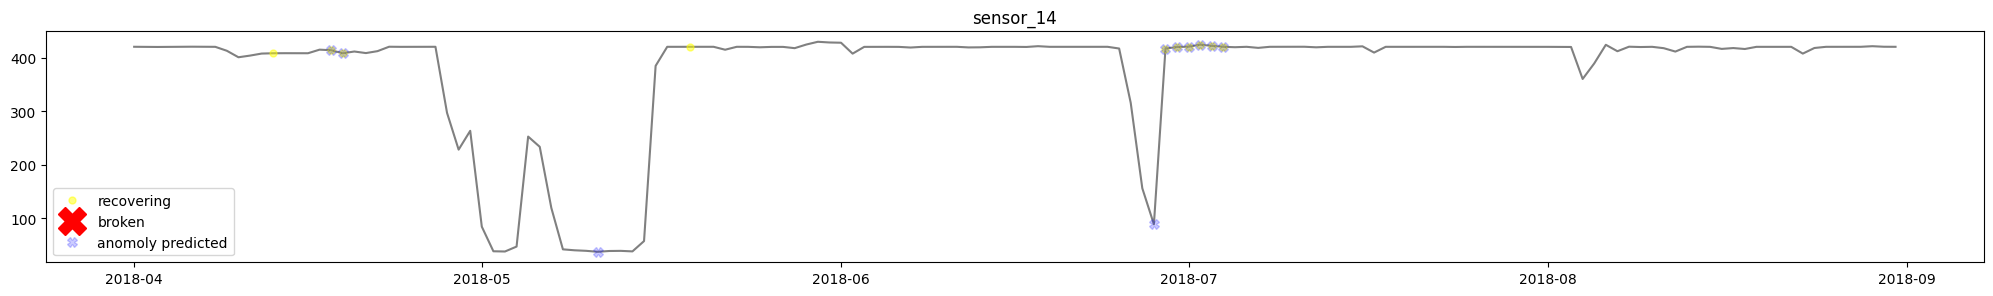

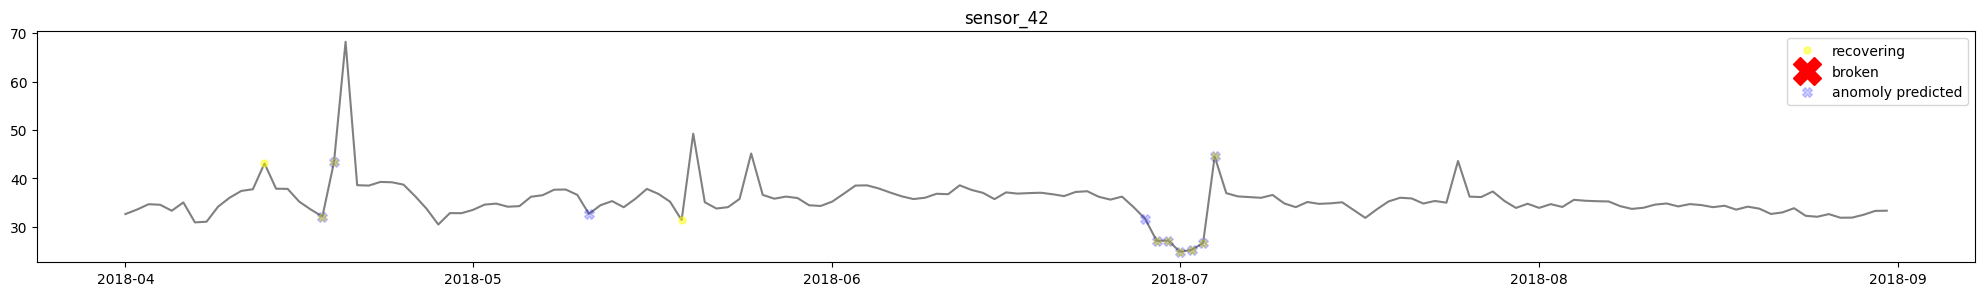

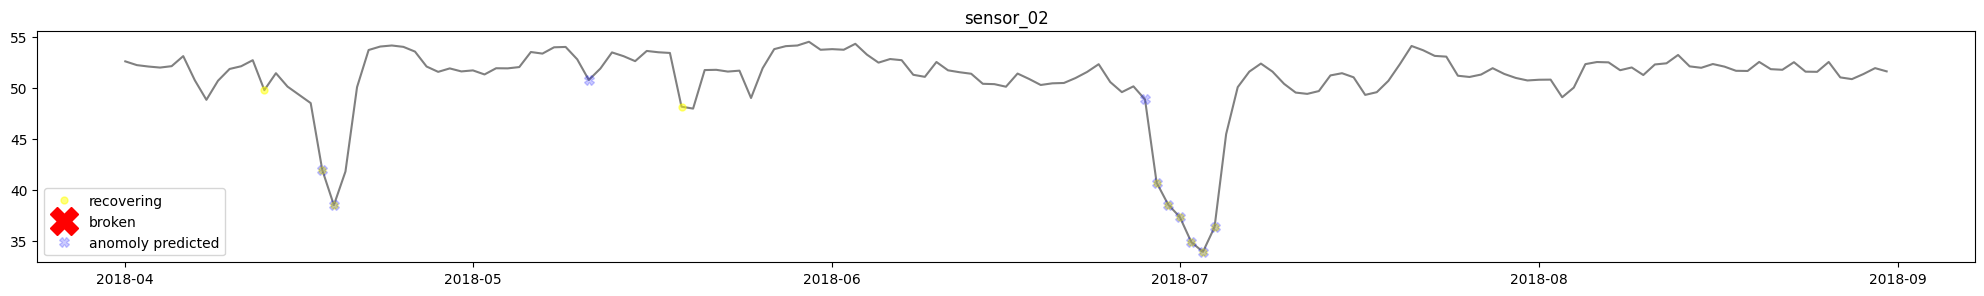

In [139]:
# 12 hours without standardization
df_not_normal = aggregating_df(corrected_df, 'D', standardize=False)
df_not_normal["Isolation Forest"] = df_resampled["Isolation Forest"]

# plot four representative sensors
plot_sensor_anomolies(df_not_normal, ['sensor_04'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_14'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_42'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(df_not_normal, ['sensor_02'], anomaly_method_name='Isolation Forest')

The one-day interval follows the 12 hour's interval trend, and provides a macro-level perspective on data behavior, facilitating the identification of long-term trends and anomalies. However, like the privious part, The loss of fine-grained temporal information may result in the inability to detect short-duration anomalies or those occurring within smaller time frames. It might also limit the understanding of intraday patterns or rapid changes.

This method outperformed the outlier removal technique in this study. I believe that finding the optimal resampling/aggregation strategy, which strikes a balance between detecting temporal noise, anomaly detection sensitivity, and the ability to capture various types of anomalies, is an art for a data scientist. In the case of this specific dataset, which contains a significant amount of noise and sensor malfunctions (some of which are as the order of anomalies), the ideal time range appears to be one hour. By employing this range, not only can one preserve the majority of anomaly trends and spots, but they can also effectively reduce a substantial amount of noise.

However, the primary utility of this method lies in providing valuable insights into the general trend of the dataset. It is important to note that using this method for precise prediction of anomalies may not yield optimal results.

Consequently, in the subsequent section of this comprehensive study, smoothing methods will be introduced. It will become evident that, in addition to their simplicity, these methods can outperform the aforementioned techniques in both predicting anomalies and preserving the dataset.

## 4- Smoothing Techniques
Smoothing techniques are kinds of data preprocessing techniques to remove noise from a data set. This allows important patterns to stand out. The idea behind data smoothing is that it can identify simplified changes to help predict different trends and patterns. It acts as an aid for statisticians or traders who need to look at a lot of data. There are different data smoothing techniques, but the two that I will implement in the following section are:

1. Moving average smoothing

2. Exponential smoothing

For further information about these techniques, and also other techniques one may study the following link:

https://medium.com/@srv96/smoothing-techniques-for-time-series-data-91cccfd008a2

In this study, moving average smoothing with an optimal window number and exponential smoothing will be utilized, and the results of these two methods will be compared with the methods from the privious sections.

In [39]:
# fill the nan values using backward imputation technique
corrected_df = df_imputer(df)
corrected_df.head()

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
timestamp                                                                    
2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   638.8889   
2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   628.1250   
2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   636.4583   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
timestamp                                                                    
2018-04-01 00:00:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:01:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:02:00   73.54598   13.32465   16.03733   15.61777   15.01013   
2018-04-01 00:03:00   76.98898   13.31742   16.24711   15.69734   15.08247   
2018-04-01 00:04:00   76.58897   13.35359   16.21094   15.69734   15.08247   

                     ...  sensor_41  sensor_42  sensor_43  sensor_44  \
timestamp            ...                                               
2018-04-01 00:00:00  ...   30.98958  31.770832   41.92708  39.641200   
2018-04-01 00:01:00  ...   30.98958  31.770832   41.92708  39.641200   
2018-04-01 00:02:00  ...   30.46875  31.770830   41.66666  39.351852   
2018-04-01 00:03:00  ...   30.46875  31.510420   40.88541  39.062500   
2018-04-01 00:04:00  ...   30.98958  31.510420   41.40625  38.773150   

                     sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
timestamp                                                                    
2018-04-01 00:00:00   65.68287   50.92593  38.194440   157.9861   67.70834   
2018-04-01 00:01:00   65.68287   50.92593  38.194440   157.9861   67.70834   
2018-04-01 00:02:00   65.39352   51.21528  38.194443   155.9606   67.12963   
2018-04-01 00:03:00   64.81481   51.21528  38.194440   155.9606   66.84028   
2018-04-01 00:04:00   65.10416   51.79398  38.773150   158.2755   66.55093   

                     machine_status  
timestamp                            
2018-04-01 00:00:00          NORMAL  
2018-04-01 00:01:00          NORMAL  
2018-04-01 00:02:00          NORMAL  
2018-04-01 00:03:00          NORMAL  
2018-04-01 00:04:00          NORMAL  

[5 rows x 50 columns]

In [24]:
def smoothing_data(df, smoothing_par, smoothing_method='exponential', standardization=True):
    float_df = df.iloc[:,:49]

    if smoothing_method == 'rolling_mean':
        #calculate rolling mean
        smoothed_df = float_df.rolling(window=smoothing_par, min_periods=1).mean()
    
    else:
        #calculate exponential smoothing technique
        smoothed_dfs = {}

        for column in float_df.columns:
            model = SimpleExpSmoothing(float_df[column])
            smoothed_model = model.fit(smoothing_level=smoothing_par, optimized=True,)
            smoothed_dfs[column] = smoothed_model.fittedvalues

        smoothed_df = pd.DataFrame(smoothed_dfs)

    # standardize the dataframe
    if standardization:
        smoothed_df = smoothed_df.apply(lambda x: (x - x.mean()) / x.std())

    df.iloc[:, :49] = smoothed_df

    return df

Firstly, I employed the rolling average smoothing technique with a window width of 60. The choice of this window width is based on the optimal outcome obtained in the previous section, where I aggregated the data in one-hour intervals. By using this knowledge, I selected a window width of 60 to achieve a balance between accurate anomaly detection and preserving the micro trends within the dataset.

In [41]:
# Use 60 as the width of the windows
smoothed_df = smoothing_data(corrected_df, 60, 'rolling_mean')
smoothed_df = anomaly_detection_methods(smoothed_df, ["Isolation Forest"])
anomaly_counter(smoothed_df)

Isolation Forest
IsolationForest(contamination=0.06574074074074077, n_jobs=-1)


c:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


----------------------------------------------------------------------------------------------------
number of anomolies detected
Isolation Forest
 1    205837
-1     14483
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
the predictions for BROKEN:
Isolation Forest   1  -1
Isolation Forest   6   1

the predictions for NORMAL:
Isolation Forest       1    -1
Isolation Forest  199995  5841

the predictions for RECOVERING:
Isolation Forest    -1     1
Isolation Forest  8641  5836



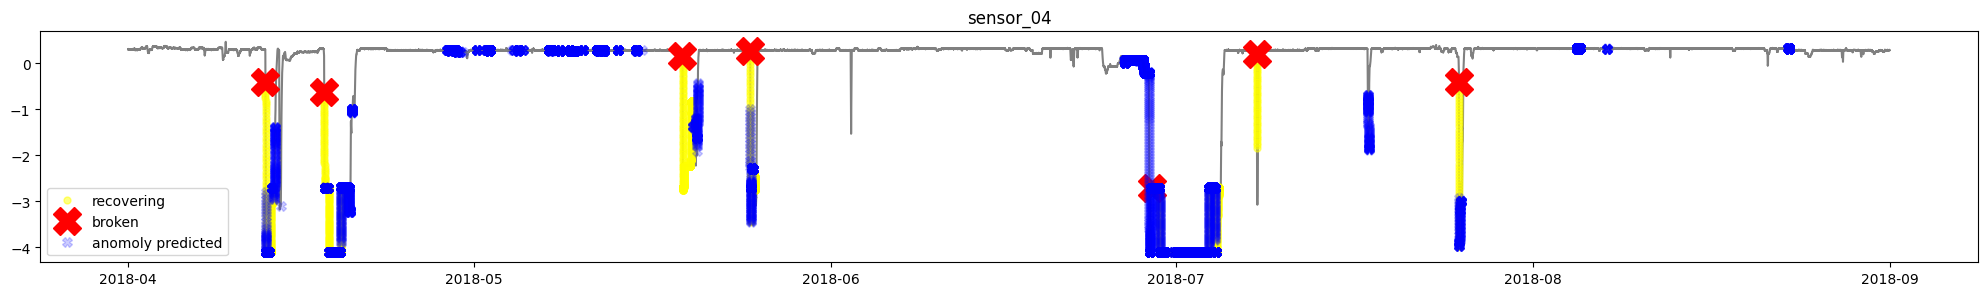

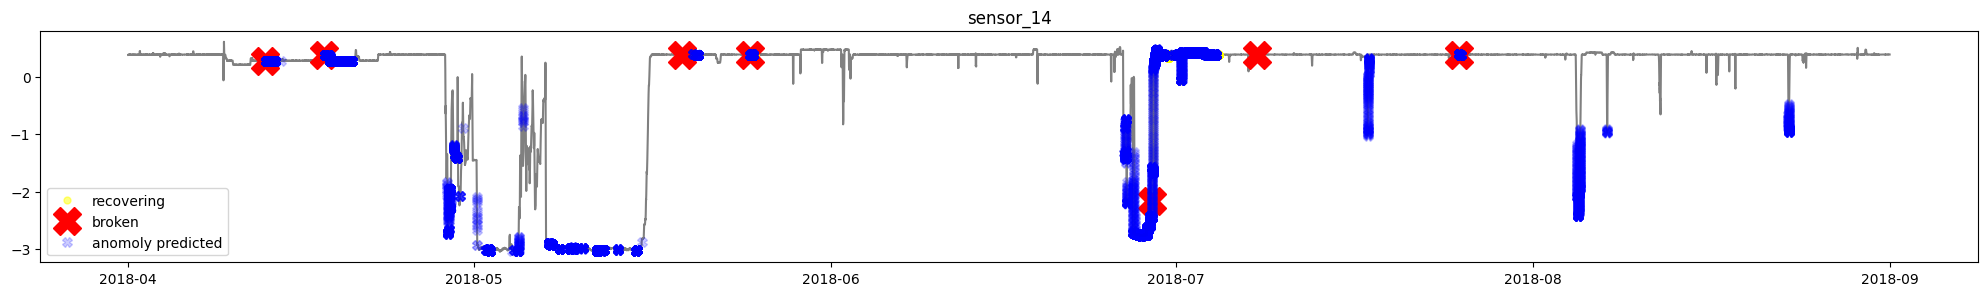

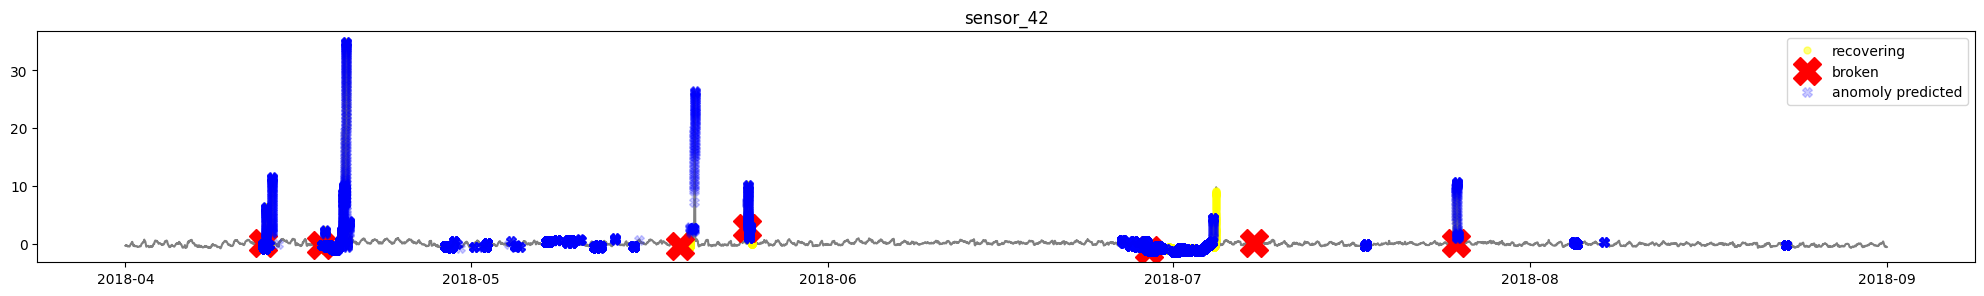

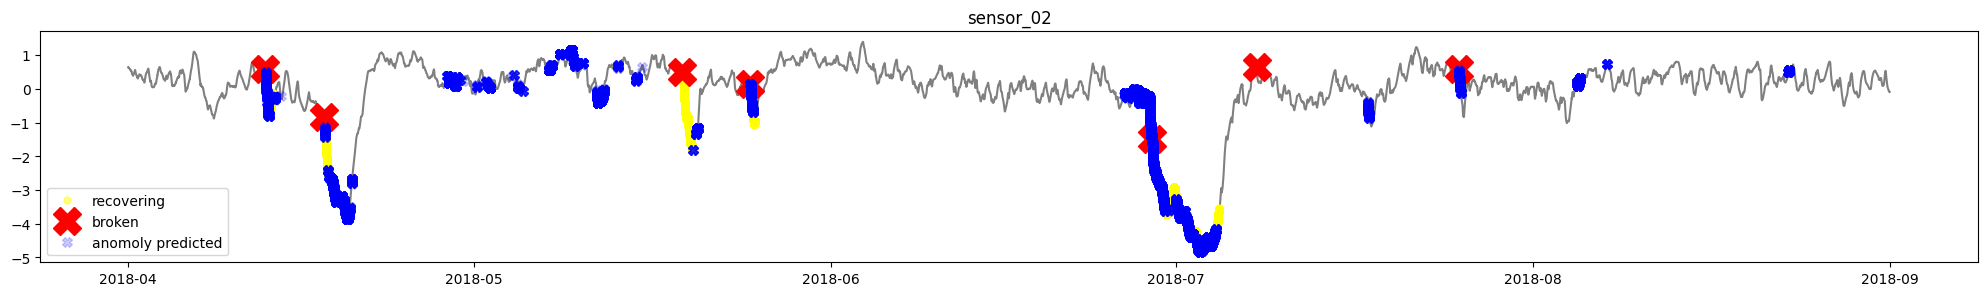

In [42]:
# plot four representative sensors
plot_sensor_anomolies(smoothed_df, ['sensor_04'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(smoothed_df, ['sensor_14'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(smoothed_df, ['sensor_42'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(smoothed_df, ['sensor_02'], anomaly_method_name='Isolation Forest')

As observed, the trends are adequately preserved, and there is a noticeable reduction in the amount of noise. Moreover, this preprocessing method yields an average accuracy of 60% in detecting anomalies. Before delving into further analysis, first implement the exponential smoothing technique. The smoothing level is set to "None" in this case, as the algorithm itself is responsible for determining the optimal amount of smoothing.

In [43]:
# implement exponential smoothing
smoothed_df = smoothing_data(corrected_df, None, 'exponential')
smoothed_df = anomaly_detection_methods(smoothed_df, ["Isolation Forest"])
anomaly_counter(smoothed_df)

c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\stat

Isolation Forest
IsolationForest(contamination=0.06574074074074077, n_jobs=-1)


c:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


----------------------------------------------------------------------------------------------------
number of anomolies detected
Isolation Forest
 1    205836
-1     14484
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
the predictions for BROKEN:
Isolation Forest   1  -1
Isolation Forest   6   1

the predictions for NORMAL:
Isolation Forest       1    -1
Isolation Forest  200468  5368

the predictions for RECOVERING:
Isolation Forest    -1     1
Isolation Forest  9115  5362



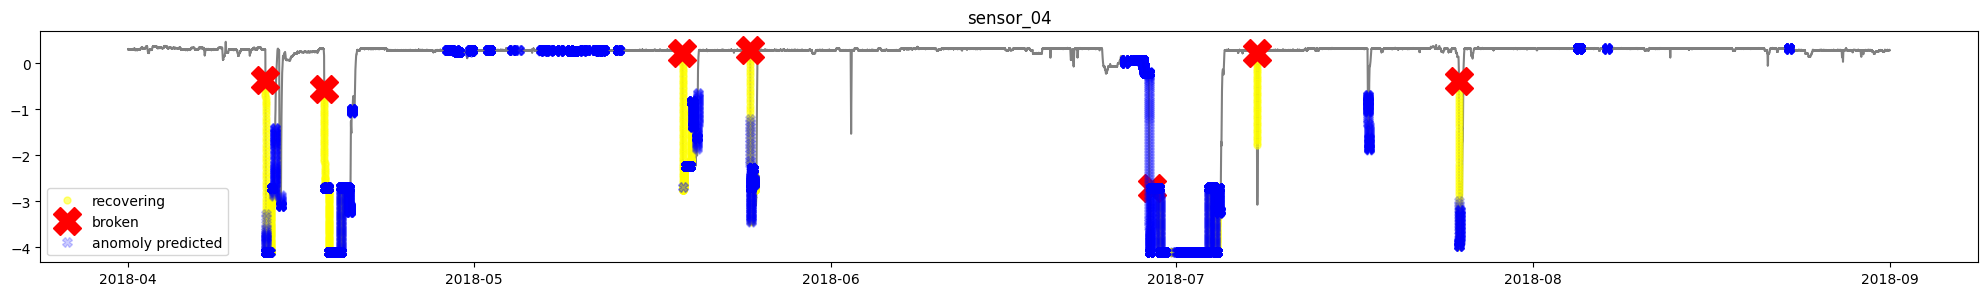

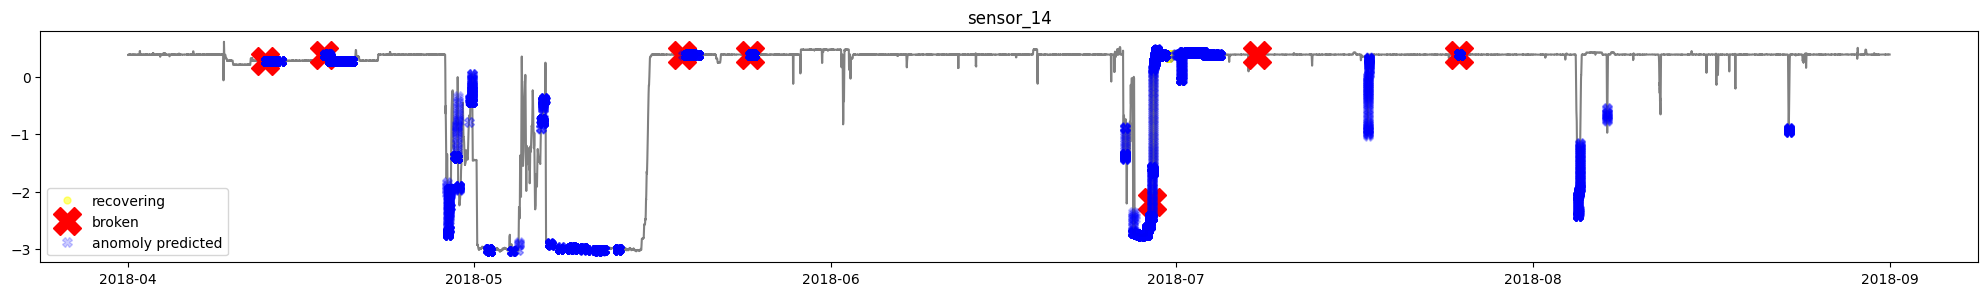

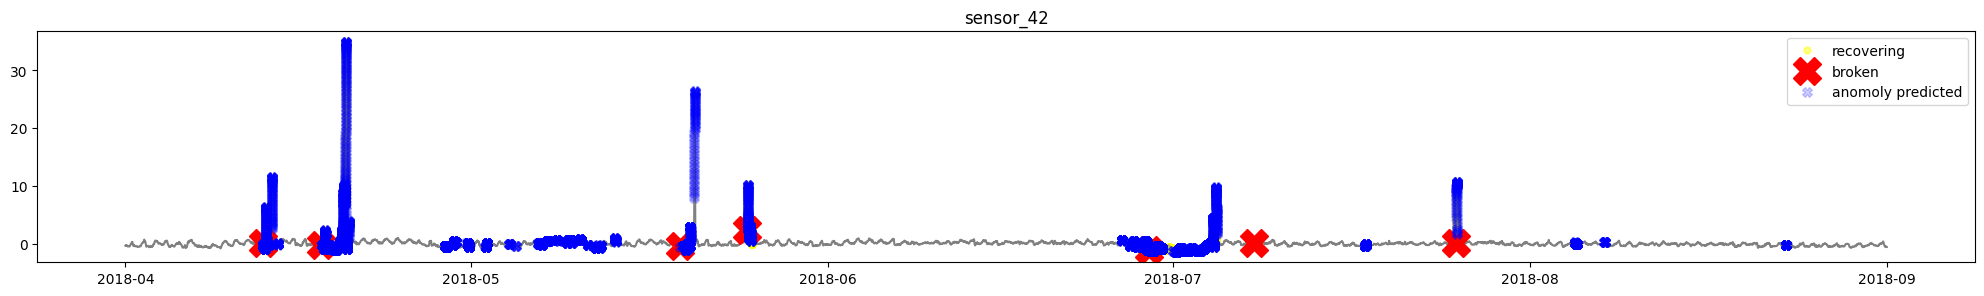

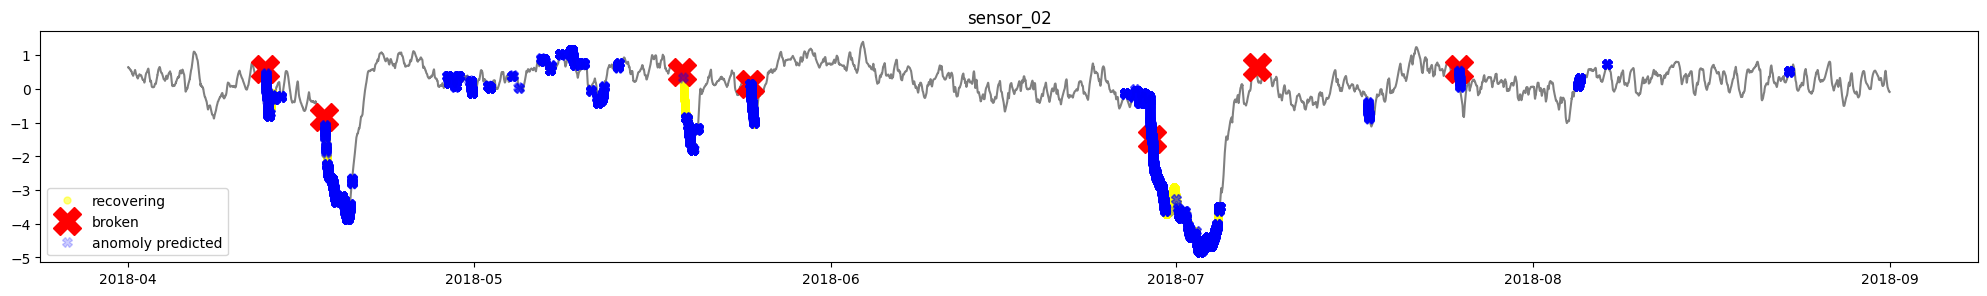

In [44]:
# plot four representative sensors
plot_sensor_anomolies(smoothed_df, ['sensor_04'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(smoothed_df, ['sensor_14'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(smoothed_df, ['sensor_42'], anomaly_method_name='Isolation Forest')
plot_sensor_anomolies(smoothed_df, ['sensor_02'], anomaly_method_name='Isolation Forest')

This method yields even more favorable outcomes than the rolling average technique. Comparing the smoothing method with the previous ones, it becomes immediately apparent that the BROKEN category can be maintained, and all the trends within the RECOVERING category are preserved. Additionally, the amount of reduced noise and the percentage of correct anomaly predictions are comparable, and in some cases, even superior to the previous methods.

Consequently, one can conclude that among all the preprocessing techniques employed in this study, the smoothing technique proves to be the best. It not only preserves the inherent characteristics of the dataset but also achieves the highest accuracy in predicting the anomaly datapoints.

 Achieving this level of accuracy may not be sufficient when dealing with critical equipment such as a water pump. There are numerous other preprocessing and anomaly detection methods that can be employed to improve the prediction capabilities of this study case. Additionally, various evaluation techniques, including F1-score and ROC-AUC (Receiver Operating Characteristic Area Under the Curve), can be utilized to assess the performance of each anomaly detection technique. Therefore, there is a wide range of unsupervised techniques that can be explored within the scope of this study. I have endeavored to stay within the boundaries of the given questions and avoid exceeding them.

One effective approach to improve the mentioned precision is to employ supervised machine learning techniques, which are likely to be more suitable for this particular dataset. The reason behind this is that the dataset comprises around 50 sensors and 4 distinct trends, each of which operates independently over time. However, only one or maybe two of these patterns may be crucial for analyzing the overall dataset. Hence, in the final phase of this comprehensive study, I will implement a novel technique known as Feature Engineering. This technique will help us identify the most important sensors within the dataset and subsequently apply an anomaly detection technique to assess and compare its impact.

## 5- Feature Engineering
In various scenarios, redundant sources of information can hold varying degrees of importance. While they may provide crucial insights in some cases, they can be considered mere noise in others. A substantial amount of redundant data can arise from extensive simulations or independent measurements of the same system. Feature engineering techniques possess a unique capability to address this redundancy, ensuring computational efficiency and improved problem tractability.

https://en.wikipedia.org/wiki/Feature_engineering   

To implement the Feature Engineering technique, I will employ the best configuration that I have devised. Firstly, I will apply the backward fill imputation technique to handle missing values. Next, I will utilize exponential smoothing to smooth the data, followed by standardizing the dataset. Subsequently, I will implement the Feature Engineering technique, in this study SelectKBest, which can be explored further by clicking on this <a href = 'https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering'> link</a>. Finally, I will employ the Isolation Forest technique to make the most accurate predictions. However, it is important to be cautious about the potential issue of overfitting when implementing this specific configuration.

In [50]:
# fill the nan values using backward imputation technique
corrected_df = df_imputer(df, method='bfill')

# implement exponential smoothing
smoothed_df = smoothing_data(corrected_df, None, 'exponential', standardization=False)

smoothed_df.head()

c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\stat

sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
timestamp                                                                     
2018-04-01 00:00:00   2.464705  47.134162  53.195744  46.340892  634.656524   
2018-04-01 00:01:00   2.465301  47.116404  53.199575  46.328517  634.506393   
2018-04-01 00:02:00   2.465381  47.106127  53.202492  46.321224  634.436324   
2018-04-01 00:03:00   2.447516  47.209890  53.204714  46.352580  636.810787   
2018-04-01 00:04:00   2.458728  47.160229  53.196048  46.371056  632.178843   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
timestamp                                                                    
2018-04-01 00:00:00  76.427107  13.410666  16.131337  15.570145  15.052139   
2018-04-01 00:01:00  76.456037  13.411384  16.131360  15.567761  15.053190   
2018-04-01 00:02:00  76.459328  13.411453  16.131360  15.567262  15.053447   
2018-04-01 00:03:00  73.877360  13.332911  16.038594  15.607195  15.020706   
2018-04-01 00:04:00  76.635048  13.318894  16.244308  15.678467  15.067390   

                     ...  sensor_41  sensor_42  sensor_43  sensor_44  \
timestamp            ...                                               
2018-04-01 00:00:00  ...  30.989580  31.770832  41.927080  39.559412   
2018-04-01 00:01:00  ...  30.989580  31.770832  41.927080  39.606935   
2018-04-01 00:02:00  ...  30.989580  31.770832  41.927080  39.626845   
2018-04-01 00:03:00  ...  30.471354  31.770830  41.667962  39.467060   
2018-04-01 00:04:00  ...  30.468763  31.511722  40.889323  39.231990   

                     sensor_45  sensor_46  sensor_47   sensor_48  sensor_49  \
timestamp                                                                     
2018-04-01 00:00:00  65.682870  50.925930  38.194440  157.986100  67.708340   
2018-04-01 00:01:00  65.682870  50.925930  38.194440  157.986100  67.708340   
2018-04-01 00:02:00  65.682870  50.925930  38.194440  157.986100  67.708340   
2018-04-01 00:03:00  65.394967  51.213833  38.194443  155.970728  67.132524   
2018-04-01 00:04:00  64.817711  51.215273  38.194440  155.960651  66.841741   

                     machine_status  
timestamp                            
2018-04-01 00:00:00          NORMAL  
2018-04-01 00:01:00          NORMAL  
2018-04-01 00:02:00          NORMAL  
2018-04-01 00:03:00          NORMAL  
2018-04-01 00:04:00          NORMAL  

[5 rows x 50 columns]

in the first step oneHotEncoder should be utilized to create a binary column for each category. Based on the above link I will implement SelectKBest method. It is a feature selection technique in machine learning that helps select the top K features with the highest importance or relevance for a given task. It is commonly used to reduce the dimensionality of the feature space by selecting the most informative features. Here, one can use chi2 as the scoring function since The chi-squared (chi2) test is a statistical test used to determine if there is a significant association between two categorical variables.  Moreover, SelectKBest cannot work with negative numbers consequently another normalization technique called maximum value normalization will be used in this context.
 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering

During this study case, I have noticed that there might be variations in the impact of different sensors on anomaly detection, as the behavior of some sensors changes significantly during pump deficiency. Now, I aim to evaluate the validity of this assumption. To accomplish this, I will employ the SelectKBest algorithm in the following manner.

In [51]:
def making_one_hot(df):
    
    # make one hot encoder
    status_series = df.machine_status
    one_hot = pd.get_dummies(status_series)
    one_hot = one_hot.astype(int)
    return one_hot

In [52]:
def feature_engineering(df, normalization='max'):

    float_df = df.iloc[:,:49]
    # make one hot encoder
    one_hot = making_one_hot(df)

    # Normalize the dataset
    if normalization == 'max':
        
        float_df = float_df.apply(lambda x: x / x.abs().max())
    
    elif normalization == 'min_max':
        float_df = float_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    # extract feature importance scores
    selector = SelectKBest(score_func=chi2)
    fit = selector.fit(float_df, one_hot['NORMAL'])
    
    return selector, fit

In [53]:
def sorting_scores(df, fit):
    rank_dict = {}
    names = df.columns

    # make a dictionary of scores
    for number in range(len(fit.scores_)):
        rank_dict[names[number]] = fit.scores_[number]

    # sort the scores
    rank_dict = dict(sorted(rank_dict.items(), key=lambda item: -1 * item[1]))

    return rank_dict

In [54]:
def plotting_score(df, fit):

    # sort scores with a decending manner
    rank_dict = sorting_scores(df, fit)

    keys = list(rank_dict.keys())
    values = list(rank_dict.values())

    # sketch the plot
    fig = plt.figure(figsize= (15,6))
    # Plotting the data
    plt.scatter(keys, values)

    # Optional: Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Optional: Add labels and a title
    plt.xlabel("Sensors")
    plt.ylabel("Scores")
    plt.title("Sensor-Score")

    # Display the plot
    plt.show()

In [55]:
# run SelectKBest
selector, fit = feature_engineering(smoothed_df,'max')
fit.scores_

array([1.25711485e+04, 4.03466463e+02, 6.49968396e+02, 2.55064073e+02,
       9.25747647e+03, 1.69670690e+03, 4.58793585e+03, 4.36319761e+03,
       3.41892590e+03, 3.05827855e+03, 7.77248303e+03, 1.01219473e+04,
       9.89261869e+03, 3.46938712e+03, 1.25893574e+02, 9.06166496e+01,
       8.11389439e+01, 5.10873199e+01, 1.37442124e+02, 1.07003165e+02,
       9.16086595e+01, 1.21586498e+02, 1.51246271e+02, 1.28328625e+02,
       1.20483040e+02, 8.09825509e+01, 6.67825804e+00, 5.69184104e+02,
       3.77924308e+01, 1.14052348e+02, 2.86218860e+02, 1.88015978e+02,
       7.14772289e+01, 2.68632955e+01, 1.24147608e+02, 1.17973781e+01,
       1.46093335e+02, 1.52951784e+02, 1.57971660e+00, 4.00705776e+02,
       9.84505323e+00, 9.15063111e-02, 2.10441258e+01, 6.44529184e+01,
       1.07913128e+02, 1.24218840e+02, 1.15926574e+02, 2.36247205e+03,
       2.48503767e+02])

The scores indicate that certain sensors have a greater influence on the overall trend of the dataset. To enhance visual comprehension, I have included a scatter plot below.

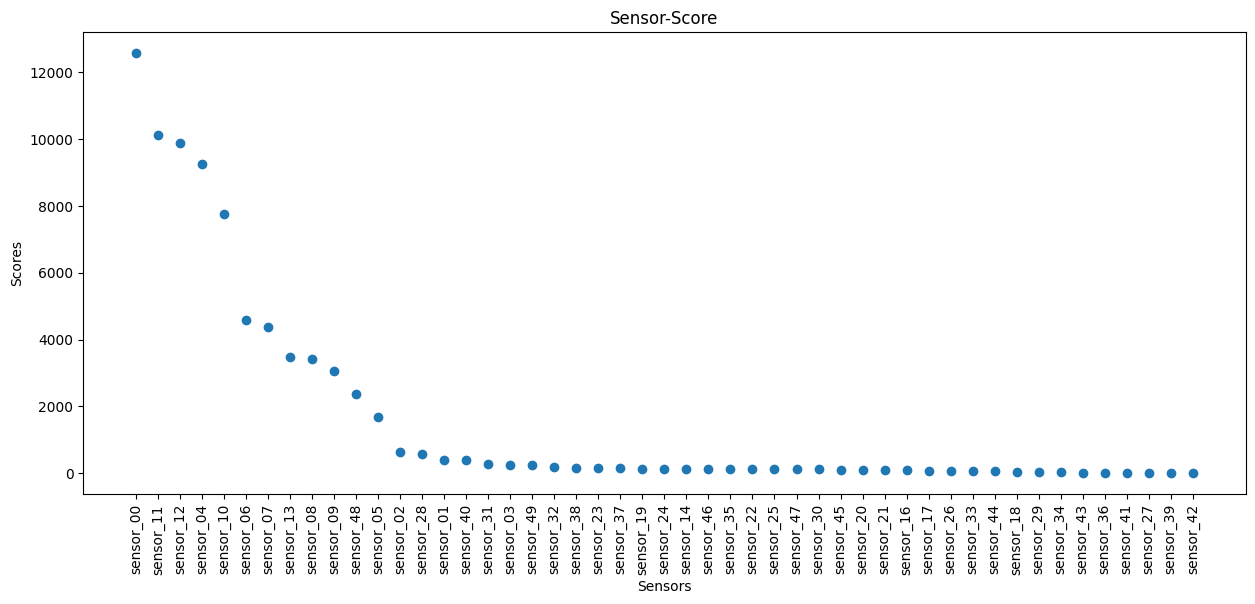

In [56]:
plotting_score(smoothed_df, fit)


Upon analyzing the scatter plot, it is evident that the initial 12 sensors exert the greatest influence on the overall trend. This conclusion is drawn from observing the location of the elbow, which occurs after the twelfth sensor. Consequently, my next step will involve selecting and isolating the data from these twelve sensors in order to implement Isolation Forest. Although one could utilize the inner function of SelectKBest for cropping the dataset like the following <a href = 'https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering'> link</a>, I will manually perform this task instead. This approach will allow for a more tailored implementation.

In [57]:
def cropping_df(df, fit, slice_number):

    # make the rank dictionary
    rank_dict = sorting_scores(df, fit)

    # make name list
    name_list = list(rank_dict.keys())[:slice_number]
    

    # crop the dataframe
    selected_df = df.iloc[:,:49].loc[:,name_list]
    selected_df['machine_status'] = df['machine_status']

    return selected_df

In [58]:
selected_df = cropping_df(smoothed_df, fit, 12)
selected_df.head()

sensor_00  sensor_11  sensor_12   sensor_04  sensor_10  \
timestamp                                                                     
2018-04-01 00:00:00   2.464705   47.52422  31.117160  634.656524  37.227400   
2018-04-01 00:01:00   2.465301   47.52422  31.117160  634.506393  37.227400   
2018-04-01 00:02:00   2.465381   47.52422  31.117160  634.436324  37.227400   
2018-04-01 00:03:00   2.447516   48.17723  32.084081  636.810787  37.864568   
2018-04-01 00:04:00   2.458728   48.65607  31.674269  632.178843  38.576194   

                     sensor_06  sensor_07  sensor_13  sensor_08  sensor_09  \
timestamp                                                                    
2018-04-01 00:00:00  13.410666  16.131337   1.681353  15.570145  15.052139   
2018-04-01 00:01:00  13.411384  16.131360   1.681353  15.567761  15.053190   
2018-04-01 00:02:00  13.411453  16.131360   1.681353  15.567262  15.053447   
2018-04-01 00:03:00  13.332911  16.038594   1.706358  15.607195  15.020706   
2018-04-01 00:04:00  13.318894  16.244308   1.589329  15.678467  15.067390   

                      sensor_48  sensor_05 machine_status  
timestamp                                                  
2018-04-01 00:00:00  157.986100  76.427107         NORMAL  
2018-04-01 00:01:00  157.986100  76.456037         NORMAL  
2018-04-01 00:02:00  157.986100  76.459328         NORMAL  
2018-04-01 00:03:00  155.970728  73.877360         NORMAL  
2018-04-01 00:04:00  155.960651  76.635048         NORMAL

In [59]:
# statndardize the dataframe
a,b = selected_df.shape
selected_df.iloc[:,:b-1] = selected_df.iloc[:,:b-1].apply(lambda x: (x - x.mean()) / x.std())
# implement anomaly detection
selected_df = anomaly_detection_methods(selected_df, ["Isolation Forest"])
anomaly_counter(selected_df)

Isolation Forest
IsolationForest(contamination=0.06574074074074077, n_jobs=-1)


c:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


----------------------------------------------------------------------------------------------------
number of anomolies detected
Isolation Forest
 1    205836
-1     14484
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
the predictions for BROKEN:
Isolation Forest  -1   1
Isolation Forest   4   3

the predictions for NORMAL:
Isolation Forest       1    -1
Isolation Forest  202711  3125

the predictions for RECOVERING:
Isolation Forest     -1     1
Isolation Forest  11355  3122



Based on the analysis, the algorithm has successfully detected 4 BROKEN points, compared to the previous case where only 2 points were identified. Furthermore, the system's accuracy has improved to approximately 80%, which is a commendable achievement. This level of accuracy implies that the algorithm can make correct predictions in 4 out of 5 situations. Additionally, the advantage of this algorithm is that it is not susceptible to overfitting since the prediction is not completely correct and it is correct for about 80% of situations.

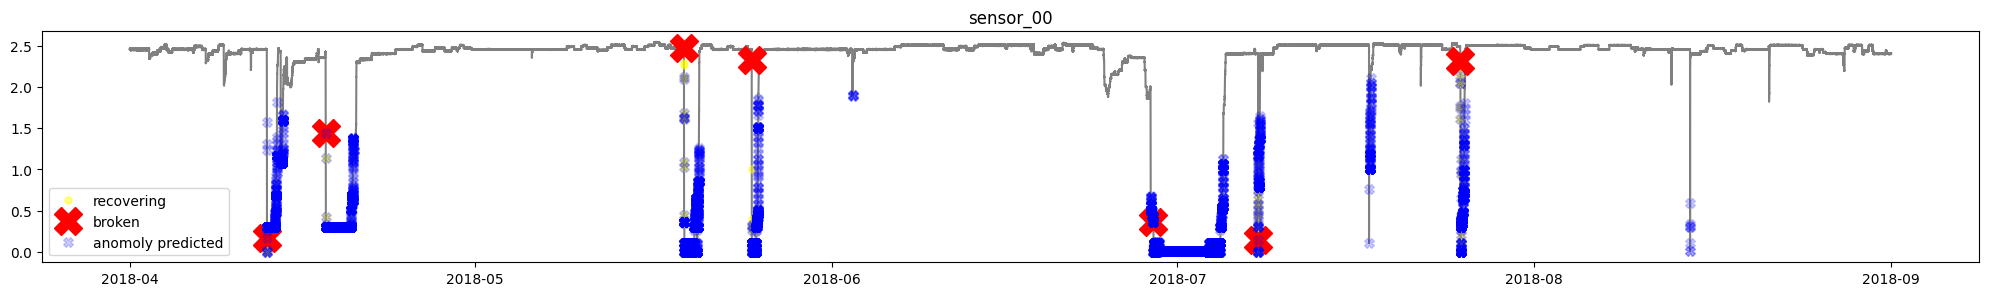

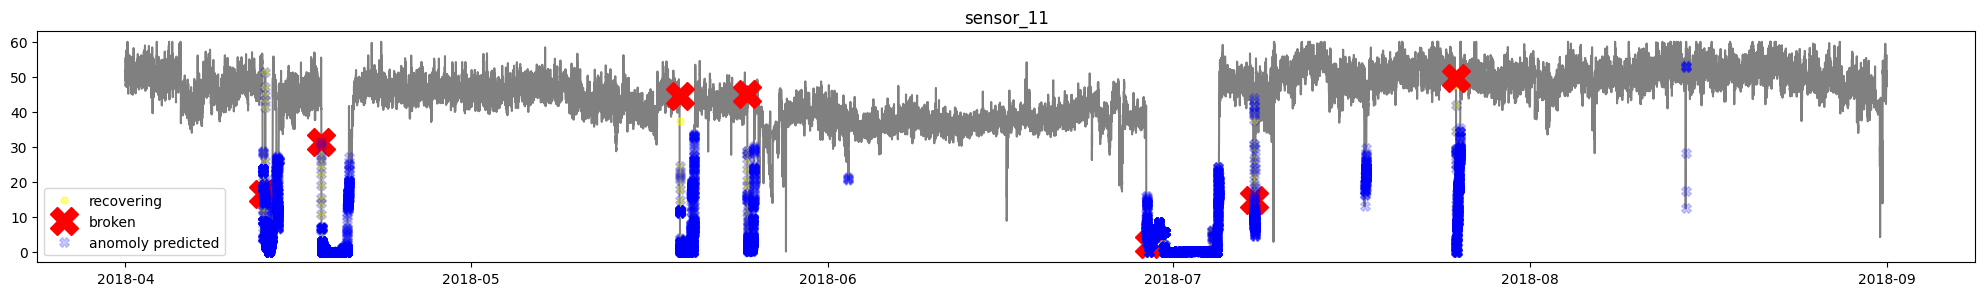

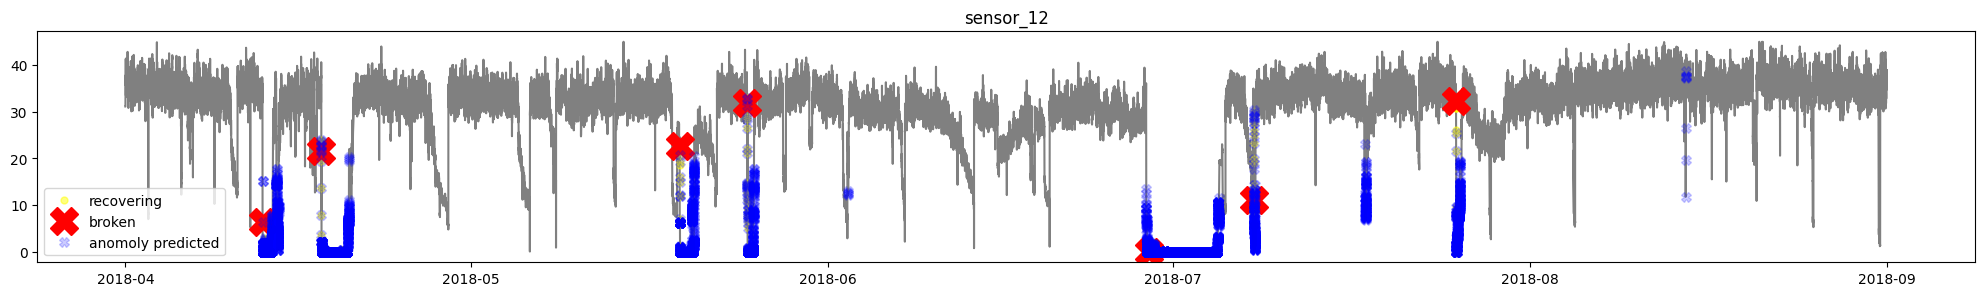

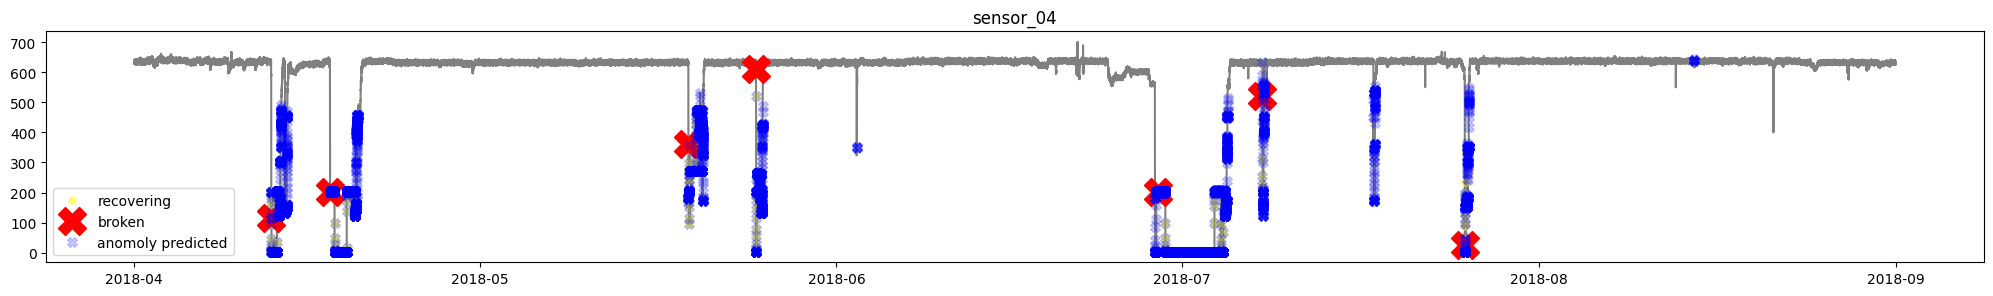

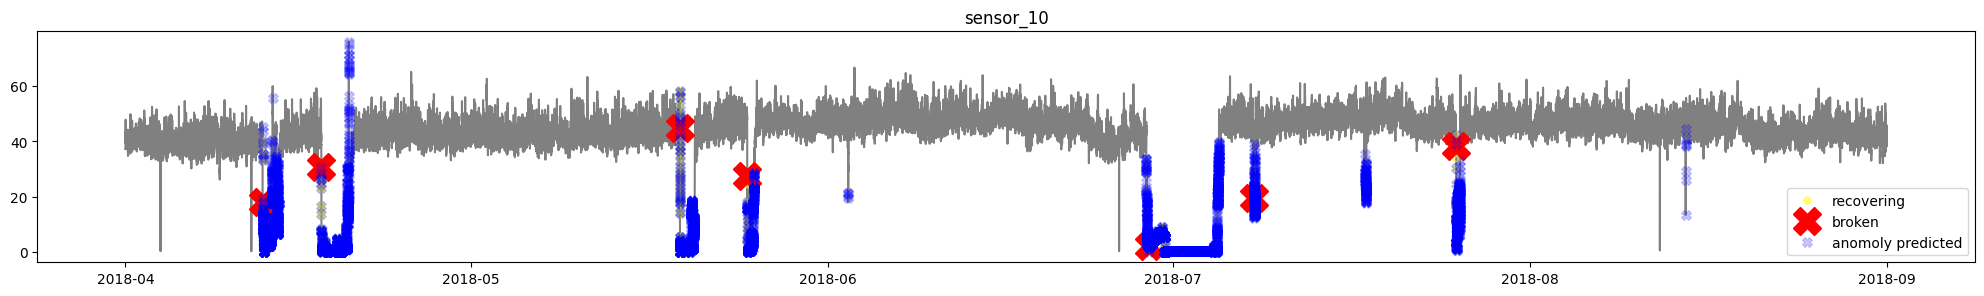

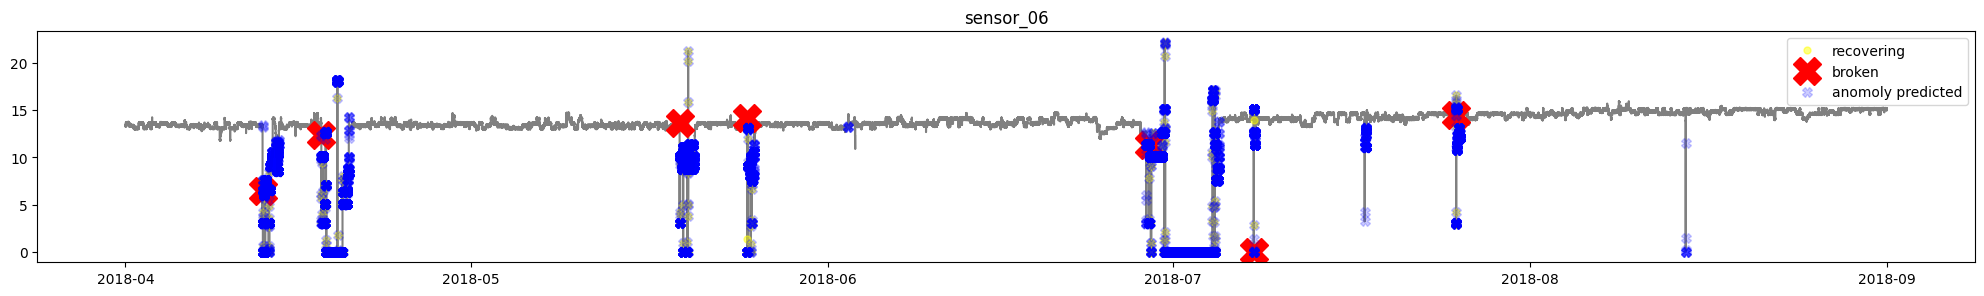

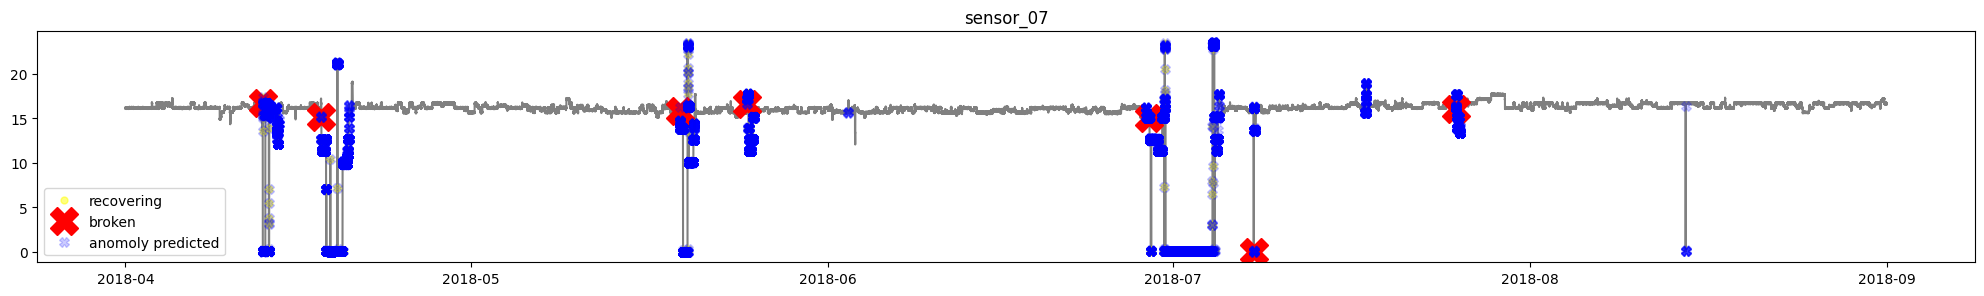

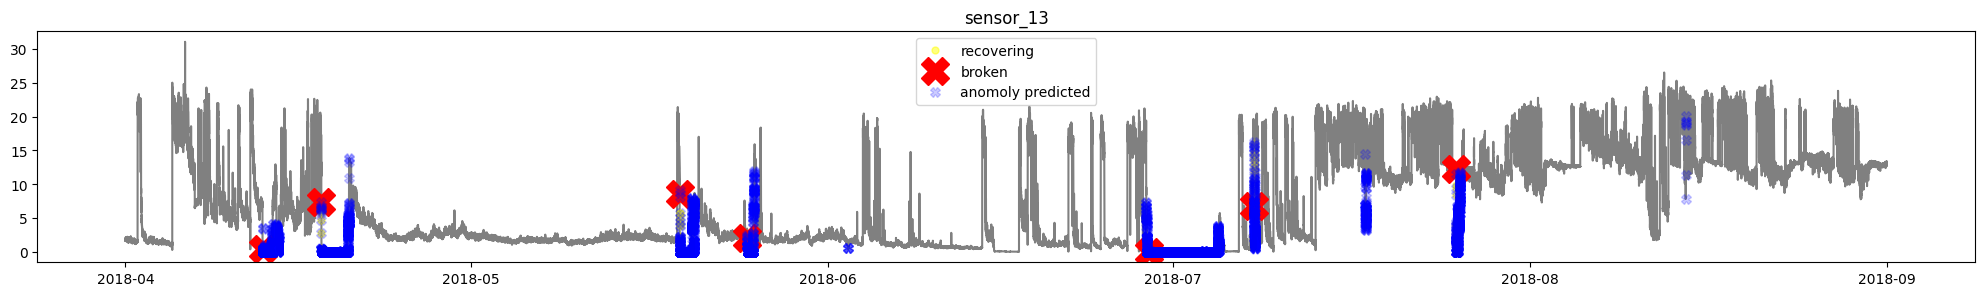

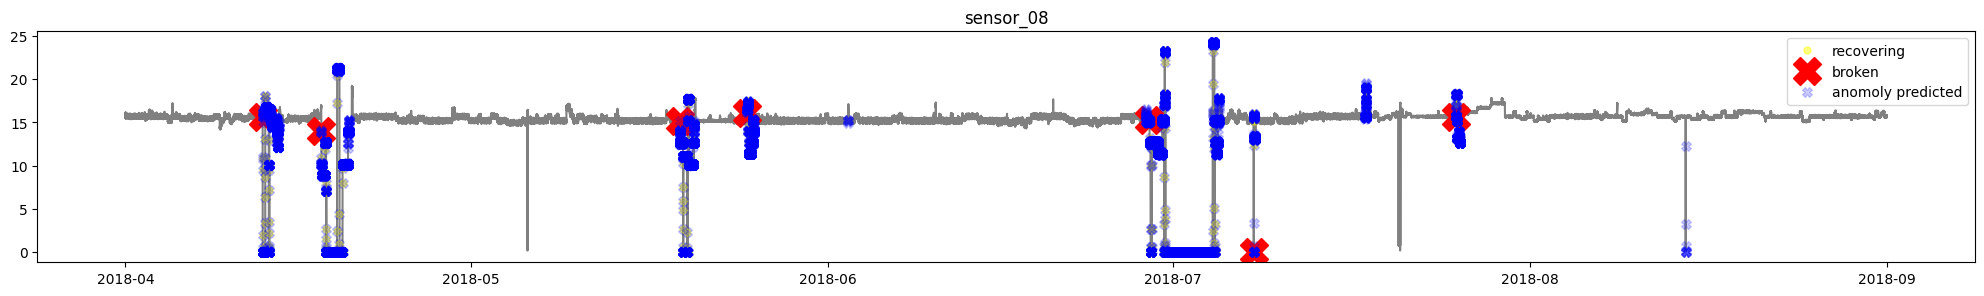

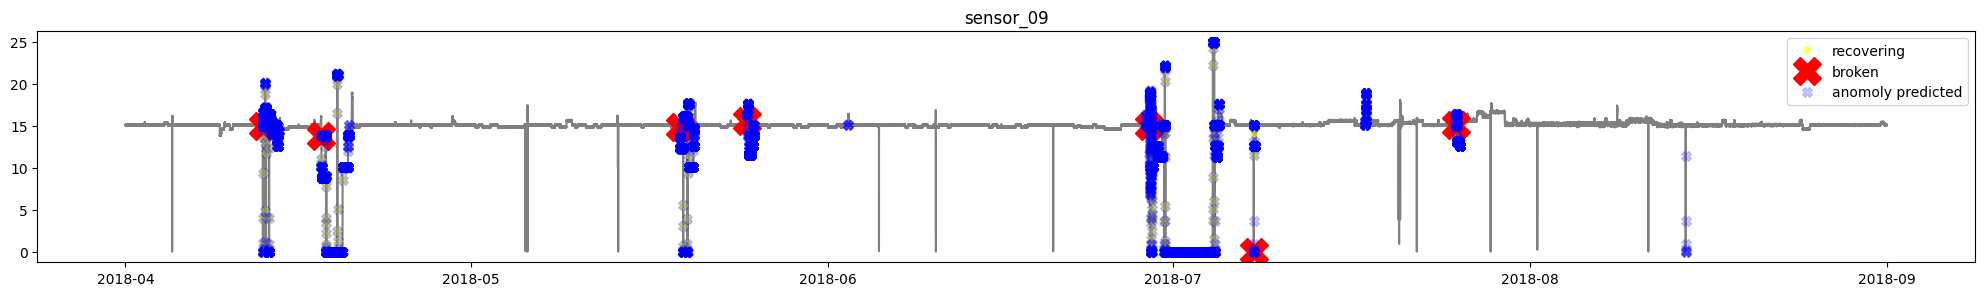

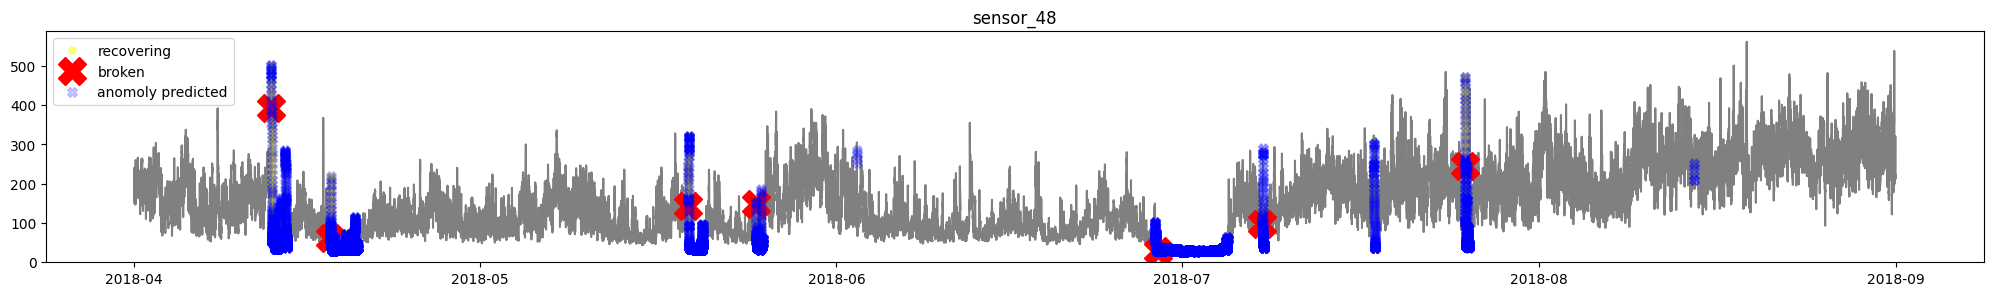

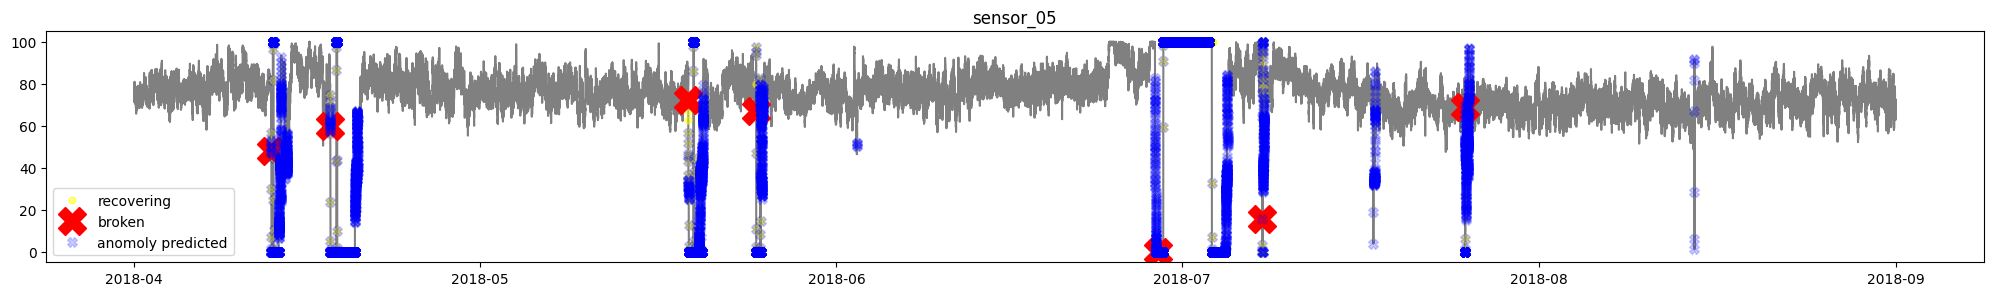

In [60]:
not_normalized_df = cropping_df(smoothed_df, fit, 12)
not_normalized_df["Isolation Forest"] = selected_df["Isolation Forest"]
plot_sensor_anomolies(not_normalized_df, sensor_names= not_normalized_df.columns[:-2],anomaly_method_name='Isolation Forest')

When examining the plots, it is evident that the model successfully predicts all anomaly spots, with only two minor errors. Moreover, the significant incorrect spots in section one of this case study, which have a considerable impact on the overall outcome, are effectively mitigated by this approach.

In conclusion, for this particular case study, the optimal configuration involves employing a supervised method due to the distinct patterns exhibited by the sensors. Utilizing the label column (in this case, machine_status) allows for the selection of the most crucial portion of the dataset, which can then be subjected to the anomaly detection method.